In [1]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import bz2
import base64
import pickle as pk
import warnings
import math

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Exploratory analysis

In [2]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

# Total number of NA values per observation.
train_NA_values = train.isnull().sum(axis=1)

# Sigmoid transformation
#for c in col:
 #   train.loc[:, c] = 1 / (1 + np.exp(-train.loc[:, c]))
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0
    
train = train.fillna(d_mean)

train.loc[:, "is_null"] = train_NA_values

In [ ]:
# Add by ID and timestamp: std & mean + nb assets

In [102]:
#######
# Train pickle model
#######
full_train = pd.read_hdf("train.h5")

### Evolution of target value and number of assets by timestamp

In [ ]:
mean_by_timestamp = o.train.groupby(")

In [5]:
# Plot the correlation of the variables with the target value.
correlation = []
columns = []

for c in col:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], o.train["y"])[0, 1])

In [3]:
#fig, ax = plt.subplots(figsize=(15, 30))
#grid = np.arange(len(correlation))
#ax.barh(grid, correlation)
#ax.set_yticks(grid + 0.5)
#ax.set_title("Correlation of the variables")
#ax.set_xlabel("Correlation")
#ax.set_yticklabels(columns, rotation="horizontal")
#plt.show()

The most correlated variables are: technical_20, technical_30, fundamental_11.

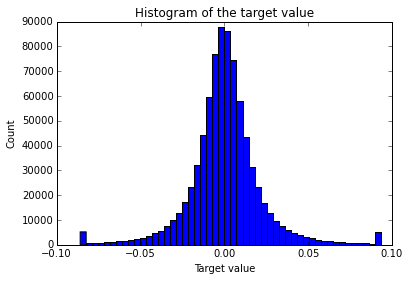

In [7]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

### Time series

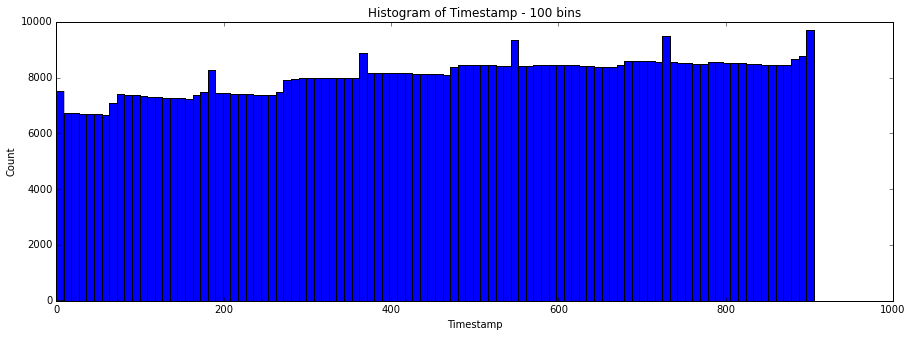

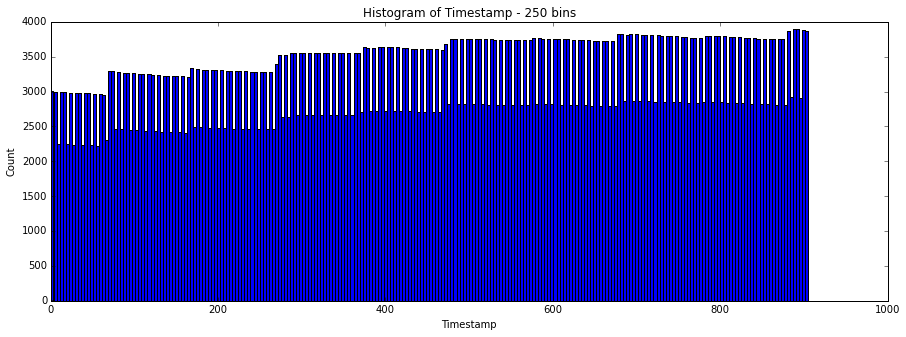

In [19]:
# Timestamp repartition
timestamp = o.train.timestamp.values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel("Timestamp")
    plt.ylabel("Count")
    plt.title("Histogram of Timestamp - {} bins".format(bins))

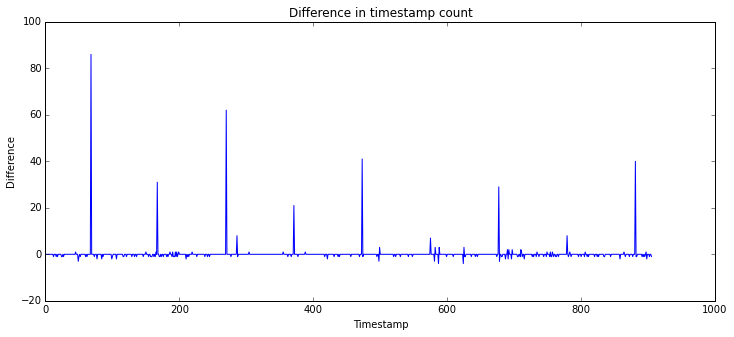

0      NaN
1     99.0
2    103.0
3    101.0
4    102.0
5    204.0
6    204.0
Name: timestamp, dtype: float64

In [3]:
time_diff = o.train.groupby(["timestamp"])["timestamp"].count().diff()

plt.figure(figsize=(12, 5))
plt.plot(time_diff)
plt.title("Difference in timestamp count")
plt.xlabel("Timestamp")
plt.ylabel("Difference")
plt.show()

pd.Series(time_diff[time_diff > 10].index).diff()

In [4]:
# Peaks can be approximated by 100*x + 70
time_diff[time_diff > 5]

timestamp
68     86.0
167    31.0
270    62.0
286     8.0
371    21.0
473    41.0
575     7.0
677    29.0
779     8.0
881    40.0
Name: timestamp, dtype: float64

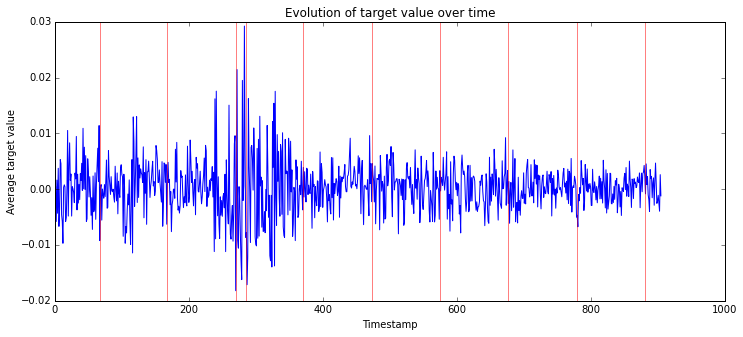

In [44]:
# Target value distribution over timestamp
y_distribution = o.train.groupby(["timestamp"])["y"].mean()
plt.figure(figsize=(12, 5))
plt.plot(y_distribution)
plt.xlabel("Timestamp")
plt.ylabel("Average target value")
plt.title("Evolution of target value over time")
for i in time_diff[time_diff > 5].index:
    plt.axvline(x=i, linewidth=0.5, color="red")
plt.show()

In [5]:
peak_dict = dict(((time_diff > 5).map(lambda x: 1 if x else 0)
                  + (time_diff > 10).map(lambda x: 1 if x else 0)))

## Models

In [103]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [104]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=6, n_jobs=-1, 
                                  random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o.train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 1722.89324713s.


In [94]:
# Using pickle to save model.
#saved_model_2 = base64.standard_b64encode(bz2.compress(pk.dumps(model_2)))
#print(saved_model_2)

In [10]:
model_2_str = """
QlpoOTFBWSZTWUNow9MDhGvfgEAQf///////////////YYrYAPggAPhAHwEAB3FhcAAAAPvkSgdsoEgJcA3CcIIKkhBFQW8IHlSgPkVrWztmnc22bSY7jqutKhdZ0NNKMMlJSiZFNBixuuu7dAdAadBusBQpkADu661GzM0XGKtDgNnt6K2aSW2UAJO7rBQ47CgFAdLgwUGlnejuZrTbaQjwriDoB0KA0AVbrQAOxZB57APIAAKAD2lB0aqdoF3s56ADQUGgANoAFbZqG70uAB72AAAcbXaU0FZpoHNg6AaA00ABsaplTYxmm5YAChQZAA7uVUqilVY50DwbAAHQA8EAGrutenVVW29bxwDdgAADAjvpFKUoBIAAAAAAAAAAAAAAAJAAAAAI9MWmFKKpVUoKIE913LvOdKiSIUqBS94H289CgBJIFAioAbs5Ch2woUpSqAoVQqlaaCgWAEFPRo320Y3dANNIUQqiUAAB6a2D6RemogAPVXoUMi4A7j09CnxaOhn0SoAB8DXQAAUiEhrUKhOwNVo0ETth0GlSUSBrUJVKETWqKAmKWoKoCqClAKAoSBKgqgkiUBSBFRKCIJUKpQkolQkoFVCFAChVSFFKoNaBRCoUFSUKAAAAAGUAJhKCkIACihRJRIUqUigKFFAUJAkFKCgBQKoqgKColCVRABRRJQESgAopRIkACQALgABmhQVQVfPADOjgO33JaCQDh9biMAMGPRd7OBQFAHAXtmsAPW4QHcmAAAAYFyMdBu+rAAA0A4L6GPoDefTKHPb6AD0AbwHHddT0Uod4eakONgKKJQkiiMoD13SsPfFAAKSBVUIVooY8AAAAAAAAG1KULrIm2sZMHwA3AchZtNNKAUFAEU9AIAAAIAAgAAAAAATJpokDUwgCaAQJoAQAAmAAmmjEwmCMTSQNU/QaNSJIICGgJhGQEwj0nqMBoCYAjAUDTaSBCERQjRQ9J5TymnlPSNlBtR6TaT1HqPUPU8kAeRAJPVRRMiRqTamkepoaaA0ADIA0AAAAAAIkgQQQgE0NJgTQT0jQ0anhTyaYSep5GhoyYqN8vy/zQfvED6QOuh0BP2fsfX+vv1ZH2fstttNuW227bbptt0227bbltttNuG223jZcFttw2228bbbbbdRLm5q7bbhttt42d3d3dzQ22222w22229Ze7u7q3YbcRDbbbbbbbbbbbt5GZmZgbbbbbYe7u7u5pbbbbxuG222m3L3d2t3dptxENttttum23bbbbYHQHWAdAdEC4yQOgB0qIJC3MVY3jx0shppppqGmnjhNbRaadtBppphNNNNNNWy003hTTTTTUtOX5x5zJTTTXEWmnbzHjy0000wmmqqqppp0nDTQaaadJw000006Thppp53zvneAg2URDN6zsiDrfP6f38ig7gI3k4tY4oHcWlAaVEoUS3AoOKFLxQJEEtbiAgxEGyAlQZEkAvdAM2pE4FBgcog3BBp2jggQQGqMIIN6VJANbWve+JeFkQdUB0B1EgdAdbI66A62qM6sZndbpwdbwvcb0zreFxreF68wF63het44Ot4XreHGW8uHrelbDeG3rbLp45L1uMh62i9by4et6VreGHreENN4Xus4XreF6G8L1tZDlvC9bwh63het4dbh4oeusL2W8L1rC51vC7bOQ9bwvW8UPXWF63hp63oLePC9tuC9bwtsvC9b3Ybp4XreAvW8L1vCxreTD1uy9DeF63hd63pbTnIet6W28mHrdl63ht63uwobwvabwum8LBLl6y23het4XreHIcN4Xr3C9bwy9bovW82G5eF63hL1vC9e4XpbwvW9cHW8L1vC9bwvW8L1vAXreF63het4XreF63heu3hc2Oh1XRIJJJJIJAEAIAEAIAEAIAEAIAEAIAEAJAAAIAAAAALbWvnx79Xv2mmDJEaHZ7/2/pzwnmZzzs9+Ntt43DbbbTblttu226bbdNtu225bbbTbiIbbbbesttttttuBFVM0223LbbabcNttvGy2223rDbbbbbDbbbb1ltxENttttttttttt5mZmZjLbbbesNttttsNtttvWW2228bhtttpty24iG222222222229uJjunXXQA62b3bW8yeNtu226bbdNtu225bbbTbhttt42W2229YbJbbbbbbbbbbbbsDoDo9DoCnSpKrpUlWqVJVyqSVS8AACAAABjAEAAAAIAAAGMAQAAAAgAAAYwBAAAACAAABjAEAAAAIAAAGMAQAAAAgAAAYwBAAAACAABsAAAAAAAAAAAAEAAAAAAAAAAAAIDdl8xzWd7zObzzeuczmlPU61PcbWanqD1PU9VvcdJnU9T1Np6qew9T1Q9T3HeF6nqep6i9T23qY1PU41Paep6nqxlPU9Wt5Op6E9T1PU9VvcdJ6k9xvEtxynqep6oep7gxJJJ6nqep6nqep6nqep6nqT3G8Wp6nqep6nqep6nqeqHqmW99sxxxtt8Tblttu226bbdNtu225bbbTbhttt42XBbbbbbbbbbbbbqDVTTbDbbbb1l7u7urdhtttpty223bbdPd2d3d223EQ222222222223VbZO7uxMHZlXagu7exRlPejZN48etDIx7EpkUGryVMO1UhbJjKsxdRtnRRp3ZZTcWNku6yJThXAuVGDWMtu53ZiMvYJiNjUKyw8eVV3c1ucb6a23xrbW2JqW31vvtbn8/7z2pIvqiMi1EKUWqjVRRbfkq4xtqLRajWKjRjWNaNWN+S6+Grqt4ajaxWkxiq9/qPv9r77nfwcmKtivDIIPFwQbgg4BB0CDWvDw2vfSBNqiLn35pUTiVCVxxlZVrrby3Ly9zNrHhE3E6ZODNm6mUyesV5cZmLdc5IA6A6kDoDqMA6A6nSbxLBgWq5zFukzqRvTsGcU7NPL24GbO5rSgOblmad1VJk6XdSlet9a1W9qlaxvtsiDgEHeyIO6CDKFWHVJJtJUnnWt7V524ockm3IUBcUj1CRyG5Jjd3ccUNyRnGSOQoDXLu92XZxyGyONgckcWiKRyHJJpxQGwvd3euWruMjGMzwuyOQ5JOcLsoAoHcJHIbkmeXdxxQ3JGcZI5CgNcu7IEOOQ0RxsDcji4RSOQ5JNOKA2G1JNctXcZGMZrhdkcmuSXvBdlAbikfISOQuSa1d3HFDckZxkjkKA1y7u7Ls45DRHGwNyOLhFI5Dkk04oDYPcJrlq7jIxjNcLsjkOSTGy7KAzFI+QkchuSb5d3HFDUkZxkjkKA1y7vNl2cchgjjYG5HFwikchySacUBsMbu71y1dxkYxm+F2RyG5JtOQoBCB8hI5Dckzy7uOKG5IzjJHIUBrl3ajkOOQ0RxsDcji4RSOQ5JNOKA2Btya5au4yMYzXC7I5DkkeyQoDkUjkJHIbkmeXdxxTW5LZxkjkKA3m7vll2W5DRHGwNyOLhFI5Dkk04oDYc5d3vFq7jIxjNcLsjkOSSbLsoDcUj5CRyHJJrN3ccUNyRnGSOQoDXLu9WXZxyGzdl3JC3JHIIDeru45DUk0RxsDckXJJHIckmopBsNyTXLu45BjZrku45Eckm3IJACB8hI1IbkmeXdxxQ3JDjikchQGuXdxyHJJojjYg3IouSSOQXJJqKRDYbkmuXdxyDGa5d3HIckm3IUAIHzdy7chckzwuyOQ3JDjjkZNxSG8cxjGbLssjmhwjYg3I4uEUjkNyTWLV2Ngbcj4opKhIhkZGIRiWUXsqUU+03xfS/1y0ezqQ/9uuYB7pn4uGceaE0Oi6dj/SS/cvA2d7nQb/MkiYY7A7WM+6SWy0SkYigUGdNyb+0SU6ELrLXOWpVs+MT4SLQFRvepb0eAlABNk8oJ3GA3vYi3KTFdO1cyYRmOO42bN33et2Dg/3XxXdJCpvgxHvHwEB0Nh3XZWW7XEXdKmRsvIQ897guHL9d645Vctc47OdRxc9W/gg8kKEjDNyifdRwJVBgQ5YmjTB+ExoBPIiuIcJARgrzXPaJgz7zBQfI6zbgIiliLp5j1WopTNxBDA6P1tvscfzw9dmfo2q2Jx/BJdqj/7sDvlCGe7o/4fY3Q266+NoqCnJ5kxFceg3nLyFgYBDMBtnasBqfq9KRrDl58UnbCfgX72udqLjzehCOfW58NWI/PQvzuMepq+Z3qk1lKVoPtnZqL/IJhWeaYNxtdkbeIdqVG7O2h/nRcFA1odLOLtDoOt1Iu/ojMHDnwwNf64oYJNS5f6XYYyN8TVDomHHl4OjnBkQtAAgICIiIrEAQJzLotubqvxq1AbA8Rjg55Y7U9rOR+uPmmdB1COVo76c6QUKwV8ZCYdKtvJgwSvOGHDHSaDqutt2QRCn5ORfES6i6OsK6n9Uy310r2KORVFU3g+5OJGSP0NLK4ABZzohIn6Ssatkv+SuCywyO5Mb2m+xX6kI+7MZXlMV1FBSebDM1zd1t6/g6f1Y9X8fNp8IEhCEkgQkCEjE3+Lva/7v++3z73U4639PfbjtKpWwQpSQ9GBiBfP/1rsz3bn6N6V8bFhao6XYeOCZ69JhbmcM46OdfpOaC8G9lmk0YfZfvmyvtCDYwUxjQFkcsCgEx4xYdcE/VoHXFCPKR3MYjEGAUDtOZm+SI02rxPtA5K8WZ6BJ2VNYd4m6+NT3P4hZbCHWD9NmtKAJQcHUNZn5cDEc2RcJq3P+h/yo0pFgzhRNGQG5Y0JZYAS97zSZ3u33i4fpnJ5wzmfa/D19SAnSCXr42gMuGnkXDf77/sZhXCey0cRAt28Z+DyOyB7td+8flaCbMZ5LKDnO5gUyddcKu+1zS1p/rcgZjOwT6/rEy59kBP/jldAFpUm0XuC13zYk46CWl5s3deM7ag7dQrLqowWKV4ihHvmq+WF56SASIybX2n08n3VLLRFL8tXmXgGGEKBgWapFbfcilOcPO8WXqfaeVzCk17iAi4hgiYKB1EDtXnQvLxzFOv2kkZXnG/N2A9yREo30/Xeg8mXlpevZhbTsFu+Kl/BZB/pkedzclutl1bflJ/9SfdLGJVy0P2fF2As2Ht0aCdZpNy0tWxf8go9FD/p0kP055muC4y/rm8YmtO9C+x/Ke5snM/BeVrvNKYU85R127V3nHLttswB964UNxNopAQX1GGsUyqdsl5//NrMcu/RfuL7qmYSBrn2GrhyDAzLXzO6zINvSen/GrcT9d+G+e6PJ4mlPGwERpS+YytMI0dxgCJ9oSAAGcI5SRspS1EZLIpmmyZOyhksWRGFrz33XaSPRJ9TxvHJfUcr/HukTvjW3ZgYoAAwcOjzVf+ZygsGS+z0jiGQYM90mATZTe3KosklGEF4y2FxaxL4BeRQIQBouWrrT6dpTCdteEVaNZmHYIlPx/WPrR+tq+zk7SIGLyqunNuIPRFxUrAC5/PmLKFZDz/08Lc1JrZu/AQzJAcOcNc3h2804H3eDPjnFIFroFYqkbSkQKh2FsvdLcho3YVLTP/yQsyS0PwNLys3TIq5nLXfYUGizhLbaby9X63Vly6bcj4xFeiiKwyf90EMh9Bn9XUM82xL9OvJkoIIQ8roNwEnIUAm0fsyKbKjUBADYJtdBUsRBAICgEQRAbgiCYygF/FJEAgKby5BADxBT9+ROXKIIa2CcKAQEcgNtNoHqVIIBAK5JRgRBAW5YixNOgGwEAh08SKAhtsFsE4Vhoh+HIIdMP/XX+Xk1+7jStHSi3bfJP9j3f6/L6fWO+Wo08iA+3LEWfhyH9bjp4F7nJ7cwIP2opC//E/Th4m3L/pmm53Ee/XLV+sxKNdYFAZwJEMG0+7zg0gRM4iYCIai3iZcoMTcY4+PvJo3fIip8fy14QH9cH1zjO9gH2RPlij9q1KYg/lj5ov5Y/VA9ERPNFe8hJBsAg/PAFKFgokD3owgOIfDPb2r9MxMx3nWVC0T2T+kAvF8Yn/cA6xInhqgtGZqieaVvQjRIkxhMJpmwmER+p37b1UGPfroX8u0T9N10T6LcetMM2gMAZ3nBnKTB4PcfNIDsv4EHvL1b572XKjB/ORgDkw3kDNurUjA3gf/4uPw12x2tRh8P902M0xf+WWBYFlllisXiNnbK1xwdcrIBai0nA5G2thwB/1ZgronjAMqBmNusTiAsAq1sE4fM9bj6O5sn+kUsqaH/xnfu6UooYJmEJKDFkkK7MdJiA464i9vHRLr7hSaUOQdNwHYFBxyAQ7A0emmuzU5F2MRy0XcyXmY7lciM8Un6cZ6UblyXRZFYGMAZKwwwMYxjKr+bXyWh2bTiurddD6n78rtzThsvleB+O+8cs+rHBPmWh9tD0K8/Md/0wpWpSL5vTcL/xShGtvub2iX2YB9xr9yqC0wDWDyfL45Nzv6KAcMRMgND32Ru9MoeDSEgIwWenpPEZi3doh9XfiAwBn3rTrcSWckM3/m12Pv5U8cuRaUj++jVB2jRQp7iYfd6bjP8pTFSzd0mohW/n0NX/Ta4zM5dzpKpU5GjGj0aNyHnFPBMGoxvZYWTR1k+hrKQYS27MZHKBUAk5uIrUx8nC+yfOzjURnzTyOnfZEhaJKYMOcaY13hWTqp/L6AvCiBpdeVGmi3FVRgYUA/WuUA+Gf3Z+A1/GWV9HaJEIQjDSS3X7F6ctZ2ElRd1x2rfinldDVeiM4SXFt+FNB0eWIzJpZTSkQVo+Zf/l2VEOlgwgJoIRhbcaQdJM+VemOB6x6kIjzYoNVK7UfcyECmHVxbGAN6Ak8jHz322rnA5MEuAjw5afUuW/7FKzBMylnIMD7M7dnFwTjC3wwRZh22bbHtB13qmcpa5emGU/QWeRtp2k+A6M56DDZZqpIK6zJoVlmokYNb2RLRPC9r3BB2sUxv7UFTqf1g1s75mtWNrvK0ruf8dWUcqyYEjJpDLNqH1bOFLoh2HOlYvLdu9u+4X03a9OeM6YLiQBJgF2mutDSpZB5HbK5HnLEYzE3/yKxsiLpDUbz9r4NIm79JdMLE2r/i6UttAApex4WW9ZkoCQtEYehyUxB8kBdZad0V7yi93MwWrUs+OuVCpn3L6RvPR4XF1R+lLQL4X+zjswFxdEzvgwSG3J/17LXEGFQh/Po3MFo+Wn3WPdtjHo+I4kA8iIf2QnzJTzAr6niRBha563I93VIGpmHXcE27vz3OTg358HHXZnZefpfq4ilpwfPxkeiPtWsdDGRmgjlLu6n7uynqAvF3+e67X6Ln22YWSEi92AfpBZYAWeWBfSd98LK7Z25+M3WXywwnmvDibPcidJ7Jit4Gh7FQ/wWq1dGxe81esF/ndZi4bzMUUCyhACfyJMLhJvb6teZn54HXlnnxIvxoMsuNoSfTsqNNhMhrCOK905+/ZLNG5DEdQrQTUK6rnF6E6KJnIpiYmnfcQKYl4SjDnpLfj9YzXGTuftd1Lu5mLe2l4HAA/lit8mXvzg8qnUjD/xnLCCSB1Bz5FzWBmPBxJji+3FNbtPJ8eBoYwBkoGKlv8BzbqxgeFYfTdE/TTymqeeBsAtJrbavz2cmz/MuxjfeAbYjOy/EuxiOV/v93UutzgJC/o4mwlYB++OwaTt4DzLYcGUE0bVe8SOmn1RwXUnJwdqGeLvX0uq1267L1kZEHfiCM34xsdnuc1YkTWSp0CuvsdF97YU/13djwdx8Vx02LHCcO6e3RdAfWJy5TPWzYI9Du9x/PtqnqKFpgXu0dOs1fX+SHXnPmyMDnw2v8GG/gVOx+7rZwj9Kysgdtg1r9nOEcV+MbH52AAum97sLyLlueOyUzDMnnXRoUSaBZ80jX/ubdqeO/puaqIu4XxE4+fjbuLZnL4SQf3dkOARPi4ss9dbLHAokeiplVrKa93kPzCGw4HzC0Vd+ooOROwmNA72dxbyKKSJV1tEL5teh31Nf90dCzF9oLyWt/tZKN2AgoiLyWmStjy8bjx5EcWqRgZLUTCyl5vYyksEtUnO8u1k/sPWX7Xhs7duvZadVlfubi7VLVWTcayoqrBrYxjF5uc573xijPT1VtfjnnaZ5zzna5tfbngEGFkQf4PPGr0iDOaidezHeLuZnVjmNwa5jVjmNtYnc2prZi7ezGrJA66HQFVbe6k9d3d3qbaUXaTbgDoDqciqbbcrbzc1bsJ6nuNrL3L3FG7qSxvMxLE3WtpvNaO3uLW/3z2QB0Op3vvN+Oeeb5mt7WsZ1kEGcnMcQCojmaim9qA2gZiHM2ilQC0R4nMUqAaiO83ilQDUR2nExBLQDUR2nEUqAbQDEB1N4pUAxEczeCVF3inEZOIOvGA/AQIRJAGR2icW8LINQMeJe8v1nlakvIRvtmxe1FQxi3v5wNiSKQhJiNECbPUQ6r+E1KM4lKmxrbLKq/1kdNreLlO0KsVTGiCXfW4k3WMjW0ZCNN5kjabVCDaLTJByYtYvECoyQzCipWaNoIpeeYvWxR3Ci7iMyk3E26Ta0NrQRYmbUkIagVmZtW03zdbfVRxxSXjPCmoLIQgScxqYmINpYqpVSiv2Cg/HbnNcZB2sUkVeGenmFVnwUevR+b8czw+nVd4Q8bcVjRVEC3a/o49Homr3x5wUQx19GNeNuK32dREHijFZ/6VFHiBvFFfGAG+1ALVUoEqhWqoAlUIAVVCNVSpKoWVSAVVKgveYgKd4tEUAIQhAkFFZAVJAUUqAioABUUVEXxiKr4pAQRBLQRRSQFEkQBREE8IAagoIuYgISICAxtFq214bWi2Oc5a0a1qMy1VFW0bbFqi1ktrYtsyIJIiYiAhUAQtABQWoCDKoZBBaiuoIAVAzAG8QALQFALxcQFEtAAkVAG8FWoi6Ksmqq41auLVFWNo1ohGRGEAkBZAZjbjwv4du0x36l9SZvjbfeMbw+kqDbREG2Rgxu2QBMZVL+9pX5ApE8JXaUnYgqDSRFFkBBgS1cca/Fbi2sU5y3HXEz8m3VSXiYqhPGKGYSJ0naBvAUv4X8M9wQSz695PqLWdl+crkm+qrTqqxhMTEwLZm5Icc5vM+lfZ9/G3E2qNq1TS42xXHyrX3W6nXNurjaTbjeO8tHXRI6JAJgjroDT69PvxG/VKu/VXC7l6wKW8S7xcYAgE0xA2nnuS1+Xuk26pVppC2qjWrBca41uttxvxVeGuvpfSi6oq8Ct5byq/Jtr5XwrX4/h69e2SfalvqsJy123rNVzrrqiT1xR6iSST3Qjv13vcz19eO+Ps53Xzmo+6uLQJW1oNt9LXF+C6I6Vqzfdxpm12FQWS5RS1FphaNREqBRDxiAVEq831125zXrJ692s749Z5Y+b6qlvIDAaaYAwATAEJeeheU3Sabpe06qkNVSVFbEat4a3JcmjX+JtdWKvnnFLxqJIRiMhqLUJADtv1xgl79tuvbtrBrE5vcveH1SSzw+miFJhuRvfRMVXkiaeHPGvw93L+y6rFRWNa0msWxo2jbb0rjVFUWDRRxtyAg1TW8WpaBIokxSnXbjO9bcc9dpXXRrOd45/iXTSpKuK767So72xvdkGce4inYVKpceFaYQhiCtSQFEkZFGRXtA8qqRahaJIBi9KGJiCWiGIBeWjSrnr3zzx7u8X56yuzhvHOGJnqkl+GuZYAAmAdREQAAzMJqUvT9v6ar1TSpum0qir9VXFfi1rVxUhWK21+ouNJmE/Rzg1GwFoonebjFXh1ktRdajcVFGjGr6/P+f3ZWe74G/d76xZNrW9SYXuhk0Yd1VCYgmDHkUSEnbep0DERCQP7atJY8qq0nj3xjAYjiVHrGiNUFrY3uTy4wK7xd8yipJCS9O8LXlAyAJIPaBUTOdr31RXEMwN7U6xWgbrgPJZIttJuquFYdLNowxZTw6X1K3hYmIZhtAcRMTEagEzVQNSpdM1WhRq6dIM93Sia/jFuKkPTUdd8a+uu5vf+f8cO2KDtOkkxFsR6Y2t0j2metFQyfulMs6sFvPOt1db4Xlt4zEGvf1cq6/Jb8G3ycT/vw5ksbQ3hUHtKhJ8XWg1D6dtrOpIQmYKlTWX+HKpfb1G9Mf6PRWmPmTTr9MF/NzEG4ZtgBJa0qeNFt6vaig7xqCagI8T8cAvA+Wv6/C4cEdodJJmJ6Rh8cbRhIRkQ79ZlXBKPb+3VL9T6a/gedluV986j3lyumo6Ul4gGeu2sQzlZKtjZtExVpYkds5uXxQW8hJ6jmHcxzadmzOFp5abLvhy8YdUo0lbpJN0qbVDSQXpXi873nD3rW7miD1bWpLejktTac25h4yWMkXM3ecTTwmZEirxpK+PWTQc3N7keuBk3kzkUpUqyAbcHMGsyk3gVvVO8rUXaQxQZxQ4jks2galvGeiVWAdSCQCQf4yKmCKuCQeiDMEvb3XbyRHF2owtCb5281VhySRcTMOYWuO5EHiu0022FVSq8GHGksU9NRutFW641dOWxDqNu9YINt2WalUOm6pum88cc+LtyJcdTJHx4u22l+hd8eDPIkO0mhtAqpJtPjE23E0PAW166l5wJNhpzOMTLWKjbSUnTlUm1YMBM6Q2QTEVSSQ1ppSUbY4zNHIKngGqadLGBTgYyuawm28OmoIb3iVwFlNvEKgNopaDLSvfte93iDnjjG82zGSN7VOl1ImMa3i1HbTHleoqpSntmBI/e6J2c61hWzrUtPTHyRRN02pIo2qbWWqVR1GLJdXGKT8vf3eLwjvnu223Z8uK6sbkKGn/izi7aYUqSG3XXbvmMbtGripc3JgaBlJFOgQm8NaiMamWrrSdUkN3Ly4uw+3KuWwmvfLx08d4vTevMh3E0qaiFTjKp1mE2ZhoMMQ6EONGi1t5D9oib3fHSrLTsRUa21hq2mm6TTpum3ONS7pYmY8/9dq1oGt4KnQkhp4qmczFqVXg1vYBNTBCEKmbcWK3pRtm2sayAJRVVW9WJBEjAQFCQBIQETeIqlRVETEVAcxBEW0AERFJAFBqACSIqhIAu01W2NXFtorV8NjVaTVTbZbdarFq2q1xbSasWo2okEFxFCiIBIyEfhoUVpYqeDB3N3bd3OedAo77XsCWzQDX7qFMQFbqQNtBtWQZtmlUzeEjUWoDUZVWtQAj+33l/9WUOIr0gh7Isnnt9v9fjhXxiGYCdIqKDvFFUXs0pjNWqquMdVajatVceZaqNojbVGNXFWuLWtxpSRGyEBQixUgkC0BAaGI5ltTS1aNbV1WNqKtFXVVq7azjRa1RbbvOaqo1aQRFVLwUQZEFFWQQCQQY2q2qLVbaqK1tWjZNtVQbbbbVqitWrVFatRVa1i1aotbbG21tjY1WpAREJBRUAkQESQEA8IKqhUARCQVQkqi1kPHNHmhi1BeFiJ2ffq5Vmc3HAWRXKKbdchRCf34V2M6KzOokbENtvLTQhXYlmxpttO2qSW4qBm9Ejq2bXjIWgIcQEDMNcUGfZq01RJfXFkt1oaKhxLMhmUQylVkipTBRxfFlB5xQloUwJJC7V+Ku21Mc6trNU3vYPHSLbyO5NPe7/0GcJVS6aqqSw7ZEzKOJWY4s02KKkA4L07l6eIAt9uc3RQ41TJCRx9urXhXPNnMBVvGTr0pS7nHgJreluPt5c1+u32824GiXnm9EzLlW684XFV9Vqzq1hZmqgA2gC1JBJL1e1cUAje/zYe/GdttZuG0qBfiktBkjO2KkbAwBGHjW3+9OsG9qiMhCIIbQEKgyA5+Pm0zTI4YyYi3LVqWlmQhaHeFiWlR5xqxeXqnO9bXpUdQVKIVIFSJCbaYJJJecFSVZwxZdR0kEgv4sCib2Rx31Fx7fWVhrG5ilVVHSVK2nfJH06MC3BGpB7gmk2+mjRmIeX+71vRrF6xLSQISbzEd5jCtQqAEvRasa1cwgJott1xrBtirRWutryq6qxvLbw2xrV1rY1isd+OX0t3x3jt/Y8ePXjqdXDjGjjFGg+HOe+qNYejZJYnruRO4R0sQVvGuli8OPVOggBf6xijoIBxAIKjYgASSQQTYPOZcbquttmolRoW2S0KU4swazjNt2m1duKGoF7algZA2xq9wklryjbbAgWhmNamWsaMa1hvN28JpJtYQ2UAm0+nseJjCVcNeeeXp43rdvnxvAivxeHVRcTl9byoF4DagmuGcrq7+EjSrMdE2SD1hGHeQh71anYNglHAjidbmolbpJNtpadZ2SpLyiBUSRCEQZDUdQ29u9nfXG1cbZiTp00s66jaVu3exTWNWJp9ZQbVqU1xjWgbasS06RExYm4N5Bwy4mnbG9BzkW9zd1fDX/wyk3GhvbQOgfjUT4IwJjCnTek+OWajKpDpt04xrBMXlrrpF5jlJDMtOzDVtqqadJ4dDWY4o4CGbWzvdxbz5CqWWqE06briyb1hTgunh1/z4OJiaZcnGU2mtm4jvQMnJHNlVP2/F1hO3Jd5XtteFcV77zyuP6C3lqUaSGhpGFJiSNNuuPjblhM4uWJtNqhAgrHVzrRetZtWEbEIQPQt3eLE/BKhNbY/34UtvGNxR110LDOpUb/ZBW6eZFyxVMseg4833h/WItJt50awNNpqk2m3hi0FN4a4++ikPC4H7XZWOtZtrpjpuuMabTtxd41nOWzoE2Pb3hbFKVZbtib00NprdlRNeGvzeVYnTXTVNrrhbxCtWcSomZaxUCt6sbREqKkiTQUUQOu9oqT2LL/tsXXhVYs0FN7W3y94Sw606w6xid22sYFlrm7lBpxJptvBSGqpu4KJve16poRwztCd1S7UwC4hGMu6ro/+SIHQDiE2l+wDa4/HNiGqHR/5FcguwTp02k3jUjY6Q8CKcx3atpUm2uhZbbenRdHDGhXt+aMcErbdZTTdUsORW1Em0mA0noIxWN8gmOhZEN8Ua1RnSeJjDvMks4aP6pm3ma0bTb6wPFxTCHOhwbwkunSMEFHUFFzBUbRRhASRRVkNi2jWqjUbVajatRrbWkRCRURtAF1i9iOqCqkxbaUuc2vYWG7/c3usUsFA0NOsc3dp0reOF8K29hVU2qLKeRCdiR0DyVSRxmngl6w2powuGYYEgTadZYGk03XLSuK92pVqyKXy7whA/mbV06tt1VN02lgsJV6ilN46EiLcK4IaieohYCNAaaUbaejDWslJLC6wR0DVypOC21VpqrfjrroxtompzgsNpp9gunp7dp02ldNDTV8mE40WPlVEYSBvmlCZpUvr8NrTmCFHMpUi0ZJkuUR1/c46dNe3V4uLmJexYT6dHnqRtNWD4xNvXMKW0kcj5ajobuLSsbabkFP7zLXl7g8vEkTaH3/WsyWU31Yo26pZTTBtNvpO5SVTGCN3vMRebukllOiMtVQm8ohbM1a7CLJtrYv78yb6ajaMhkpm9lVx4Vu8itZTo8K6wW0Obzi6pNsBtptbaLzuRotGQ0GwTejcFzcxkxRj59953kEl884gvmvbXnvhfPOY1FY2+FN5c3WvlXFahe3nz49SrW/wLPMPcLtGym21HTSb2xYJEOk07E3JiBuRRjpNqsIHg/bi7d75u9NtOtnHFkKP8OeLrFZ0UtwpLHOTLt4a0dfkt4Pv9dqLgJNpDSHbr+Nqqj89Rf3l1r1PV5bdabbKRWWpeZhfi4vGveNNba2eTKy6+aKSunTaGNx1243/DjmrrSyLsE66YgoTdKmm3lo4HeNOSxtppxj26SXGqjrt8aVLbSWMZalbaS6gvHRkWX1a05wFQFdtD07alQzEU3DKhXNEXTRwSrURt0Mb2iLjNZ1AuMQJpp02klBacabbTU4pE1sjxYlVtLEQ8bWHDl6zbHht6Y206eAeBCasFc3LSbyK23Fs5ELToTb5kyCQC3siiRUv7lgJDsgGYFzAkkgnqYVIfyjSalcxqdOCtQl4VUYgKZjvcq9c8vX5d7PKmiiNfg7347xXW4r25SQTaIYjaJL/dmr0ZrWatCoOIUQcQaTDDh+errt0suqpRNUOmnIuvW8ZbYdRcQsSqqJ8QyCm2K2hjnbFqLVcJAHEV1txWrMUGSlrRWIqvXCgGSQKtQJaCWg1FHiHGIVnOpJR3b01GvC2uNaNWtjRIG0awJVSmq8cubjFtcVEcbcVz1zjXlXJt4VtxRVGisDo7hznOlzmayLubbTdKrBtPpUq5vEMLVrmecVeoEiihUFqYqgkAcRDa5SGJ/KKlSRHEV2moreEgtpt+ydC1GtzbxbFvbVbXFRVuNY3GixznLFY0UVFbwtXWurbwrd7y3hqqN4WMUJ0i0lT6uRNN2nSHgPzmRtbMTVoVtJU26dJegp56fNPAlho/8IUsgU7ksSTtne1ycSlEhGRkS9qvdp1orG+JsKpv9cnLaDTGtaMBdcFcCykv2epMN4gTxOkpTbbeHjiLef6OWlLG0ttSI7aXJdnKxQ6f6GVt0tatvzWJ3lmMTrAda01WWNQDbFIFiIYq+cZM2mJNUFQ39tktDbERMbhxUGhHREXGGuEQCCa5e7UNLJEwCahSJMkL60yBvOB8dJxmiiSeiTUSTm3XWQBGHiyRfRkiFUiTb0t2dBsIZY6JIIsKs5bLWg1jei8N01LE+W3KWdbcVpt1STeEVuG1VAnU0R6dZaUTd5xaecathWQqtPcE02mmmmmk4N1bizpb3hYy5I6R6EmozaCqXUFqLBBcBmzSgRERiS1PS1x4c4chSHFwG5WXuwWu/MfP08/X9u75i71t5im0m/4AOuh0BUU8p5zOZPE7daJHXQD/7NQ1oQHlEHkEHfO/Nc87c7XrjW2bVtnW9VOrHMJYxMascw3uWnMYsGzG06upd6t10K27ttvMzMvMb/TfLxKrbedDoDrmRebGat3HiepvK1PcWvVWJvMnMzMbbdrVmvG8vd3Wex5kAdAdF99rePvvgHQHVXzOc0DL1VkeHBjFOc3FHtcEYo+Ht1jFO83FH0uCMa9PbrGKd5uKPa4IxQfTjGKTFHpcEYo9vp3nNxineXw6o9LgjFHt9OsbO83FBBGKPl9OsYp3m4jPnm4x5XGMY+F9OqMU7zcY+FyUYx6e3WQJGWpqMm0KjIyHXx8P1cGp4yu89U289d88cWViR9ZzgsTk8+Z97mfh7fE6RqyKzzOV+86AojrSB0QR0Bn+cfbS9lGeedpHMPWZ5KFZuRmJC9JjVNiK85QgDJ6JkmWjX42BgDFc12vWC11EmvNbYLqpe+3woX97rtBLyr2t0iHWQQG+LCYq23TCQ6rDvAtuk3UglbqrJLdUgFSn25Le8S8C96Eksh3iloj4wUSREHUUfCJiKNQF80FXJ048O/SbeN837+PfGbarfbc4md+RRvxjahPDGLYgklRMxLW5sZi1C9lUmx0m6WWQVKSSsNJSFUoEdLTpYA118rAHSAKHgxVU7Q80UKl4I+UCXTvuOovV11qvxAZeQAYwIkXQsnMntk1aACbVfFSsLar8NK5cqlKCOrdU5JSbVXQRqraVu7Fb6dDSxZh0rabTY46qOrhbScXfCHlEDxgiDUWpaKL5og+PfpzvLcfPPrR9fVrm+jWet7c52lUx3SHXHX1gxjESw0m1dlUsBGqUpyCpQI1Su6u7ql2EaRNoGpmXxQklQLx1CphV7QAB7QaiI8xR8oJ36dum/QxbvnvjvznNa7W438uNpnfM6CLHflJfT8d2JR1XIXkrLbVDlipAUltq1dysNJDjVK3IJW6TY41SskSXbotA80Q8oIeMPGIKHlBQKgB5QFO3GFJkdr7n1vS+Lig+LZSgiRmwMrKkSAvIMRDYwOcktqumlnBjBVW6uFttHRWGlbtqlhBGi8G9r6uDVqEva1lLCKl4iFoAvPXrfjXkCDjnfjbVuvbBxXNaxsS9Y6nUDXXeJIIISXjQ48NPsqvNLObWHSVqFtUonIJLVVo8R1JHBjFi8WQve9lLFVaCWXUQH1xQAxEFMb9eNXz06THHTrjW3YEGlAd71m3HN0QeYCD2zxmdU80DrrijaAWtQSLVVtN4haXIBiNtr2E0jVXgkqnEAqWjaDiXvQ3jvDN6xAMQuhvFDiIIeEQE88RO8QTzxUvFLZKN+/PbxqrX7+BPDjUznbHbv4gg88Yxz0E9UduvNLvG9qvA2h5QMN6xBLVVoJKpS0q1D1h2hgxiyklRSqvY1EqOC9Yg7VQXHnz0qeaAeaCInjFVvBAqCOIG/Tfjvzbwt1xm2/bxxGklXk13Oudb5mb8qpryqUCNfTptVIKldBHVuqkKTdYdYu5VKBHS0120pYu3x1xhNjObr1haF6vZxMRqBh/fOIouYoAVEF80FfSRErnGPNXoqr+fPnrW4atVjOsWlVkRp/PgwuIqRrrqryWqmbPw3Z39Pv899/O4/Kn/3qKlNoNmZBRaegqOO4ihTRNJ1eJlpJggT2tOakcUGfCr1kUQ/Rm+/3czGsz1hDfo/khjnqGZq169d/yL4rDAkXvseq1uOzqHgQRxthvH3dmTYYqrjudUPCnJx92qVAybuUegTJAItX1MEnWUAOkRkQAAbIybVCsigTdQRY+eRi1PJaAtRBEQSRF1E0pysMXEGCnc2sSyilRq82KQxVICoRFDC/0jr6EHqzszMIiKsXJv+nZoZyaGzHzu+pFwsyu5iTgnxBWay63Due/zOK333tb9+BKayCMoaaUOlDicbCOmpRzoWUPU2qSjZgToUJ8BVyLuFGdgDoLcE6Td5fzG++GwOgOpZi8rZeRn/3KqwsyrimZEfAj7vfrWAHzkdm5UZndnisjBogvb6QX3St2Y07kTc8+MUVGGd7dI2+75eWA6UUvzS3t7gvYRm8mAB0B0yIJiIgEVUBNohjRSFQaIlaNaOMgZQPOxoisidKPFI73EqEiDVdCyDTEIMBhAIznw9nBhwdrUGe21WEHM6wEGgRVqUSJwp9AA6lsUV2WrodBT0PcTBF+hgvRGZmu2Ji8tGL9rw/PHfNvMOnvuKg3CrtRKlAdAdfzrRS6Wd3uVKd8Sve5d2WdE2zwWtlIzc7QfImNsCVYdTy6nLUV1NidlQy4kckZF9BzyjH4MrBmMTyOzdmlMGZN3r5Nw81qHfWjRiK/O3qzvfTX3se1rrtdw3313xQcqsvl3lmlRPLuhVKuKbDyW7vYgLd04rahhagRhm3szM4DdQ/2bjT5zuwyz9+M8Lzybn+a+gOhqrPsR17S8oRM4zsrJrvfL1xsXIZjIpXLVRBuYNxq6y/mq/bv385dQPGLnuaF3fVeTVKTVVamMuJybjo2fsZ+T2qebz1yJ53i2vs3encwXOcHCMiwc/H2+RWaY1WqHHORc367bvJfWMcSmc6vKuJvLWcm5HW7co+1UNjI+ne+7wKDfZrcFx7LuwpaMmB4nk1E3MTAyaKyQoXXdl3i4mh6tSVXGsJqBgxBjGfzA0sEMHD0sERuCPO/KWjhSPx5zgv5vKtqnlHvKxUlzNVREDsMbVz2Q92d0cp4/yXRB6rszCHOGePiiYj3nAwFfWCtmiwb5iyqygUMVzx1sWbY1bCU2Ei2cLmN1Gomp2LlOugM2brcasyjM1TtQ1moqp1u9G1WIb48M6QOcJPOW5qhCrocLqrkU/65mcm5/RvKPbqc5YvsIYMk30cR4ga5EWQtFtaIq9q6ETUK0pxdhpfsKVBOcFWaklFcDaLVeRB4sgHqr7FEWQTdj+ifxNA+RzI7uOVR7+OeaQf7b13G+TM1dVY2e8S7NdRWTwbFkbIW28uBGxlb0xdu/v7N3so3oRyCaZRfwRoiwjMdYCLaHDlYGCBAWMUjYAIEAEC8UGQQ522OKuCKagA7kkkBJAXmIuIKlQ88zJOYairUQUZFHeIAbRWRFF1FF+UUGImpvxsW51StREDyiIvMHrENREzBEzFHeCm+aQOkRbQEvAkUDMEvAQ8PXQEQEMXZlh1wjbOzpjgqSTd9JCzTwzWWt+jNXJIuivO4MxvObswHljg7yMrLPBwF51BcTVSKrWkLNmEgB0LFRuzlbcm1l2FlK9FY5jXuTq6PWR+D7v3dqzsyYcMeaD9z2tefNn1/lyqV23jeZmYk2wOgOpmJp203qavVuCgQaFB3RB+sIh8sUatrNq3525LVbtZ3MbmuYeYXMascxqnL3YysbqKWOYd5c7jb1zNVT3dSSeZjZmcmm23vQ6A60DoDpnZWvdeRqehPVqnL3HMa8W43mZmPN1uXj3W3qaWLWz9xVxLHznOAdAdFO+aIS6HQHUSVq4VrOXunJ4VjKx4GbTKWkL3kQGQLscWjIsWmQgaPS3IXiEze9EUPhbF74OIw4gIPCBsyhV1Zv2/pU7Hex1O+UqRmeZAU92MObN2t3urDmuhDOR0FV5pt9dG4Uq2dG7uqGQDTfe7Cub8LibDGxuYDAGRMoNfKcjk2SNKakxgOqExVWgkqlJKg7wLWp9EAqWilVS2jUtBJKiWicX6+W3XHTr23gINsdunXau3W5xrsvHHyG12QVJzcqh0nBUgKpNiape3e81xrjjj6Vc74rVutWrK9rdeFUgKStzfXr7+X7xDi78nnfxKkq5rXzO7+e7wZ8ne+PONrndtUgK46jWXQrKw/jy1VvDVN0mCpAUsNLjV2K3Vbajt1SASWWhiGGC0X3Kxs7IVtAYAyS2wdZGw1iRPa6s4ujFrUvltypJUEx1ve6yBJUUqqEklUN4FWpSSo+EWrUpJXWhK8Ov9ve+b614Ig2x37eG1evq8vrt6zvBia9635VJsdUgKy6ocddOhpQF26SHHVIBJYfHHbXTSUgqWHILDYBekhhfrJaFMrbFlcwMAY11lwdbbWTje1JxisFJe8uqTBUrklUgKoaQx1SOSUo6Qx1xFq29lqPhKl4JVUl4HEPP5+/HXtv0xrVcY5518pUlXl31884z57Ws56x3zcnPDvpqk2ZkSjVYhGkm0wqk2NfHb21V4KoaQxqkAZMEiYEJCYwGZsQmMqseO6uB55SbOllpYKrbW1vbiiDt5r81xrmXrF+MQSqp5gFS0fNel5mMUJeND6sVNpcuSqQFJNpsdUmCSbQGwXYC4SqT5TWc7CbWxXkTlbCNkX2sDAGSgT7CN5MYIEDYMaYmCD7fpevXfrXdKkq+led+euE8tdZ7L98H0twt8+e/Na9tmk5N35d4GNlgNEBmZHSCIs0fYMZwvF5YXLJYXKX/SBl7+2wJKywRsVBYfmUW2KQAYKYeByq6EqX0Sw73QIoGAYgbg6KNOEoN+ig1acX92il/JuIEVhnTtHWoNZ0eZXtqXgWe69zlJt20po1oKZ/pYb3vGxRBAqIQMmis0cCaSuTo1nMibWgdKNJNo8DNzAmmtQ4K9itfgz/XmL8ep69c5zfixDveLdxsN716tjkwGsF7N4TrChcoCGLWJGDyZLxbMrZdtFWciRG0SJBg2KJyZSPUTNnZghK6Et9dcyOhXMigNrc4RsCwasbwf56qbmiDU9cJjXEHDAVYjzNixPI6jcU3bFZa17NEzVqMJlIr9aRxZ1Ea53ZmUbjBzRk1PNya33TLMNaW0lpY509IeeiEvhwGcM/rit4SVz4a+dOY7ezZE55VGeb5tbDpBxlR1aN1773lbVTBJc31k4xrW9bYq+tr2xnJpFHEKIEIyMjxVJIhMOQ3MbGEPjDQLRFZGEBIxIRJEJHeLX3dsnOEEwiDaFNHNsdfR7mu7wvfBQoSv+exaiMnc0+zA9bczpNCItTW95tM18+CQj3Z+O2z5F8YokddixlRyMiqVV5NGJJf+R8ve606Kj+CqPL8FA7cDA5NHo9jfM6Y3UJOQ5qTkTbcbtYKzd0PMrarLEDEX1us4CsRF2YN/lPOb7tYPKQ6DNCLFTIKQReV1HwmpoaumRpDiTnsjBq/eMKWHBZwX+NRvVwqGx3V8UdXfhm1V2NhR9jgd2YOa+cCk3GVYg4TtWVoueShurb+suEoVMX1O3ygiFPPsSJSvPhUEWPObzejfnFb/rpXuudSG3kjln9DeyK42flaq+RWn6Y0TFkuEZn376r12H+/30LF7H15Hflb9M1ZP63lBYB4Jnsaj0kq9hTnT7BQJn3VtQeL8f+DrvzP6XQuvDnfp0fLvNq+iSfqnZpTkTdVbmxFTf5VyTwapytywrwRmUb7i5jk2E3qmUae7VRM3FXuBPFeIwhGqN/3+ZtdvuSI0jtpsv7iw6puNE/kFjCE21nW9ger62LRm0TtrPQ+jm3Yk8jhzXWxn9ih2R2J2pFcsXGjOXO1wXHzlfSAOgt4+4Q4Jme+w6u8O7s3MSV33udhZORvc1BzL+z3ziiOcjm5yDSNdZhnRa48mrU5kN25UTkVGO8m5eqmsFEbiZow9GJ65/sa672prkm1Mtum6bUCm+jvvhf9BxfSjocPPz+VOWe+5UzAgxXY8MLF8IuS313k2RyxdQ5WVArMzh6UwDmIJGdnPhFbfERN/3MRb7pZI0HED12q3M2ow5Ym86FwLJvBq4Yy8cKS8v5WDvirKzJu+6IaUDLmCt0PGAsnRG3R77A7NbZ7tg4DajvibzbjmC0oOa6y6k672lH4FWZBKArltO3tbR/jqN/vjng3f1N6F135E1nGrUsb+VZb2tnQ/XLufybHONvYFf893kzGCSgOzFVmKEeMpteUyg9DEow71r7ljO6LmgkjOlb5Ee+JVTOjlbrsJGI+fF2QI/hjS84hwdqbrubw5z+KdHseb9pyEDH37mvV5nlXnZG+S7s1fyZXs9mdpm+kKmKnszz3+L4/p59n291Vt3bbaSWYm6vKVy3sprU3bt2+uh0OgMjodAdYB0B0RcO3jyYvYjdqNU46jaxzGlYxUascxtz81uoS5sxxZyfzDsDoDpRt09e8fKqtu228hJZmNztVT1t30OgOlqnVqGanqeq3uXuU3muS3eLdeYkszG8nVSea3tVr3NdyYq3m68mduYVUULUWjbZvWVjBWMrGZV6at5QjGB1uttbfqg4RqInZKU3uUeWlI4okO9CjWPNrmvkakxft3D6UmyjDKrLd9RW+Zh+H2K88uOdU/7DEg3Qxnjho1MDAGQR+h0FroVpuyScIhXQpRqgzMj0pI0zoI2dEcbGHWJva5+m/3Lz5379+1SSrdvrjXbp1xv3RBqt9bd+nToQQHmABzAxFTDVUl15pA2dwjTMEiBBmSCBr5+cLr5+nG2F07iS6NrjtoodCJPdbJt7AwBinO+coQMjeZoRmXJjNy+5IY8l2gGd38X6uvtaOubvad/MZ69+/W/lKkq3OZnfXV8t4xzpsbGz7X26V3bYwQIGy03Ve80o3kf15u/mT17897Z70tZzvHPfWV8pUlXWc9vvfQRggQcCIGwZ9BOp+F+itXt+516pKkq69TrOdX36yvZ2bxxqzGOtZQDPAn5JN66mMciIA2NiXfnT0fFjz8Gvet/EqSrt5356evfu+Z1MZ675fLa12BsIwRub2YxAgyBGD89J+/S+8d++vO5i8d+0/fS5jRfvai1d7nWkGwhsIAbccbISRyLkJ78x7+83/Id/PPXj69Xm/fz5jM11OudW88+O+sMEAwDQSBGwBs4v0fDrv16NenzGuvM7b3efOule7vq8IEDYtQjYwhmXEAAd/Xln2yl83lX8+1d7mxezCs+qxaLGZosCYmyv47qvd33/hzKXfn3LAoeZWEaGhYpiif4YaQJqwFrXnhg1SDn1hxeDQL3UtD0bocsgFagGRh5QUjOwyMeKsUahPkrSC3+U3Kzzt0JTf516iNmSAVMwDvm9ZsQyIiN8HoTRY5A13hQGVQIPQiqIcHSIHVlKAaVmD1IVrIlmxW3vUECZq7UeXbkephpSZzL20a3nNlyDlg7vebbwEFtqZ6zN65Sw75N3SvFqdVicqnHRzXLiIeVtd1FoKg54eWqcRqNe657GOovj6Zh84Ic59t6KPe8pxMd3yfUSSt+d8ocfLPQnWrxmM9KUInNovqksIwZP/Fqgv4p52Khme8S2BIu+/mqMjTOVoyBuO9wqvP5OT+O3twbMdngiGsRzBXCt99XPmMXPw1I8lD7d8+ff26vTlropmmmZjRs1K17t8Xr59/V69WosRos9ubGZFQgQiwZFiEtosAjYEGX4vcL2qhWiqFRIoZ/M9zPv8qhwhPyj0qN7N5mDs3g28zd7ZLRfi/mPMXeSafZmuhnMIqx3sWNRmzkTG7W5EgmSDmrKybWS/vbzNvkYw6idoUFYU/s2lEQPolsEbLdnq+C9OIqMw0Jl1V54FFChlxZjyVVXpy1AfN39VcXObB535c7eFXPU+IiBvYgasSjxSBERlat27JtOorVdQXgebdVLbEaoY1iIsVmWomhSjMq6mdjZvFcIE6ntWaCiW9i6w/SpMqMfJWpqj3OA9cvGtbLJQKZ0sODrDSbnvcriWBBPAjnOEPxKSLJ7Q0l53GLLIThSswb5wODXzLW59jZvIkwKCzfAw83ymhT+mq2K8539POVYkHAz5M1Ms8lTPGDkSendWWYMXKxB1C2LyKEZPM9c+rtd8iOTpsdwbu9jMOTOCfD4lG4Vlnci1cxs9JtwXNh1c35xEVczuXhEHhAyHRSEg/REV/4kb0S7Fz/TW2rn1Q7milcfx9KvXPUfGutSsp1MUed5kxG5GGx0c+FeXzectouJiMsmjzRWRcw495Hyd3vIzrmflVHO8krdgSlET82rCjBwSN3yj6yDOchSHJaV6qepuKq+RmBmVsXYYpWrTEmrtO7EQJNTujOFkxv+EVQZB2OOxylUYqh6SFJQXFTdCkzkWRY3cgamqfsk4WGDFUHxw/uPN3vHf+NT+Pvzzb75Pxvy7GLgu7/hubTCn+mNM3Hai/ZzaewElGqivm2XpnT5MTrEfDvL7Si6g/nnhvi5hZ59jZDjtk+TqdxN5zqtupuZz/TJrEhm/70K//Hde1sTF9TlNVEqO8QylN+yDHzGKrmRJzQseUufTUi72d4Um1e3RKJoZRreY1RmNqlor5N6+Gb8/Lz/RR3ceeYLPqkF6n5pkXQ8Dwb05rByRW9N7NVlZVbdr1ymHwVqKT0LJWwzNBSTVnOl9jaLHSaIU4TBShU3tkQRGoNw+6OLMBccqa/cscvLl3QG1uYzANKV3RnJVaqVTfXdmp+oDrodAe3i9qXw/Fyq913qbaUXaTbqKiZxp0WmnX7Ttxo66A6w5bl4+TGrNMnVjmNWN1LzbmN3NdQ9yrcwnjdQ8GRePVua427dJPG8zMpZjcXMtttytsZuat1PU83G9p5WpRj1XmN5GZmZjdTbxY9Ma91Y2f0EQOgOubxc4+c4du4laNGdddAdcA6A6pO0XnCsfInNorGc1lZa02tKLjz4d4fkXvms+AxVfwpRMOrzXgrL01nx0PNhWDzTrkSdq9pHGJOZYvKs36u6xMgdAdOKvcsF8VSCTLkGNNRoTzK24uoUHMkGVYm+p9e/2/H2XzXzR992t66NZ48rW5+OpntsGb76u8MMOQyMiMzIyIzR10rBZfenYbdWVlAp1bY26Fr3pCqSlK+W99dANgA2ANjCOTr6Ls19+fR88/NrHz51/mqklXfjxz3857PreHrO8d82pOY32DOBEDMkNEukaqRGhIkjNDI5YVxJ+GH/Zvk6mFtjW4sYGCkse/v63mfj84XDs1jd75cvWu+MLcgmNnRJQDAGzn469fZPdKqVVpqqqtX765fXfjx693rJrE3zl7t9600wDf5ktggRyDiGNmffeMuY3O/Am8edOed7etcx31N3fOut3Zd0DYgbJxXLbGFuTrv58zvPrnkOXid+X6M8m98efirkEENRBDEUvDtEVvq0lZq1uJa3NqtxJMBGxpgg79/n8zD9nXOvft94356ztvd5511nG8YfV2iSgw5N8u7BjYww5KD1Wn6nm+d+Ob53k88tb1wvHOSb+33aDoJcI2MEAxDNHEaHCsVsurbW+tzY0qTbFct1lrXI+aSjJHNiJSsTAGzARsA0YctgjqLz8e+p88+XBHvZm9zaNEOSLkF7SnfKVGRpJvfWLllNRAO6SDyK1oGRR6+tfcP7PmfLZIsOLfqHPXmyZO9bbw29b/7fu4yaJI55nwGqg5EHDpWIFLKP4hMo8r0QHOMkatsrlti+zxG0ow9EGtnEsILtu31W0hs1T02xwSJw0Lir22mak2cPahKeBYYInlbUayRCIDNnoXYsowJrG2J4gipgMO7WrtbsVwpsxepec4ylzJmKrFrLMTMmCbYoYmROgdWIiVfv5OWM3TyaCPEEZzPU/934c72Kmor/15fjBkbFafDrvzUNq6+o1RjORucchGuRTuTM6gf+ZoLPuZYri2RiX6CNBedrrzOgT+1cvD3ncTEzQiurtyairtG+bGCrygrGk8jYf71KYoxGbr4OXkVrF1gD13ozdjrqT0jtXItU1Lg4evTjd9ya7kTvr3v+TOux6/lle2qpu+ETwCbpVKaTaQ6M362uf8fxsWWEnhA7wsnZlKW7nB0Onfpp2iHhrq11NCICIxso/X9evlpGMJNKkqaUdNr26qG1FAIhKSKJUo6SJaazeOuRq5m5el1eJioYRedDl84tBk04uK+unebHnHXVLnJuBsB5KqIhpm8iCHFV13jrBj3JzJ/z0IVrrKmOEXXAjn8Wo129eRrBItsmkQnVN71XILIwstVSXvPe0zlBz5uA/R1ZnedZz3yxfe6djvSTSinn/uItSsdDctSMDyRyI2TuTMj55rgXHdDCumMOSuq/w5oVXu6ZUiiMn9czfEqEGdbP4fdznN3eVaE8V3yNMwdvF/WbGl7JEVtaJMfgPPfl4f8685Gc2Gd/aXWfX9/J87jfbuao+QKxULrk9eE6a2Yu5TunFLHlXI3odAdGJ0KZeZpe777iluhff75veurNDsmYt9rsfipCtUN8mucrDVBuvNc8xipfz1eVzJExGIbfLXa2RsxLrd+M8PG4Zs2d+vAngNKiM5XZLn+WIFJLvWkZnlZFSEw6spOBF6owGTjwBbOhmISz2jlQ3g+lwrl/GmxC+36y6hwVkP1mzkny5I3EEbqNC25Vvdr+3g3RR3hHI8sY1kIHG3FP9X3jzHx9Pe/9AtL2PCxGhVNVFd36Pq6x59wzeDHleZXWKxxI6hvLYd7dPbo9Pf88yxcneAjNBxzMTm1HK17mOBG3Lq7299Ryx+Kdq474Wu++5gkepn7yF9+pS2FX/fvpAjoHvw7mRStrHAo5BFjNqSOXFNx8NrhwLlPnDzYTgKULi9oerjlz5y7vvs2+5ZvEv5cb/qdzYKf+ZGn9vucetL5eMO8zI+8eWy/fvDm8FIbDFu1u9Tf1txqdmddxHdUItz/nqztuc/7G5izkA0rvkR2zmlTvatVU/IoHvq01HfIlRyqm/bNrrxKY7KGnOTurN4dkJm6TNxlqTlEzZIlLRLx9Z+Nq6PFOVyv6f57myMK7n9lU679PfEKmv/zu3onYYF77ubP2r9DtLXfb7V9CBXfFWJOVQ8jWAJxk2APgcj5dbNU4jqIvbD0r+OWCFV5J7pqNcD/e8xJd78PhlO8gqBlPZhQnl/rSkzlDk4+ZlSBiE83ozAQIaReUp+7k9UtxnZyefbgNVlXi3e3zYmjAqMZNWKOXxzjrMv8WRvOYJE5wWRCvEcHQ5wWNrKEIbGwqrZRZqoty5mpUwtc/a58/fnr18Pb3VWXdtt5mZmLHri4qraeY8eJ27hjroDpDodAdUrblM7cxqxzGysdRuJzGrIZjVjTcZluYxZsxru/ucfKVZifOTN1TbbzMzMzG5yqptt0B0B03jxJ68vcxwnqbytT3Dry9TeZmYnuuNVprG3CeYnrtKU8eu1KF5GloWTGUbhsrGcTKxlXjc2mUtK329kuvePcZSu4E17/eTwNorJ2RCLg5UjTgunESnpBFRVsRKxU8UyFv0p1Uaru6EsHeuc1Ktry0Lg+evf+sPj8OXr3f450XpvWM/XfMbu+c102DGwGW5EDcRpKvnM0uDBUgwMYMLr4+W1r7rpNpQ0uuved9ih0ZFrO3ZrGetBMfcu0Ay+5LYccmoQBnz7/L+ny8+3y/l3zzt4+evnNHMTrrl7t31lsbALCMGwQNgzJ579d/j1j192kqWnu33338/NVSVXPPn1zKVJUT6+Letcx31uTj74wjk05GxA0zf4Ld46kth/bc919PXMa9d9ej3jGb793nqdG88dmO8d5y454EEPuKQZOS3dhGzISb/Pfrr8yc693576ePPPWNt6vPOuaCY2hPkCcRJbkQNMxCNn1yXaJMdfn6/yHv9WkfNb54Xn170T3a3nhfzmpN/P3cYjYgaYhjZ0SIJCNhz3vPfnfe3jy833vvGTXc651mxYm+XEAwDIRs9CJckwETDz8byfYv1TGL9defPnkfl+tc5jbe8a+ddc5dnOsoN5kuQmAjLik68LtsQYWeesnlWcatrM1lKx51sURfI3uiUSacKwm+5DR5mmRonb27sZ0E9Yl3QDOr+7+xNH1eF9zkxj5rSX8t58M9xE9uYiZg8znYux+5vzKnnKUCDsD7k3P8JAMhgQ5pQcZ44GkiCto1plmaK5vIfyK3S3N8CCOVXNtvi8+bmLxX8+7j0NAv4mfq/nH+9fdgdQH/Y4mnX4av8q53oR8uR/H/wwV5xk+ft6+BpbWZHb72aIiEKNiGReUVZExANZ/bNK8VzFCZvTChvclyawo5h2ZurmHG3rMWrxM1rPIR/3aKGWsre7TzBXP36/+5djY7Y77kVCrH3OR9j43+E8H22x1257CqR1fk+refv7SHsVynN2ybsT/Z9WfV5g4djeVEVkcqzdevPhyhLWYf/3Iw0ey/odj+1TmaNHd+KfQ9Xt9zFcq85SRhYYutrKGG8F1G8+2BEytkIvhIrj+RUsE5nCLrNxvodQcb/JNtomnzRIWOB2PXx8fO+73zhb0rl3nVV0I0km0tQUVTSWta0ZEiER9jL7Z7cYTUSSG3PHeb8nGZhtDXj9nl00I0d5znrtu6XXPntO853rbc5O9dnKyVwMYRkYQhCSESpUily2/JwdJzo3tVb5jUHM+XPVCqF27i045EOullReXxzGYdbklSYF7nycFnUYI48qxfqreFCI5kmrJ0T68v1ng/0rlE3ceXET5fgWeXajBk8FH5J9A8497FDbIS5+pPYvXS5zzdq57vH9GdcviDq6yZq7UuLyJkR5nvHXfGpdCvMcz73F5rh14rMi/FOEdrrvaiqmp92LORXNNrqE6YLyDnKExZqMW+EARODNmrj4Dklxd1Xg0RvVKWqyf5p8lxHOc02O65b7/5uxLt732vkkb3B8mLiKOy9uq90yPgvUnP/Gj2/zvuU/PVczPOU9Wk5Nea7s1Wq1DO0Icw3lZlCY3YgKqy7vavqbNib6Oc43nBu9TAJHMrhHCRdfu63s4+7VUN7lL81135rM0+PaWI95pUzamXhrNI3Vh7PC3hZgTmp1B1nUOsPr/C961rYupc6xp9PuxzA42mKSAkaFxqiko1ovSajeONBrhRX2OIrDzU1nedChFyFK4OKbwXRmJ0ZZ77K0XKnKEC8u7GuBnKubvc3DI+xo5R37FZIh7PORvt15DpBmf84quSGOV4omLENFrupoWX/bLAtKDo8iSvbvc8Wuts90eK4oBVtQdExEJ6btwnum06R+Tma3edZQ/V/2oIkEXjETPIo/tyvQUG59D0bInyZznNcDH10ZKjodAdVgwMGSmZMEVl9RO4hlUXqbEDBr2cxyKiClvss1dRZGZt3RFiap9AcMQCLrJxrYiWTpnMYZUD9zivZ+ja7rsUSps3zsyTk/3mOVlft7+X288eig/Bp7sr80p3ajdFGMnOrYtYvMx5imFU5ObjMMWhFj7M3/bFm2XC5Yg3yqAqiLML/6hfx8hetCvt8GdxH1k7r8BR7J25nm9/aV+P9ExOPzs9Dv6aHnmOhvPL9ca0KO/N03Y6kz9Pf8C88Hnfd+ULqFP5vBwK8Z2gYqlVwZV+fdM2LuJHcTII0dXY+7xccJ+64fqD0BeaRw1Aib+rzF7/afb16+383p1tXdttpJbmY2dubatNNN27d58/Oh0B1dDroDqx10B1yip25jl5HDGrOTGrA3UvNuY1Y5itVXtwk9mGsa0w2nuN1W3dttpJZibl1VY22tWbS2M1PVD1PcrVWrduY2NxJt7mZm7uuoi6W43mxerHrg7jW7rN7e7RIHQRZA6g9dYUd5vAai5iO03gG8C0XaI7y8BqLqI7QWQJHMR1N4DUXMR1BNooXi1ExNopUXEUqbzaFohac1bt2tczPC16Et4sRzoGSudF5tdu/lHrNOTLTSVkbLL3Wue+LAHrSxbh+JFUPZ46XgOV1LIqRY+NwaDE5ESSGP+Do2LktjRDi5wPG662gU8myzvwq95wakoxWCksIyM516ktsAaYwQIGw/H3rPZNy79a9Tn+ldugAOq1+e3DHsxiXL7Zt61dGu+REmMkTMEwWdOXY4hn9GpLXzvyl858Od35q/b8u8X37z8pUqXtqqPV9nWu3ZjG9ZbDuE61KlsO9su/cJzlVUREEwPR95g7689U/Xo353WLJ8WPnK5RG4RjZZIgQYCZhNhGHnxZ+08IevOeBd877Z56XM6L74TRe5yaUjTZtkaYMbMoRJPI1W9DQrMK30bcVk422UK65XrK5Wm6SShF7TfBOrYIBmZJ1n6u8LoI2dyRsPPPr56JVX/r5779/Dz47z68xpvXvGvOur5d/a1jKBAAXCZCAxsEDZ6fMHnl672XrXmjry1zXRrPFNTfHjoA+oRs2SKOSQmAgM7cnfn01A1rG96V+THNZ78zo36nXXL3b3zoBs9BO7ksBsYYM5PNVjYLmmVt9ts4ulixgAYqTrbG47YtKDoNnGEnPOebGYxJbCgQNiBs6hOHwyvlr1f5z75o+VexUbHy5vpBfu29dkGRPfej/VSBvZgTrf+OJ3Hk0F7mv9D+FOYP5ojo+v25H1/VWOEeFGVEmJali2uHqIeixyO76IqlxyosphxP+res0NJst6KPtL9VdAfWO+nyhEOd25/4IFeyUyryBcwFFC5iUqmaKixZpdCT0om98y7sI5U3Qkg4Ys1MWTAKjW2aKmHnCxhPOZRlNDWMsebU3iaVzt7cQjk5VQHI21ArqCLML5lBy4dVX3JHInmPmsW7MOxk93J6wRE41QiAZVVEOLWVRUY5vZ360Z/64NeOO7mt2Zmc7Ixd4LwzGWpm8yY/xOu7Jl05buMpVkZKNcWRaqhX/v+OKF3GEYIuI/xpOI8829V3bUEfiqea8yoK2wZvPVm1eyOOt1Wgd6LDGPMjbmsObNqFUTaLIKgURaI/NCoJjZwcF8SCRhEMQaiEtjHz5L78bLsIDgoWoMgm0BCvKXt5vREsb8MWZ7/VodbwPjLyUsd29qzqv31K4sHtlAUdfVZYll3FPOpFVUzk7yd2hzEOF0UdmQeQxjjAihGTgW2EORX80JRHD88zugko8HejAK7789oEWNyJ7qOclmR2My5Dszsdqv46siQVid/q5wDqe4tV5ROnzfjFk7HlzkxdeGiDyvRX3osaHm3ddjfDYV6YwFE93tZYSe2KwicFU/GZtf2Dg18fcatPs7r7LKm71wa44oK0JhPheU7r2P3tVxYSmc5D/a7w763eUuVPzXRV8r7ZuvJVQyxOi+/UwSp23mGxn0kc1bk3UTHEznL6XFFq92JMWtBeaIJx1YrqNtDL+h4zqc89MxljliaMtUuhuo0hJYjSO+jv2xPZXN07pUxLmKnnd8snHQiv9a719iJ7/P3Q5zvTGclj7e2+413uif6ICH4XtHZfY8o1CAoLhcZIiOuwA0Hs2HcD+tJJRK3kDL4OZluzs3tgoaIxUcoWjkWazZU6U8agGw6FBi4AHQkApjRTUbUKUgmNtYd28g8WZ2vy+uullL4LqyL2DkmObozO1OdrZvUwOgOqWRtPSzIq28yqKeEWNZsn92v6L/WPY7Y5A7mSIqiR354VkXU7QOnLXey8iYqcqOsiPtXx1v8Py8yrzhFTvndeSYhPcu391nckGxG7X4+55mbkGuX9cxfB5NVynzJzkKMvOZuvJ/km6RHNyUna4SLX+d5Yv9ePzHT/TAec+z57rve/a6O565MKC8jK25m8hatmLd3E7avLrbfS0+owVv1nDfFz5Px+u60eOzD+enCExVz7K0I1eipOzowDWSaRB8FIQiszQBgDEnTp0mttDI7uxubO77Y/9sk/ezygD8N5Iwkzc+d2gdWdny3Ahl3OUsvATc9XqMzW9QcoHLJfNS1eXZi92b5IGVjAxmo8/taWqpJq6m1lXSVK3CB6UDInM/qjRZ4yzA/XmRMQRfnd3ffbVSPvFlmsefVn/ng7uvXT7mr77gWL2Et8Q1LwxAfAqkbdzgcXyjOWsl3eSuHhqHkr3XxZjPDEjYXJFZxR2H/k45j+Eevcs+j29vom7vUm2jd2luuhFTrTCaa2traj/3ca3l8mFzIcxqzmVO5rmHS3ajc1zDGKrjTCT2Y1YImrb3bYx1Tu9TbSi7SbZnKmm22gOgOq6HQHR66AHRO3m5q3U61Pcb2mqxKM3Vaxs5mYsxuJrMTbcVF091uweh0B05nHma3gHQHR6HQHV5m3A0UNjZRePYwNnNRWMq8Zy1pq92Nc/R8PhC/JruPf8k7GfAe7+D5afIgGbfLaJvpcNRlbU0q1DIyzZO6tibWckYpMVt3vWdPXcQxEu4qcS8odOR/pEnF3uOI/1+C+X1XNcZ5PcmebRE5G9sDNUbF0oEZk2xFUyMiP/40kokGAdhP16w/y37hMd8xn+nHXnp589/Mc0bxOu+tY3h83tsLcjTGGnIgbBmAnn4aXKned+epL6812Tzrb1rrHrrW7vnWNoF05OFEQNm4TyImomWZmGPl33U15568ivVry/PV+Rnct8jbnPJjvvEls5FIMA1cl4CcL6uPAGO/z+jzfT9X8Lree3Pdz3e43vt7vZMnaznfKk7FF1qVXYiBEFmYTEkMkiBA/IlX2/fp/S6nv357+F/PXzXydesLrfZeOulJtciDrcl7hGxhOi7z+LltkNESxpYW+5L2NErjulfebrWvtbfc1xvvScZG5sBjKbTKSH/ammJmhEbzNKIiYmaUqaKdCRKX5RytvslTBK+fM7+S9t6xn8dcxu7+uutxsGNMmZd9cLtBoNJEiGZnCJWC6tsX1pOZrWdXnWqh0ZE90CU3tdKH3LvWCWwQdTjltjAfAnRJny/Pz79+Y6zvvGO5fr1zeTeJz111jmHeM9BEAAJtpvmpE+/f9qPkHsr8hz7l0h8Vvql8LucviC03HCsN/9d1zwSmpyklFREoPp/bUBNBXojTHkzuR7irS1bLEzfF0cD6sVR2gsqCxz38JvJiWPS14g9hkpjef7lB+F2ZLA+jEUFIuc1mRLA8TNjQRQem5m1/jOENmlQRRabTNr/9bY1a89GD328yrz3rZiPV6wrdJYdIdYw5trO2S9o6wxbXL3EtbEm203WWjBXJiZglq8xSYWLVsTtCCxRrGDFjxmJPfOZxhRPf3/+vjy1x1zvhGZh7tExHe6PBpLyNJd/5ck9J2NwKCIHIrneQx3Vuak1MRnXP6q+nnhX5zxeu+Dfz8dK23PuQSUBs2OEnpX9Hqjasc0kNslSJL1lcgc0Vs9iu5XCaWwly9mhs0jrmYywrE7mCbpVV0dPy/Q+dkd9s1XYpnusGQMFhVg7WYoi/8LnrOV/Z1zn570uXnzmNrtvIlAjSbRGVHVDpwLWoc0UXlRS8qFIkGKcmnBkznJCEh/tEKIXgYhYinv1rnPGt5W1tFAgwYrKptRxQokUCmsQasVtRUk2h11AMyUYRq690+vOLl+r4pfDbYi1f681PWuhOD/X165aHh6B5XnI7vvjtU0YWCsv61q8wHKwbgETXfsps2J8xTrM7pjY5YjyMbvZqNeZkSrinjhO9yuXmVqmFubcmeZHAmLrJV9G3eR96Gec5gsXjXJvlbh3spwjMOP3jvHO991y7UUjReVn/mUh31OHBpvimc5tRxWMt/W1/q3q7jnN3sKK/gbx9OjVDyInlTJraNV9q9FgWZzK26XQHQKnjWkGBtnPKt7Hi3ifIqIyVF1FZOmYYg6WP+88rd4Q3lCXcExFFCY32psJHr4eTxcoYYj7TzzZi8J68XfkVzPxuzeJA+KBf9Jrm+Vg2PLrikcCDuNFPFVbWfpc3NKjhHJZMkcy5WDakmYs5d6Rt7u5MkbCit3ijELynMyJx7/8qc0sDrJc65vhBrK+oi8zJnMQojGP/fJnvES6wLr4PWY2sSeyJX2Ygub5rPngUDRNb664RGraUxt3+xqXNjKz/jMS77M5VT27rgHtzMcGFsGhctXs1ccq4w3uZV9NJVqvCb5ypQ4qBIW4LjSLyV1UfL8/HXZgTM4eGeWF3w9uu11u8dVyw6iOYzM80mFUnC3G71s/6vrd6f6Qe2hu/Dnk87xcng+Xi71c1JFbzbc5kUow3Nzozcy4X1e3Y7+ynr77wR0fp9RKUzPA4lelHkKq77jKa+1Wjg7K5N11jm8mu67VbuTBmjcT3d5/tPVXWrR+CvPBmr+DwdVPfIqJVjKrYvsR93I7yZUPGFWW75E3X+5A+O6O3u5C52cHwfyinzGdmRV/9Wly1hXkK89tN78ht3i2fJHteFqvn0y9s4JfbSJvfn+PX6hEuaqRT9MATUVLR/nEAKnWCj1gne3bHTYtx1t6u+La5o3q+VyBwQNIkx+KUtXe/zclBYRvOiegoR7GRXzxd2Cd70pVjzI7zkbQM3IPR6CIVWxUcWQTsK6MjdVcu4tm6FvK2IcXszZRvbnZUVBOVgNgydrZq41WNkYFesExxfD2fz8+38xFVt223uZj1buuTLt2njx5btze/m/9dDoDq7vkcze5jtd6ZjVjmNWY6mVjmNVY26zLd1N5WbMVtOZW5uuqy7ttvMzMxY3u1d2022Vt5ubSzcdp6m8rU9xRr1XmNrd293dZlU93Wxebu69d50OgOnWK2sbuRsz0OgOpVm6ROrCs0rGVGPYzWVSZq937s77r+MfGO6ngsGx8bUfBSl6Qfxu+C65ByI4cqRkZJqYU8yTu+/c9/6X2MrT337f5ewjvMA0+vZ8wKg8sy52EVa+RPcIvackCNTxzm8jNpIHOkt0dGCE/LOBHlcHudzHXNyc/WqqjsTBIBME8yJODEMkk1Yq3NlDrDHekQLRULQBcQcfB5WAHEQCoC6gCuoqj17d+nWd66Xv2zjt312rit8dOzHdUl1gTBAnO3iW03vJO7kTtM1EOICcRFxagDtagCQUAvfnXTb1ig5678efXl7TzeOu93tX5VI8AEz9kE4mDAM7XteTiy949fR4WLwBC8QqCmYrUVRX/MUljXz6888Md/NM+bW88L+uY1d77VK+xie5yWnm5BMEGIQQCpdtemqpL21SS/S1VWg1HzRQDEQd4sj1t268zv1vm1+u/fOqz3txzrDxnfapeOl3kAY34CembADDBU/QqE8YHSCJqKeEUqA2gDxADwihqCpLr389fR6X1eV59XpvWfXOM+ucl90qxnUImM/EkGJsYxIDLNXKVTZSptVSWE1VUqjqvjVevXmO3Oues6nrvC5vJrPNeTqd/TGqxm4SqrMqQmaokhOML3g5ii9oCBvFbwqlS9uqpe9edYVnrHnvzvOTWJze/WOYfaS6xqKRPMJIpG+rupewjBnUVfWhVVJenS9uqS9oobwQ1z2xxWd+uupXbRrOdsb76x23znjlXWW2IG+RET2xt6wRuZylX2126qv0tUq+2peD3iO8BZFHMBXMRObd+/fna98XO/rK+HDeOc+TN67pVjjfMEbyxusMbEAzcA8IK9ogPeCIHfjx8PHjHGTf91HF+eN+/28lvohIKT7LEVG2TjSEGmx8WxTsRivFWT3SJ5YYWZrAtBDRbuXrcowQrtKWi/fcqejsWvJsTP6kHwMKQwpBCU0JGmsn/p5IaYiGRKUSZZqkuDmoIB5uQ3K4V0IjjGr+tD3b7dzG2fjHFk3FiistYBp6HUHqigMyCRJjZKqibNQb6lTKJ8MMijsWellAWBJNY5p8dmbOBMKKPTebJJzV7cavO7dxNSPGru6qb+jbR4MyhjuqwqeGKjffMzvdP73Fh6F4aT2DVzN3Nd7N4jOVGqUbE3v0nx0w65whJV1J+HeMxG2KdR3xI3fI3y91Zp7hckRLzKOcObBevFmb/dtHLl5P/CntRH6ve91coYT83e6sju3p9YAIVXJ0VOSKPXD1+gQNwZEqetEPlwR7lFfZXZDc55onR3xo9hxLjTyhPJEZXM4fD69fHfi9X15759/XqUiSCgk8c5UUUFopEpJIWIr1zkmMCMTV8KuIxbNe7xvnfHz3z8EyMWiMXtfD+P+1+j9bxrb23sX05lL65csylXhyFzl47bgxI3HSEmm069CLPVp4eO+Z9++b31Pee94e704K767t1Vaa5zcjJM6nsO8ra608HMznVxPUu5wMcGwLqovcociMu5109g3uADoIGpOB5FgPFdQ2qN2s3a/Psd4Fnes3Bzt/Gqf+/cVXp+TziXySKfl9D13fdUbz/hDmBf7xGG/PToHc7qp7nRGjOmL3IzNpWK3BRiIBEpXH1MZtTsS6s10Q/ieyL+zlA9itnzuBpxYIN9mY3ujUZcYQDLe1Ev+2rPzbIs99/ZmPIK77nL5F15EjBVbe8FNStiG463DGNa409MZJj3fp0i+RPYfO+1WnKyV+hLF4/lgb652dLfcQDGHPnxCkTHY/ene0ubM9ru8O7XHM1t5EbsfrYJatZsP96B3yy+Fqr08qLW1URFXkGpQ+fvm5ezySXU0YzIKd6qkHkzUOg9qMJ23M18qg6Uga0Exci+cnrMpIDpwNrTULgNB3kkqBoiZmdW5G29y8NDoT9M1PMM1rifxVZGC4HZitjgpfH/x2sUvb+saNc5mf1RJoP3BRs6AJTn21FWYjI20SvKWppycGkV3NQIphqfBGdeqsQgVX2UaLYEtkGiMB7v0fXnHiBsNaf5+dtiLiBhHIpuVucEZvzQd2hQGD+6d/y7We/yTkHnMySipPiELmEx6q7MHA4X5Lsl3f4oddz+of6/Vv1kd91KsnrofGPs7GbkdZNzXuoGX36dylumsWtIq4YRSCcU0fyPf32O+ap5fIif2L88+46yI8PCu+pJ6PRJ+WsPy8865u47Qr13s1YEGQlwuzbd3EXuOLyRW2Heq5EndOC3bC/hia/tf26GfXjz0g35Hrqf1Oe14Y5rNnkXyppAzyniIlTrqtqM2IDqcWa5o1AMw1c1nUZFkTuPE0xuuCXexUrHOq6z8D/PzpTjmIOT20lkervI8GLdzzIk70CiQehyHv2x0mJa1cR6RUP0ROYIhzEQkRekUOYdIpeBW2SwiO8ADiAcxEDEXW++N5gU6QEPniCFocRHmDzBR3lrcWQS8RCRUS0RJAOCGYIFoqm8UKijiIagDmWih2gimosiKMgAPtHJjfMC5czQtfk8xwPCskSRyLom9iqFPMFLJobA5lmabpZCMdQYgtzW208m4/V5hZYjhiuS31/t7Kf48EcxeD8C3+fBvniB6j1+cj6k+gLpDKv4e2WrX6RteyzJMzssJbA0pbWG+vMLpWRRFragVBUZhVmbMjP2JviN/efv/U9Z9/3+32pmqp7upJPMxuoMU7aaa12zbqB10B1+6uugB1AevNnambWTHFWcrJ3U5h5uzA1Y5jVNbghJ7MNY5gKXq163W1d222kluZjbaSTzMbjroAdLTmbm3upjU9TjVqnFuiM1Xjb3d3d3daytpa9eXu68WMPa27vdbhyaW1eZApRRlJRWazOo5hZSxnNeo2ok50CjW60yKBAoMVRaG54NbYhoLytkOlNUg+bUOdip2p9VIk9Rz2M+EV33AwcqhNLsQsjR9zWP4m6RqknEisbZJJuLHF64XXE0YzV7je2EYlksWlusDMd5bzcgwQJp78I2na9sdKqHSpdOkqR2go2iA98de3HFVa/XpmV27mc5v17b62xjfoAa51gjsE09tH/KHMEEGvO5ec0vppKqr8OqYwC4gGdoEAALywICNKUuoVqNqt17cDfJJRkqm7faVVjvCZEEdwe8SfiETsG5HSql+EvHyGNGq/VauauLVfDW61fmarUdVSTdL37+b+e/jvO/mNN6vPrl8N5eJ77VJ44BEToGmd94xgZ8BOMkSX4e3VKl+XXx1VLUQHwgYinjF56ePj2lvHt1zXfw8cG+3FY440W3ndJemp3lkZ9/d3bAAGMYmAKqS+OqUNoqBaL27d+uC/a2NY7dcfeQB6Q2vv4W5553x0vKSXnjbaeerl5CAm3885vOMmmkl7wJPjG8Q8IIF55QBMQCp7ohvPPBA7eHlj2HXz717NW9fWd/jrrPLvrulze4Tazd3yyFqREqpRUq9qtUqhfCKj4QA6wAXtAtFNXzfU9ee8+Zv17yudPeOOzPaVfeu4xFBTuKQcjrnO3e/He9ctjFa+61fdqNtfgESRR6dtdcdsb9S/PbrrNaxbbjcvtecqc62t3lr76kbtMEZiiericQwQFV7a9AqqkrI609dADrJ8UR6fpGPTwpbffnJZnnY6C7czPT4yrLcUiJsE93IKl8a9tVVI/qFVIdUneCeiIBzFRv448aoq0s7b3MHmkvtVgqyxgiIhIaByPU3v9Nr0/kxNxrBE8Z5u89TVzKoYLRFrc7nNoMqra0+yTKO5D1FGx3uj2XWE3vaYp72swwy6tGvGNrlIs7zc1q2+N0Vt8SxJnC39e/0G5RsSM0QES1OlvQesDP3/Cp+WIPPf6z08RnBXXqBt2kCJkxEVozFOG5rFCVWbGKrEmwSJNzN0zKMCVVCuoubm3Ritvu6qKiYzDFEbuUYoWJKUmcwm4tM9q3XQavQFEyl9qcuKyubPKR7oLYK5GaCyMvBUY6isurpbhsTv7SsULKEKTUVH1l+vPEKXIjuodIqpg8uzqNx+FYKzetGV1d+qiYt8Fe+HaSqgRXK4rhXlyZM//YF/puM29FC7MBsKosoeYquNz42vKKJIIBOcoKEPTsDgPXX9Ip0n2Mcbcc9GqphoQGhlFVUxizeYhUpjp1hkKKYiKUOt9ZvGdXvH797wh41f728XnTj9nv3Y6j3LdngjcyrUJZ0V9MVvZERtGLvBeve4EdcOfDdrtTkj5eSQox0vFbE5M0VV3nXv5m6RlBnTdivuRFXMvqq3EBJjgLG+ruhUTcTVdK7ABEu7OuMOGEKxBZvmzINRuTq2EKZj82VSwZH12pMc08yt9iBI5Edf3XfFlS45A+v7uWIOXSn1Ic+GEVdmRwzHuge36edsxXBtx807kHucW0FIoxNdig76EESQjamY+Rpa1ViZ3eHeZrkzGuBBk1iT6iVqsyJjw5VgXBjAaOZrvqrWOTKik1XvVUXIGTgJqNuxSuylJ/5sU+dMEOTi/4xTYIQfby0afcXt3mxOurFf457HR0Ov5VHj4uzyfcdk158jviyuE7C5jOjLwatyvhqYc6RCMtXqMIVUCIhGej9JjhgVUV7/9pGXHfmN+b3MzWm9y4y4qQsHnhgsQoRHVp1s7mHM2Rooi6OkRv5T1MvXo0Vgqlk4SoC5a2QokoRExWHmRjmfp8/s3vzPh0OB16gilV96MrZ9Tk2rNTByqU2n8kWcKf7HKup5PKjhilGwln+KH7t+7Kxx1rq687tYvmOHfsbtGx+y+Lg806e/xaN4vHybschXCyxy6OiZRF3dz/1U1EDP2ok/Kdsn7t5LQ+M33G+ltWIB089EwZsliY+vUyRjNS7iq5VOanFRd3Nxnv6Vfo29ioER+CRyv2yLWs10ufUc9Dj2fS2OVnFLNUc3xNt7VjBrOM53va1vmnRUhczYW0QBOIoNptFFTpVX3KAXmKvMEd4oshIhIg7TM5txaoIHeIN4BmCbwADfalDiAkgNoLiI7Y3ttjNrWoBNRMxBvBHWaAHiAFXpHeCO9qMZvbeFRQBzAvEDMRHUQC8HpfbWbGFFtBeh1n/zb75jsMxF1VCamKW97dwhH473/pw/dLmOCGYoQhyaZuRN/JISg+S+mbFP3cCzmLLdAwJow42jJsXio+/IyHsj4VwfKUcPL9tXcVf5FOcbHbVWYjoOL5mSPN60q2/pEqvpu8KiUx+iX1bHNM9G8DbTrH6Sy8EYttsr/coaOov/xmNihdof+d2LUUCXwG8uxBHEOeP1vAg7c3diJtdXzH9rX1EbPJNfXGj2pxfsmuMfzsviHYeu/bHeXoQ53E+OEHSkeiII1U2fF4TNTKpaSyl4uD/1Pvm6m9IpGP/KhhVx0SwPMeH8bZ90Zv6dTpHtec6xh73JocqPfT4F1BQy4Z7Ha0mg4BtJC0xau4iJRFrPGY83OXWnt0NK9yZ+tDRoonylcoSViaZH6Q5ocbe+aLuZfdGYODPxvYVYDR87LC/Vnw4rcb/0pqemWix7yI+1j0LUM4Bw8dvRdEosYfyhZ+JRwuxutYIg/DLc6jgwBykw/4MlQuoMsjphJAaedwrx9G53uItIBPRluvKtQ/X7Laf13QbXWQevounkRmn1bt0qViukDPcXQYLQg/iKvTCRnurVGx3Fh2SONt4YNFivtckRYX7Wed0qelX1/9dSO9bTodD6ts+/2rNndnpC3eiJvpu89TAExzF7dWMvKQHV9uO+H6+2i2MrruFx96fKwEbQ87+Vzw5fR9zC9i+ScDHfDcKB67j+xdv1VQfe5UYPKTnTDod1rLFHIEdyG3Ll3IiOAwJ9GciRSjtl97HppmjNZxCY7uqPuJoA2lPDhfIa8YTXGQAFgINkMHsQyoIdetqlUzLaA3DpjscBPZWULgmb+tdthBIKilEQ05SvsyBcjiQDtsnP4Tz2mUTgNDq5f61YowOquyyYUYEgHF5itk7ou2ovQMILjClr799rt9nYhro2cAAwNIZGh9n1WU2223vQQMftpJtPQQg7U+h12BhBvdk6OaSu52sqcDyggzGxxcCnoyTTlKbPpN7R8s8FrebAJjku0klxYgGM8HQ2ALUDIy1UPK25GG+VfAkpSoFvtUY9mkmAQPoEIA8EirdR3SSl3mYyxjJcfdi4jMmFjI5mbP8+Sk16Kbg/XqmLpeeZMUTqcjscWPEwQJuZNL4ZpTZhbLW5XC28LMCO3VOlzHCpXfvzzjTC08qiWC5w30rWz6HhUyML5t5v8Mgr4NLnu3pVRQ05WAabMY63AkKXG4PfC+4d1v9aEUCB79Iy+bJZcddKALM3OiFTiCqfmt68q9sABYNh3hr/zP7l+m7cJGCQ7uqfpSsC4hvE6l5GMEZW0rAYrPjgzHhBe1ez0QIqQwBGzhRcfwQgBYseAYSDG8kSbRGFH9oA23n25EkPgWu3V9b5X/13//ZCVm3dj/qjHHnE0tIigwfq0pndHDtR5dZ0DNRP0l3iDRhmmG0UvMP8liqYtoqkijQFAL5gU+df5oZg0d1pixhLM7kjzBF5kHXc4fHkoOnT+MGnhnRa/tnj3xTydo0kpeuX3BHvzacNRVx5HVDYLxMrFw811xq9F25rL/Oe4mzBK1LzYbULmSiEx2hQ21woTwarvcvSylr3o0Wn3eKCDsDvT027uR3twxureLpJ5NPGkosX44ijcNBBDM7Kydkmhut7nEq7gReD6+t20+05mknD+h7/rz49xiJycM+leJg1rcu3jXuJO0fo1EYmKSaye3vYbXrzK3mpxUjdz4uHFp4QtO7LXAOyJtXb/z2kin2qZwvZcWDUu2+8jYC2zpHz2k3Nl+65961pvHN3NI2ybOrCxHc/J1cnQ11zXXYcZV92gxaOkmJpkqrckMZ7l/Da2YbUd1YN2NlyHTi2qDI7Rk2yRuZyZtbbz/MIaG7x7rF+OFSAy5cre1cpvy5/+gczkN/3Dx55MjPho9mmgmxt3dno4dJXBp+957nmJVZ4+LqJBwq1MktNqmNLyi+2xqo7V9ANnh08NUebyN/eLmc5dKSMIINzDBcs4TtX08b2r03NTnq3b97ERrPzEfcae1N/NLOBMsqLhA07lzgJJOh0bWpzaE4am1IqJzU5ZIKXrf/dOXL02YLvELTUh8Wg7FHfv65Tn2WB1ibPLr0DkusTVNhbgO7kNmaTlmIndwaqLfTR4iu7Nrlc4ft/g0Du6movBHbclyooJZqRHu8nk/uL3tlhWifg/kjedOACpxEl3dP733X9Ld12Ix4xbx2yWve3arhyv7ExcexxY6bv6xaa0SMu/NdYJDMQNbaNLp2V6D/bpzYOW7A/UFs2KVmbuwZJpuHYkdar0N6zdj0rka9BODHpUwr3vCHRgO2+7Kzx+it6jJMWT806qtK8xPO/ork4tm3/rwaHNvgCwAtquw/ktrqmd7tjUYudkheTBhlgzaHPPVrWz07TpN/HvvBqoJaGb31wK7KQNvPNsIG1paGlx7fK0xjv9ZdnUvxKtPCN+jPQ5wZw3nGtSqh7JHBrAldQQa/AWYiyunER+6Fp/+c7cJtPY4Xww23IeG7ZMALcEnHycfRN9dukLttxIheyabzoaatZTGjy5GpyvI3sU5b1211QRW/HS319Bngr5PjcqhYr4PzV0aNAf3uWsaZvJrlZS7LY8XLl5d6rH/sMhb+ArwnHcRBBQkZNLZjtDgtlHZAJHXIlaM5dTQLzeESrcM7xHyL6Yy/9uvByd9GEsm/sbKy07ReXc1JIshGbMmy1tl4LuK3tQ8egZqOR6F4be9dtQP3NG3rwzt3bN7Mqphy43jhvXfLQoXxcf3ZE5fulaq0dyWqmpn9td3oZtGIr3gB+zW0YYMvB6ZT07ejYFmXm3KcuPGNq3p83fd/UFleho3ix7e5D47vfZeFFYMPneKxhId5Nq/j2WbYwsfTLOVCUdnrqJAxbdXWwYjrN5nJZsUqDzcb3X8wfkvvx8Ovhp0ZwzRyXdptWvqaadzSY42gI1pNTsXScdT2p88HtpXsUeAjpI2coN8z26OBHSm5sXeeJ+ciydN+hd+t3rRLvo3ysDFpwC46rikewsjro2F1QpvYoNe04vmHPvvQsQX7z++/Fm7sC/j4gC1MfFYCIuhvvll3/11+Jwbsj1avLt0xsXTju90Jl59HQ16pE5J3HB3So0ObQHmYB+fmf6L8zHdsxfAxb/ZzI1I6iQa5YrSRi19VSMFk5QVudupepRL2OA/2vLvmecusv20dOpwJpX0LXVXydI12bXuTci4nbANRlm2JNQ0TE5dJTZwLa2gcC/7ExuJVGx2uNgMCTr6MRzNbm11/wxvuv3M4MCPhoKgPmdbdc4ttrxj5hdUwjSwlNggUWq1sFuB44Nqji5UwQe192mb27lwzxLc7W3uk1mLy4YlGM53GeyyPJ8LMlz4XU4w6IGeu3f50tc0QKfTqURsyjvk282815Qmvsx+cwNl3jkg6CBZu2SapG7MvRGxg43kcn09a54QzWnr2gvNF9QZlghpXgDWLPsYzcc9sufl3W3bmb5pM92b3rp7Op3Ic4Fdmhwvf7Dvv6pwmo46MK+rfMxoe3iVbYrCZUpT6Oi3MhrF2Wg1tfLdnLjNd3VuTDCXUIm6S3cazvapLgectzv86ejRvr3YoLju5x6UVnBinb2CeWPffwAjRNcUxbJI/cvnxADVyKcMnRHIajfnZT3aSZ42eiSv/t3Sx/1UOg03C9ovG6brmmK4Mhk29qPqp67i5bCIJHFtasPZ1Ta+nA5iEnOSjT5Obn4f7FdkgtoiCiss6e3ku6tcegVrSn0SI9+g5gIp+/iQ27kl25YN/efvWcnXq9G4NvRkDy3/3uZMepo0X2BF+5Y+6x/gYXx27tm+9cZVdu+W9Da5LgOMR8BfvT1YveeVg3b1MFz2lWc+DOmg7XtXV59HRb6QevwP+kVekOkxxEw63gcEMs0+c6qLGLtwpXXQ329J1kJHX6esb79gQ6m9RlvUtEcz6nLZJzcvTuMwdcegkse5JjhsuWT81qeRaT6hiUl1jlf7e0dPSY9+z58u/PEE/Bib1VL/1vOe1qR+GlreiJ85o7t1yIACKj7uEPwn5nouXPv4lwJ+rU0++jHUTTkwbvIdai/omcKzVhztShGyTI0TiO4wh3k1Ra+DfA3mCfGpcb7ZeTerjRpwE5NbinDjqMPHtKIjcqNcSTzn2QRkc22+xf3HbVVkz7cjLa/r9W2H48Egkm/jBBFWgUmePf4l9/hzL9g9w4sb+tovcKJbyWim209UqSgvrMdpCXQvBU9BPzuVG3M1UWupDcOzEeKA7Nx1hbeaX2TMpYb3tYQHRM0t7uhf48krjaO3AbrSRoGuw+Y4Z8WP16oaEhBqXS6/5trycU1wuz5MdjVaL2pAyoDcaL0XZ6Z9Nel2873fejp9vRoYNvk1MbOlJxNwz9pHtrV7nzn2ZdnSI2hi3CU0LRQpLsVcOPTz7+LXLwRU7mGKeB7z05+x8m9ezLhxlZ29SzXd4ti2pDNVsmxwXB0cFGg/pqztucjORxtwH8S/Tgre4z2vxoGM6SrRxadhg5xriY2XXNdL583u8c6dG41H9mZiZmXjgtBCe20fIv3RUXcm1nm2QuZhLCt5LuRn8fKguHX6KpqLuhp0zhsq10E1P29h8uXrYyAFVOB6703KQi8VG5WN7WJdpc7F2svrmVENSo+VfZ096s+euXoRbi2d3I5APludBQii2vDf1EGsH1HFsvzfm7RDo9Orj2HsGiENebHXmz42ePis5Y7nBQzhwWm+0I7bU3L136sFO/Fl1U4K9Ln0ZPhpvdxWo1YZKfOCo3HKG7zkuSgCwAtJ5v36ycWm9yEDX6X+LR1dmW6ea2pnM1vRgW+ucnM2uuW8W6uF3sVR9uvBY+zl0s7/qclWNG3HAtg1Nacd/YasxW9L76ZWYtJfMbfdtF2YQAFg3cfM1doIb3hzbH1ThVBoLw2pLqdzS7xZmCW5lNkqxSz31PDxYOORGe5svQYSaNEU+2+1eqcp81Q0kU67d0tbam9qwf4K8EWxAzi40V0rhYTXlcFjtT6GyNfrP+89Xd6wKtEZ3fLar0pIdiby1Ofc4npR2tmBqWnTPobVUO9Z4s0qb675OvZ4nyWbCH975m1w5tBLG188nJd5LfXr6dp7pszw+u7h4TieNzcuUxOItdCrNHy7a37+Ln4/SBeTd2uPnjzDVxVZeFd3s7J4N3e329yFmYM8Es9Ie8OX2vtYM1qJ3ThRhuZI9Y2i2xsS8G0lRnyPm+MgbOXltgxxGiYe73ZHMhr33Fy8fRIx3C1v8ddo8g6lsme57Ws0xruEjLDdOnXW6AtHSz70G8IH0zxM3jQVcPTLA7wwRL73h9bS4Us1GfWDXRjITTF6Tu9zdEG47vvWSiwuo/CYxOwM0ds9OrUDsUst86uK3O5ECuTqkVy86/TovdeyYdLwmj6Oj9me2pubQr8rNi1b1bcS/y7ew9OTSiPRF7E2eQ+idp3NlcH12Onek0X2KKL/RWgLOjHNqUV0U/uzVagPSyxzSa3fscdyGMPG6y9h5VFA3iSIWNx50O3T+cEnTdVawaBXLQgCy2DWJfrUvjwX07XyTY6i2XeypIAsnhjN0R5YtrXqYoeC/0m2kE8/WA3wTfXhvoquxNVnfyIx13XMF40m6L/N2uX3ckEuiLXjtpa+ogAH3SM484ztvuOymrpb1WVxpNhgseI64LfN0EwW38vazMMiXNHLoy6vhJaRim5Ha26JADYGrERiHFyX9T4wN/u9zmJlqj0+1bejtxMNvXtijFgnpXBjC9cXsSnhAta4HZsVmvoDjlyVNH5mIcHc7ZyOP8+RCb3H5Or8rdF001QUMtsfS5FMQwbpZbd1thzyrbeMsRZ/W3D9mo+vGfPsrstD1ZCtvxNMQ3GFHJTsbneSvk42s9GOWa0paXRRa6oN2f/Ju82GZEd3Qk2Kn3U7hvi1yPpbFy9vY3KRD+N8G5a7oeaAAvNh/ouajjwq19GEIuj9MyuLgAUS3JI+99OjRmr4Ndm7prBtC3pTjAUYKc77L2yv7eOvRuPt0c7Lxpwf08/Ng4XrkyVutqrJBzUXlx5434TaAS5s39X4p6b6vjEsGTNiilwzbbWkpsXNeQltxLTVgACwGndpeqXTJg5C17fhrIuYuy09kie5NhC4ZtP2M9Re31HjbZbNMYZLJw0SFfThmxM7jL36et4r5TdFadJNkvUdzb2sbmluzKm3c2tvw7u+TPRy3IIql4tS/3Qa0XHgYxPySHyYAkeelqZassz8PHOwdPHBy7YwvOQw+llMjdrxPtT1sVYocM3rbed2WI3dfhhwcLEkLTpgo5GFv308l61RvNM25ofvyl5Li8niT0l6+Wrjfwx1djIMx8N+nadeD0fa0g0tvMbKEDHE9Ozr5OZva2Nidv9DW3QtyGxSxZG27Nn36Zzv6tL9rd3/4l7xqaIg+ovv31gCg4efVfz3YNnUu3N+GbftXtNgH9jH48XK01EX7tnxuM3MGQkYSQW+x3p5bIetMHLPrjEqLSmBnaIrVHXuBtyTFozmv97YrCICK1PHj7a9y3eO5VxVXimJaT7P67vVx3fxVOYNMjx3vqu8WI3iZfxyRrTg04vMBD7iIQYi8BBywfZKDQAHExg1kBqKCPS7fMRUyKBAikXMd2FXPn2kONjstpWhNrGgvbA63ZFZtwUPw0BC3AifknXKB/3uKr1aINrHxWmPC3y4ZWt875YaduPnv6nPKQ+vhp1e4btdq5umz7vi8S87fuc1+oxyX3JadGCuZWpyG8H20OVeGnuP+zvxwekOXqd1t+KBvKXxwlf1d7EplfkZ3rlvUUqvp1W0qbuh2qx/vX6Nrtva8cvJkZ1+tGrSSM2aTQowb6i9Ox77K+3t3uz/XFWO8MDYUi2QRtehIX75HprtM5erYl7dSu4TiaCsd9zPtdRassOsxudmrJLwz3C22+vpf2R0/3DpnX/cHroceOh1x9ncatS98uupF3NYhGAgXB+8JWuBl7QuC7mE+hFwQ8k0+2YmcNDNRehhjSQiptjetRb/je91feyTCHMiCJe1tWkSWUVAHDt9npdZktbMPXckxzRCGJ/uy/VVu48v191B/31/LE9nGOO7l9dGfQI4eCHBd6K40WaXtZ3N9euot/E1cJguh0FyOz88XLe6stKYLb+Xs16HXqrrHbVGv7banGiX6uA5WYEWnNTlYuS5Jo1aFsABYM+Rjh0Dq7E+FeD/N89Ayub+/95+l9dt32ZmLes4OI3Ld0jNdcmk3qyE0NBd0qp+W87p9KAWUVW9RBTo2S+rNGHMnvOd1kvGW6924eU3lo7uDh+r1e8judv+MyIJYGCryV5eSbDYCwO4rVeUJCFHQ27eDuBWOoFumXadIfv6iRUctra2sIUaG7bwIm3YMLj2jzJvQtBojNFi9vtMh5MFWC3f98erafUE27q89ObntQwr6peXg7L2dXkvPCTn0IWZ5YZR3iX2aYIX++wNZK4DLDbBy55bF1O6RoOC1dGQPRmToj1IJtCsr9ykFYcmwPIrJBcAOPst2tqlUzMML8VfNAZrjHJzNFTvUF4heb8Ki+Kb/cq744VdYbtq7rLMX9Ozho5dB9jsS+aKNj4QfYay2ghJkdom4GNpfsq0ZttiPYlB0rSmeV/fE+nBy4GDx8Gp7GCNG7BCxTqYl/0PJP9ldoJPz8Nqg+jZHd9Lu69exQyMTN7aF+dpNul+DUlunovh7wP/sdQeDYgC7GfUaL/qNftmYGWmuuPyc29PFX8+3KDMgO3Nvw2jOu6j+LP1HxKNpkcAtTUXr0/kuMNPvacDV/em7j9EdZNjfvHy3cnM0XWmWK+/gUluKpNirv0fXv/j25i19NNAy3pKtPa6+/s7WfJ6K8MrN3j6S4b3XfuLcnO1wmaw8mmSwY6g4dblB/PdK37ZuSXHycEksPWq322PMcVnDpeZzRbZvdh/lfyNH3qM/T2v8o1XqMG4SOAt94j5gKfZbbLMe+udzLZuTPTuo9Ca7TjQaB+9MjxnxbgrLDwERxF8zRi45068v65XZhtsORFVwYPFy+wnEjLhTZZGL0Lo7pzaw1ewr9FZ3JHYDOcE6meg9V9yqVn1KTWYZvycdaYEXInLsr0eDYAmKU7eOHkwFgd7WiKUm6XqcYmTnrb7HnPO9jRJpPBtPXnEh5GRh1yUxzeKC+44TJagmwONQzj2v7vq620zbpPZQx3L2DscCSmXXm58KEiyMyrC4MfY1N/EI0WWTWVylSN1wsRgXoJC6Q0F/ze4rKvpMNkpJG+c00AR686VmdwixWCdvL+3851lv2KywdYgtp0kALcdwcdUUpG0Lm02F2FXSamZrHfAihFeVsDmA+4VCBDg3rIvsOPyM947O1MV/fKF51xcnzng1/csP+Ghs+LF9/T2UAwD82hn5Tb0Xsazvnsuml62WreDUsNF+BOKRI/+W6coNUioerJ3xaHtobisW+2iabL7rZHG1r73EaWO1QhdQpfXaXsgRj76ai9eTLb9edZ+ZefQop5knWIP1R7bbJ1uIUa6UBNKAzV5JGSNEZGyqxIHNEtqf6+e+gjH+pN9K+N7UvtW6yj6Evr/dXU8b01FJ2Vi8L3qZatOu8Z7cCoGiuMVZwOrMxA3S6mZt6LPAmxFUnq21xs6Jd2jNmp0m4YP7GuIM+8Lq/KdE+dM8787okI5wcDEStEkN7rr+/nF76EF/W4p8F+FGbm1undViuyXSEerFNlfXgZQvju4Fwi4SgqAykqdu47zjAM6RFyoJOQO3BNyZsuU3PMBiktl112ESpBk6m2cJqxJXGpNa7mHF8aVP55JrqY43+rueckX1o8mXhfXy7XT3M7nKjZOsfL10m4rrGPVIIsrjpe6y22176NFlImsiY8gFqcCjMw2ZhY2Xw69nAk/69ku5J1vlzp5b7/TheksqQQ2X+5Oj5g5E/vhgcoeVoiQd/f5p49O2oPLBeSFXPNR+Slbr0x5yxTJcVC6aDHqNEORI+nzIVvndTWwQGsCTlrbTqLo0ORUWVuDacC2njl8uPXe/xH5i9VEuruJXVA5MvBne04NL0amf5cxpr99K8Jy31Kay8CF/1k/DKS1s4PA+w97p6B1/hISTz1+wnvLrtvzuvpJOohZFEj8iNbJm1qgdrn8lbL+c8VurMYNRt7o4WtKnZiOzGQrMtE7oWvo2zK5SFJK0usZHllUhCk65OoW/RtpNx6DJftMu7E4Ga8WtVyKYk81S9k8NbC9fGfZ10W2EUZ2pqO42LZs/a8WWlvQDoKw/U8bmY0NhWW/cZAuG//Ht0zrvy6HrLbvc8C4mcRGOaZaTHcJjJEI902CpR4zDggGcY8TnjkO2KyJCPKJbnyqdOACKwCJREsqib2xRQYl3yoqlb2IYihLLqF4jXi7Ag88QA/sc1p+J38U2I7qtkyy996szze2U4SEYA7rEHOTiHjMp3N8cuA92eOCA8bnrJtU8DEqWWWWzNZes7ZDS+73FGFNleZN/ZdVth7pomKXxFINMlSyMDSCkXsukFH0Ug4lCjGFiJS9eJTudVvdkEXA9COSpEjhZyPgqN9xOxdQ5rp9E/1xdoo1V7H01Y46m7j5TMpQ5xZJg8UWJFVthQ3qdg0Q/evcMqVpt18uJxLT50jDkJI5VrmeaFKCKkiI8r1gVsi9oIjanhEwwCrZ34UoF9EFQXBi9zZfM16DNgamZhZB4Y/J+FKjlmiMNFd93osjDhbzIS0zO6s9wwp10CXjgJPtDV/TVfd6m+qOgi6U7+nwnw9noiC3g0n8KLVm2WGyuMmwqA3NoXTHOT0Fw5isFY7TPVGxOb+slcOAufJ5OjHOzsdPoS99OklZCgk5pWu5HvKmjzLKQj5QI0Qv9Xdq3pYZMLpaBejdoO5KVll/rPrMMtWlxu0dnrdQZM8KXJkuBOu9LY2t4tODtIdZAY7oos4yJ5jzPN+r6LK8+pCkoDu9Jg3304sB4nhFlznEu3MkOsaXBIvM+G+w+4iE2NLBacCKOy1M0u2Nb7cnVsIYbzFuLyQGhda8j5lebSYVbqJ+6NUTzGSSBrGN4lBG87T2fGoa3ctBKMPLRz6BG55SiVdcNx3m6prZDSUN0E+JWkSJ0uM7bp2vBUZp7K44NjYZ7mZXiUVkJx1vUhPCn4V7KgKukDElhO7m4UqRSMqtqGQsCLV19hhMTFxlw1aH4jrsykBRzVFMyg5raaQQGY8hnZEh17fU82HTjS/MxcpM8hidNqe04SDKUsbHAzbacnpXQhBF2p2kK+C+A1qZicI3ndbbObnQpS7k9UvAzMxU5MeWBLlJrNlDPWyytvzlyRlC8bK28/lmghUyoGamEwPGJODBTzx4JlbKvrt/iRuhVLrVd6LoJfbD4+C2lteCvTulBww7WCMrdoKoX+9BVxeRCV0ximEMk0gHfQWvlrvXzg+FcJNjziRA6XFExLP7MKaFeKpibZZJZFTQmwCRIFuKTbLiMdDaWErmgIUtYUMEbcqZboHV1PBjhg0JYhpcCkY4CGtP7yqZszLzDKjlilnS1AS3zk3HV+e7jS7OMcsXDzXm4NlGg0twWT8NK5CEjF1hwdoKxHOWS3QxEYv6sr1n01TsXe9BdfXG9CtVxfI1meJRLLy6vFm27juOuSZrWXvlJ2q3d9xrtebi5K5S1Rq+QzfgmiF4a1IYX4trUvilLGnrKvWNaXPnW5x/Jz7+4Tqt5Nq9xbv2swRdHtS5NHnP9dtteZpxmo6k/3zlvbm4f0wypGg6BABCeCYyRD2WmwXEB8J2IB1nbJqN/umOYTNhLEwZDtExmKQtmt8F49X7pfcm9kP7VbtLjZoC9N07WOZVsL0cvjL41AvluUCpm9S8U3GkjXaj+TODbEBQQGTTsVkPr09/2z6U66lgwtEENrjnWdW5dgkMS/AALADfz/P5/41gLR/kQJGRJB/n/tbEuF45lokvVLAhptN0k3UwKqIkWDTbbdJwLuILwJLQor+Nh+KOYXi6za34vgzvczq9qnzQtITEGluniTUgN1VwOysSkcnGruOTZ2vNzaB+GOdHgpmAqj2SglmSoGD7TBDAxlBClx45k4Ur6Pxy70OSJm2uDlU3pp2vVS4L/sZbhrWaaAl1RrczGkeuvIwawXx+k2yu33HbjSH/7upNY0uAzfEt6yOGaSJJ4rGl37052ve4S3dJg+idz34lh0DlA3IY5A/xyUrOjN6cs78M8zJ49Ys5c6w8YWcYh0Lt4q2NOKZsEfgu7F3X2XPDSPc9ciR9MilcXyOq9bOxartZNOC/qgOxY3Jn6NsvLWxvNlb7qTEgFPkSReIhDJEVFQwQX7j8HZNxWqF1J017T+htBbU3UnFvWqXxs4V6rwsNRkUaA9uPhVe8YpfnHK2+/kgZaR/m1FzyuFJkO23k1qGDV8a+z034R+FV/TZfYT7qyHiMwOB3Xxzn+tPuUfYbU+VIdoxaMCUKIN3Ap1aR6aRksKcrMcblSYFacLd29phovutg3a/iG5TtXxcVO1bt2nI2wEXiiSt2ozB4yt98/Ne5scind1hywOKB5SlyMnxJuRSebylE0oc0x6mzYXUtcOxu3VXcoZb0719K48Ctx7vnQ3Lb39BeBlWOhhc8QqYp9GAPr+pSiIdAgHyM4aBG6EsPE00OxBsA4Dhw7viw3s9W7Fij0GLLTUsLT65B0/FQ1NfXx8SthL39S+rrmfzcJLE9Hh7rYfB3djoABYblNErQHaiAaltsV3TnbOMOa23927Mybb8fDhjCAth4JNeHU6EZebKCPN8DPSnXqYnZH2iBiOMMfhK11AWjyIEs3LY4vv2p3eZwMbbGzZyGeBgeL3/LLdafR8wZ6N7eXA7iwAL08cmy4z1r3F3WDP80mc3HGRi0HQ4YYYgAYLAhzrUPa7GBqQInVMirzt7vKAz/tWmX+aXc3rtTIiwiq2ysX5f5TJcy+fl5ltWsDJpT2cTRdU2PrZ1/LjAdqA27or1mRoPt7N9q59ItsQXmThlbYWAT3zqNJ7sfcMYr3WZI/zZYbcbcktOnQlxNjSIXwUu8voZiVhId/teedX2XtYbvkp9c65IAwRvSzoSebZArGxHXF3K+ykgdfNkpNnbD/XSLBGIMpPbjuaTNCmRiZMWNqamsNi44qxWS2yVWyM/y+bOtY5HwGK/sV75ueWnxvfeGtdIudjPTD8xs2tRPQJ9jd2UqV8zKVdWn0LThGSRzySk6OT0OjlacawWcVtbtzt9fYrH0b2NtewlbrMpsXOuJpc/Lsurx8OP/wvb/kdc34V+0JBjAGWxMMYAx/fXRJfCOb1d2fjhkgz68KCg3O4bT6ywpq6HZ77IUNGP5l94sFv1yROK6X4IZgAOvEq1zq9bB1fAuW5ece78tFzSbw/dAxiAQNgDAe/6d6Fzg8SyjqlwbFc9vRWMTE+t/3jdGs+10/DZ2314jl5e3NMgQswSC7qdVLCflkjbmmQ/3Vjx/Z1wgGEYH4ShsfYEWsfXK1zF4IXGZGxKzq3JrXg6aGvK/x6NW9jfN+o/4vXIsMCxikO6i/fZN0sHj0YPhobmLAGAFifcp03ifhDaOgutqxwXCQKC41jOcy+vTdk133An1ySpKSzaI7A4JdVR1zQ+mMtxDgVQ/Xe7tthMwuUQO6TSKY9GXcrkRcur+rHW8m9fsoow9kc5n75uLSb7s7ai2/9UkL+PhgDrUi80U/OfF/Ica5Hcq9yVfGysv7FKEQregxu/2GHeQ43WTUbpkoGC7iJivt3NyXVM5zWuV4gPrS19k8XqKEVxckz3S0F0C91k2/bt8apH7lTQlgS87CTRuzuRMKr5J36ROor1UCyxyJJdAynzn+oKD6Kpl2m27EGLOl2ddpECBBnUM5fNGYr/7+14C6c/Gl+WaNLKYF5IQ176RXWWxTAi/COkYyzTX/F0lAfIC5wFW2Ja9EkHBXYgTgUfqZcxo3L/K6+q9LMeBkyGNVqTrFKEHh0KzupDD0Gz9jJSigbqnoBp00pS+na290sNdNf+7Y7fZ3lljJ/JYwSHzYz1ABjGMIgwAEQYRAxFH3oChIgo0CiEAFCVVUAAAxiAAAAEAAAADGIAAAAQAAAAMYgAAABAAAAAxiAAAAEAAAADGIAAAAQAAAAMYgAAABAAAAAxiEAAAAAAAIBjABAAAAxgAAAIAAAAAACqW38Va1u1qyq1kkzFqstVoIDHXw0ig4g+6AZ96h9v8fNZ7daH7fT4p8H0/m16/Ys1xZaLu2rwNXZQW8dbOgqLWDkF+IL1OJhw/KwpBF7TBmvLSWDlkJxjTT71d99lYMIrArekgkJOT9fSo7cqyFLA1Kts5FxEAWDA2QRjAw94ok9f5QD8cl858MXjPvj00/jCMex/f4/fHV8X2kzoAICDzmQ3VJlZ0HdqBjI4TSJhZtlO4JPEqEXH3tT2YsHXEAR7abJnYBR/FW4PNIEKoNiHx87gICvT6xM/8vtBpfnNhKyeRnhZRA3EbwY6/lrau3pHj6r+gUNA//L7s//ZUJuXEi3F6n/qn3VNn2nESzT6Gs+753d9zt0Kam2rgT/4qa1tD80O8l5jkWZbXtlsW4KbkqwBI11dlLH85GfEmdu5rTXyc/Pj71vaf3spaVYBLoIwIxgYh8cVQH1zu4tZcU6jiZbuZJhMsTBg3zf8f4WBjicvpBqD6CVjVg2X2Tm1eVoOYQYRBvz0shdntyshaFoIlFgMSWQ5WG7jexxbLDJsq7BT9Q1bJJjoB+I9Kwc506tsn7/CJP9Jj9aLzyfmP04TbrdFlk24+6NsaB7pCQMlAAjQ1+jYKUVphydlEP+4KSD0zgvKtwTf9G06rOH270cB2FOoLsMqlalQwQMnln9n0W7NeUnFavDTyd0ruq3k5TrsRt+7peuufKkD9BrEHWDILYNEHVcwpMBzUeFvfPH3wSMfjIWy2CUXLqrQlxXLHvGUEe37ldijeBkhAx+hLHm1TyMQjdaldaLv7e4WJLjam2b8oSuLQwpS+z/27Fqfpjc8dCCSG3dLGMcfUqaElsGrbS4yZmYyazOoDejTUfYY1cdT6rjP78I252jpLDN5sd54F0fU36M3b03jWMdGpySWhiU95f2jJf0HSJAJZPOPec3jo4RVPZDCz4vzrroIt02zLAaaJAPlIcfWQkUGcJcmpobHJ3uVCk6flVvMhfAeQzErjGXGbNv8U6ofrTqdDauUmUeeyz6qqx0L4fVjn7fVJK/2jiC9s2CzwbLV/4g18Np/YtJTQ6RGY7xkHEZxu/dSU5JEQqFm4LJUQrrLkMTQTEO6llpd/mTyDp3MNH/LowbccVF2WPcI04zYqkA4EI6quZzcOwXqfeDu2vvvZzdL4E/dS3vfD7zy6M/Vx2gMFg+6PyaGMYPwvsW9qswewMAZzfq1pcq7F/s4jga8r3mY0teZ8Ifzn7GrAdE/0pvfqdrBgXUfzJ1jbh6Wn4QYTAJY6BtGE+3mLuuSvrn1GoKTg+S26+B4AREUzKFIPJsI+G5mWoPJ3DiT/qaYfNUL3o45IjfbL0oqSLBNzf89g1fZsF+/YPGv0NzsOoof/7UYkNUtPWRYDdV8IIyBbCrjF9tNDHBBksfeB0wf0ofq+Zr0OBVhB6MScpkemghGvo1FLy18VeXpByZdj9CYv6GeogQn1Sp9a2TD39ZX4CEuyOHyldOysmq/03jNQQkwiBCO8+dm0CQT9zFOb+PH6xVElTTxGZyajq803/P0T6jIK4DWvCv03+Kg7AAYxgHT1GGMAZ2PVrlshYQ3N5uuv8vfZLr8zWvvTWhh6t+Z7FEVbK7wMNLuz3pvzrU+YOD3gs6Ocr7t8e5o6RNWQFmpCL52if62huyMrNiEF17RNpxakqHCMHIDIucTfg4hHQ5IjYdtpbYlJadLNCc2NXUfReN7pPUHhJrbjtjrSGgxG+lfpBsrPTb6ZfS5wutxg0/wllG0Asq1l9i563VUSvu7D4TfMH4qDqI149FOj3of8r+jHq4+A6LPktiK2kQENOHsWbaff990iLGmnAdlc67gHgYIA67miD11htp5mO8C5cS6uRPn0EqV9pf1WdfRgyw8uDNTMJAO9hKha8/BaioABg77upzlSyHBbj9SAoQ7ZAiBFxy7aHx3YbW7ILLst379N4Ub3NAxQA4kDb8E/1b5wv+97XeLUGeDc9rWSIDzEKZeNK52IfIYGGs2EWnfvQy2Dum25gr9LLBnSqxLcsFvcbbL9G2f5DvaN+99aSNfDBDsOeCwB8KLXJXVjLbLtkgURSaMRjn/C7bYHXOHAbBweo6lYp8wopw7rpugj/dVxc+vxTq3/zOBbpneAzM4dexal63f2klkpGJHZ/PVt7sT2y4evn0XqEOFlpgfbZKCZ4eh5kvkrREFhAodIKLCnzQ1XSr8iwayMRfoTjsjoC5ACtE343qZUsv4fOwp62WJsyUplHNJfBtpYMC6QpPh/UDb/fqezTSKFObUL1H8yGScIoWXzc0kqDR8CfthmqoGf3xqTebKl+SUzWlocfyrv5VSGobZ7zvII4yUyHfRnxnPPN+NkMlfd6uAwHH253dCs7W6ohmbCp0SkD1Ib1qmR2/UTV0WrVlzRzd/f/ZF58/RvQss9pLvVTS3QVdzRpIhjhEsxAtBsUPgvu0t84Pj3kAAwL7yKSnOJSEputl8HU6cmCLbcblAFgBbraAAezkBZbGgm8/OU1jnvW4+6PtcnkcTu/oFmFxd8WPl2eOF7sjeXfjbUvjAoneLscfLr9l5kLSpX+B1mzqeXifSJrLP7wTamh8ssUBoNmqkWjlp9l9/D/yqJrdiGbwokuUW4wNNWpyMZngzwJ4GKJPP7ODnr/NFRDx8Ln4Pxev17dvPrgR459P5r+MPRBRW/OluJwOEQIUDEKXF86cYA83u/zzLlKnJLh0XmqfFVxMNu0m/SQnfHOzbS4mM7bPbFms/X6d5myQtuR33IeyReHhVgbawykDrEOYUdj9BgywEW4nWIXHR5lw4oFjoMZKbV7mnCjrrB5Pc6lBboMd1uqf8X4WN+cb6dS9UjP5HjWdnMisO1uIz+SAHD8jA/N2rgVlcnIzWSzfx4/L1veTAHYKwagg2IM1K7S3L2R6CdDwrz8n24rvFfrb5n/dTaSCGR7rv6z7CQ8EZirHZnk9tJlpSigQLeQ9tsXWs15mK+YzTFSDK64ehHg4yxYCSQbETZpEcQFXlAPOaUzn8zs9543WgqtNeN8KYj6Ko/ddCDsly/kekHGfz0a6IBvNvyYGyzWrqxi0nwAHEL9dovmOMQPVUUN8rCYxw7/itVgA9LUfZRXEwhuKY2c5/Pe345QTdb8kYpYiB4yoMEA2DfjIlHAPVbnZMxcAApQwe9ZsOKfJEBZqtneA/xoqQpyQXRXEhcTf8pUi0I0yMK+Pf5ncY1m+SqLSQ45pQFKC7RSwJYt/FwEIiuFAi5oKT8fyl2c9Am42SQ0AciJbCxBgbh+13XlHE0zpg8AiO39dHblZggq3ucjgakPGNS/XyScUsdncfTghyEfnsDfOZJB8vl+98/0/6/629f15v6LOsSQISElEiURO9uevwv3PFJjAw94OARjAAw54pRuwgZUNdPbaKF+8P5XnvNA3yCywlvYvu25VVLlOYRXIQTdbpgKPXtZYAmayD20uYGQBsYxXl8Xm15Qh/Fw/fQ60ph9zWdLccRzMPMdPTLyczAO3mH9ZyWTQuFSfvfyM8xSoYsUvleBSDLCjyICuzjeyO2prUexbMbbNG9sUbCacn9a3JJKblPFf957z+Fsb0f6ieffzNX9br+jVWlmLIOAoiflnyxkci60MlN41GDrCz65uuIACBAMFse242WlLYALK2Nuup6/dhHU+/gchidaN8sef6Vc1l9zTZnEeu1QY1NFcZwXGCLYZ242XKFwfdYmJYuVDjyuFfIWji2q2gkCJ9d87+3EWGFQln8PmNsUqaiXV/fguxLK5+nm27WB7JA37y4/iKn/KVzj5NIOOh3xhHpxsemphmm56ilot8AV1ojvmyjjOAAygiOw/GVnauJYYPjn55kQCCwHEl8mmLKEwYYcFPRtFXfLH+YSsfoRgiwbIoBgrBzuZJVaLvFpbxdpt3t1sddi7crrpr5Gt3/lduNezPKxVrNFB/+pkwRJtxUtJKqBTMm4Z5joXhG9v45PqJlThJCQwconK1AkwGNy9ZrFEyNaZQ88Gult+zZ11vGjLKy3Yp02NdRo1ljPtdiD9ktWP1dFG4YfrtfbdGJMYjfGRdIDeEMfhJxnI2izqwPXc2vWprPPY2M91TTa7/sKu8zN2pSAANcWvQ6xw2h09G3gv6B91pV0CjgnlKgr/zTdUfHh3pSHFmGr24num8H5NZpE/h/XLFcycdk9yEtGzl+xb4aUzZkTBpIMmVaiNrmVhb+ez8XqFv1JTuY9mid4mgCqtWEso9sqwa00xQtbRAWUKykDmSRwQpgqA5lyk0x3e/p/7UkYn/5qhkEBC4UDWsCY4Ymla5ee3Sj4lVJBvN/rcPDAQL8EMGyoZ3+Gy22HcpEt+tEtawbpVjvXGQUN6CKB7nAqVvCenQk85mn4n2JmWsXhaDZ1FgZj0Kllvp2eo9WzQBmqfbhDNCzRniBEd+/GKjS+9Nsj/Vbubos9HBrd+lG64igVZb5JpKMpBygkhTkuDllya549u/tbjFpLoV3rz5Uks6i23X0MHEBG82cq8oEql35WWxUmcQaCEgd7qBEv6Ux0W2N8My+Q5JmYt4pZv254RtfsWo2OPOih7y4U7l1+uNUVSO8i/3OhCfixg4bwg/tb1EfE411ck+/Jfs0mo4lZ5i3nPOZvgtfvY6Lro1wK4naT4HnSy8N4pxDUyPYeFZhD/1jQZUGQt5vsss0CAgCMIEJdw4AsR26f2E6SZ8V46h3eAmSvIvM+hjxhKnYV+jdsFjJtmIGeui0ad9TmDdNZobibXHZwbp5eMkfI9VHGhaOIn2XEXqPIdJeFkCUiShcKjurgDHddzII7hclHfpLhTtJ6egbWw0QUl9k+h9nbZPqJcKZjsexOfIms5h0DnM0IYWUAK/jN0y1NAnMo8vJYgAN+zrTc0fkiDD45S402QED/ukvJVg247TUN5rThBDozchA7HCLQsIJ8G66dXDEx0Ml7L5qn85IcNUzDbaHYf9tReipmVHBl5HgJow3RtIkP8QnKoqI+5dwcarHmwZ52ZW+ZlHN9c/8y7es6LTci8JBhIajeKYP6cj3rKzAZb2N3XZ7JCOri5KjDHD27/+1oEExrniPb13cNDbHAGZD4d36aMbPUSircRDPrrLSJlod217S51ahT3h+4fJTIfGtCLjZGheGNeOv0Xni7D+IOXjbliuETsr94HG/62ezstlb7s0FpUtPyVrhLjLSj3FJ873U22jF+/DO99bsemxnGp2GMfXf7J1Iwj2OtG2dLprMG5+M1Q3bk3b/bWxtWSqa4fcp3+m5cMarlyasehLfMBuVmVUSlNPHcv82ItSgWWHeeBgc/ElxshjmTCUNRlDTUn/erLcrJMEX5rORCAjb6broSHEUNMP/fTL+qwZxGZhbC3aNNNhjBMGHQhaQ65vFfs1sdgwMJYKQOZTcqxjAwX1fuYZI4Vwhh4bvRwHjhySNUw9m91Ua/TfLD6YWyfddb8eAjus9ah8IOL5hst5EcTLde/7IBa5dn3J7WnVYuu2dwoVrqa6cdyPmd+0nCw2eSajf8Et6kYswvljD+aDDzP7aSbtnm2yfZlV7GaFRsLaJ+xvdeV2qWK21/jBY0QEBhEkJoX9E5H/lt0qifBsn00wC4gkS2R9j2VvKrC5o+59P4m72Djlfn4IjusubtL6LXFh4VNvNQXXwjw3EqcL0a0AABCDGAAg6xAADtfjC3+hGo/prdS5CkthqHf652YJJFMg/CSAWBjaMrX5EWnp4oMKL0fUV90nBNb3fy1n/f/f5/H4/ir1ah9NfiH7MJGRRhFGSSRJFgWEVgTIDsAr2Wjwpjn0Nq7erniAFoT3D25XocHerhg+ofGMjmZ1tgwYU25zd9EbsW6u5G9XvlzU1Q22sTUumQ78zqQhhkQmq0VVEEyBEd6Qi9wK0w/9DXX4C66ZTcg0YJTuFoTqFho/yW4SxxS1BIAAZT179dULGq2vCJGxcpv6W2BkJLNOp20ChZ02LHo/W2lW27uP1vJSxLau2ZwBYAWakyNgyxstl5GHOuf6j6xim8GqaZoux0MsZrFMynztEIDLqZj7fKbCa0VpmKV8RS/7wnoP8bxvDLDEKYKLfz29v5Evx1O6Dnu5yRs616EAAACqe1YYXADU5Yn/F64jufy+Zm9GauCLCCFgBYIACoVjlSX24icvJUkMrGppS2YbCKafrF9lIt6sIcERYgGpLHTNeRwuVe/p9Euz7bOCnfxe2Vfj3W88pe7D0UuQUNV0qnl4q6kZ1/StiDlavUHU6ROlCQD696De6XYFx/B8cUxQiU8nvvyKnRz/6D1U2Ukd9RL/lbjoadtK/16ZUP+ZXc0d7Ev7kgaS4CwLI6XGj3gtvF0LpZ9IwL+FYLW18UsNWzLLwS3NoJnuRpoEyaL0ocqEQ0oRSbzOxHw2mY2iL47HdZAtLvRcLRxpMo2lty9zftbUssssAZ7of63KEdTLF6pxhASkgqcJ0eXA6afLZs3mrkwEf61PJZSEBbi4fUTpaUKB81srXbo5XO5t5phifQR3n15ujNikjedikMGcpwbRE4sOvrmvq0eXnwFPt6Lv94r61Ond5WxdQABiEwABSYwahqC3gDqALUT1wAFqAHMQU9+KOIe9DEREOP96EV+5AAxA+5EXee9EFNooO8QqCI9IoieMUQ7Q9k+i3j9j3evqaU9vwUCh/vFUMxMwBO/lxZEW0EB/lBE9+Aj/1FQcxBU7TmC1AR/VFHeD/GIpmB6Ir6ICo/YhaCIyAqCHlFhCQSogtRZARqIAjUVVUkWREqKKrIAgFERWoAoEio1ERqAIVEEJFVBkFQVagKCgOYDn10J6+ldohUPuxNJMAYb8ttoyb1bIDD7/JGARpHCw2+wgNBMvx5l0ePjxy6khsIBklcdFZEghF9i4ywL+Daz6+08SAd/mqugrnZkA8j3QAwBlzxm0O2mGHHnZ7ianAWEANMN+57xmIw2eowP3U+UsvQejv8NxaRU+fvZxwwxwVgF+wNndXov5xMZ6yYzMmYOEMNnHpezcK8r+A2AJCcXJPMnsIilk12cSyV9kQcdd78QD82xtvdTUAPpg+iA+s+t4kn0V424rxLV7vfrJilbkf+QMMEWX7uhWbpDMt4zYyFC26YFbDXBm0n1KphGMYwMh78qqAMIUzifI5m7qj659VwjkVBntvcxg0EwU1+eWOqDS5dUteim/1OlvPfCHT5+BxXj9zOWrKh4kZwDWvbwHnuyvrombBaQoTPdsPmExl1zwR3pAzXgMYKs0vb6VtZNggSEJkJnkawmhSN4AYNEDDPHCxcmnA74GBqlCKgdGBhjTrWqo0fQhXgt3FxgbBP9jYFPjvQqe7wz6eCYFfCPohzPKK+bz5soB4c/1Y+7RMt0mAWBu+lxXLch7TA+S4IBW5E3CYIk4mMZlXmIwZXvleLQ5hdowKrOBbS3SMpkhAkBtVUYSSVSDg40BNNXtaxQ8hg6Or3GwChAVpjurUxpVQLq0IyUq/zulz/GJdrH4+8h+LEurxC8RHWNXjA37zi83JyyIYH7h588dfNyiu4iO6Y4iQpqqSMJCADbnHAmAcRTFDGZB04xpYW+8MHCTO80Q3FiI3SvVCa3EEmEy7ERfoZjJlO0s4UJkTef0XjXUDig928MJg8DG7GyU2h9HoOTdOpMoQZkznGwMWc7jUTJjGCBGQV1MF526qBuUraYNm9CSgyOL0jir8iHB2N5Gex/Ys18WnL1HHwkBPeVBfmW0zBFigzB6UVNJDTqiOqv1JA69fGB168C8+ex7V6Ejw0doL0hKPSOCspXc/Nbus6rmqwuCObc2DqqbgGLMSLifcYANkMgMzT26FdwpsxMmOT0Pf3NSeoN/l+r2pL9n1fE++vG7TNB7uT175hYIa5icPK/gda5rrsXd+tL2T4fdWu5SPxwNTUdof2z8MPVv1hn1Su/p67PWHoML2kEMlMhjubycuNMbGsqssij3NN1pNRBpIAoQlAhdDxzt1ynaVG/H0WJB+eTGf8UzEAO8Ffvd9j2ezw+n1bwB4gJ4wfKADedeLwVUXmCqd4JIISMgTtStQJBNzcqvK1YuIfDVAXhaXgIeaNQGZoE+WLtHpAdS0m8NsWuBIjIhtBkQ3JAQYtRHVUiWxSEiWiFt6SopKooBINtULqavQi5iI5iOYpqADI7QQzVC1AZihagO0KjVEocQW0kRvB1VWgJsSrazZVaapj4yDpLcE9CVtVuykhAk6xayBqASA6xQ3olCzbNFhDa9K9Y/3z4PiPbZVRPq+f+Fj+z12Ji1zw+X3+bsip9MM77WGIQGouMaUCM0dU1IEXyJfIYz6Jvr1Pd+un7k9jGcRBjPmT7oV6rWWvs+z9+fx5JBU1EA+OCDUACoAfJBEPhPlT3vT8wfbMXv/hpHdbyh+j8l7A53ObR7fEgG/pjbc0MgAiz51b40/WTBHmc5GMnOcxWuLgz2QCf4YYLb3c8++1jDZcA2wWCzHkp6KsAmwCWDkYBp6Eexti5gFa5sSrtKADCao+dlspaBCcWBxME2GwY7iarNrwIEBjZrG4oZRnV0IJ2CiOICvbxQMb2zYHU3srwAwNFD2HndPT2Hn9fOPRugm4Sa29vGF96BjwsWCt7wGIA7A2BF0WaWhxMewOZQTG23J4HuNhgVEm58itEhrnrGDRbt8uhcN4xQYPcoGpTDIiDBZQRD2BwmQsJjHA3DYytbdsBTLZhBtu45Gbh4MZFjJ1SQ50AHb133uO/lx73hv8Oitey1QT1/WjGEJSCB87+B+l+Hv9gPpPP6jwfsfh/46on8D+D/r8DvAhCSJCYRQ+JD3x+kH2h8Y/GGe6z4EIvsA5Q+AfffmA+L4k7p7g8Q7j3PkDuPdO59BET7H0L9gPnD7QfZD6TTNABZswHR6I6IHUDOmP8HfZ1gPMOx4Wa2fFn1FwvYxgLi4cd6/yAllMI2+QTInygH0H/P7gye8xjBkUADfX7f9Z8B9WD4s+gH5gzAMvZ1R8B8/oPWB7gP5YPX/Q7fvZ3/+D9p/P6z8bCQhIsPkSeXxx+ckEkd/1/zP6ft/gn7v+XqfxP5B/Qf6P+f3PzpGBCQ/z/H+P0GYxiT7iD8H0MCQIyhD67Pb+c9vTyn5s639u/f8fjqv7aBMJrofes6dLruEXzxfG+XpdDH9UYwWC5lwddYJ4i2zjkwMp+/pFWBlBS+mWqmtYaC0ld5TDBmBmGVEKQdXJFnshjAMB3y/juBxn0eGunXz5RXPi+Ic6/tyK5CEhvfz2uen/1azBeM2XDAu/25QY0TCXbgQ2XiebXbCz/QJjINGc39uE2Tm3Fj0w0Ld3I4WxAwYozsoHXVr3qhgfjbiBbnidotpdqlEaEwxDgyKYjVo389AyxIQFqjv7Cj3qVz1aOQxiwNGNkGwAYCAD5X1DVicRO4Xa6ahnLVQ9mFWCxwalshuUthUOiEV+3uNGptNWi1loZMOyrbVYMY97BI7do8C7vafe6Wxds8MGAwMNt66qqO3R+awFWRPdx0NaoYwaDZW8UnoeAxjwATVPS5zvud7d48fDYLBZjqpDDdxxwnPLGwrMFR4yKS1D5R0mJsSUhMDebEABBlZvxFG6r+uchT9LWILYi8Y6XOx7jrxdwFOdl9ueVz7quFjhcLgLLBY99IUg/Vr5G1wYxmpgEL6ClD03NyogtvvgNhMvNyYsqBCF1y5Fmoiy2AUSwwekbRsRudg0Wxns0IABgBgxl7hZhorLcqwCXLgLLsa525aZhM69iYbkBxMsuZkLNOjOyMcdf+5WaMqrsne0qbLLNNuoZiHV/hNjxYjBaGCurEKDZdhpuiFDIq9gAqAwmMbPqrYrurd6ogbLzyr1WT97WYtxZhUYnw1gwfDMwVoxk+4B1xUF1kQ7su7JOdiKO9unVnmMxxC4XDfwYBEAXW4jcxixox0Y6LGico+3AYBmGFRYG52423z+Fq7CsGqlqnhvE2gzkrGAMIgxjGAZfobGJHuWY+v+OHOQJ0oaNvFuRcAwtTpf21jv7MCZcBARQwxsTZKX+IzUQsKhBkSAQExhGQMET4ryGahixBr/V48fIrW/9cP6dLJeVd86/9NG14itWIamS1pb93SSHF+JLtawEzpYQK/K5x7he4iGV/6O4nZ8WYupJwkqpZlh/NO/7PPw1tsrT8xwhDw/zexs9mX6o3CMq2QqyzDvH/D81p6XprsajweK5gdkmfoQMmAdkzAZ+eomSjnZr7c/BPqtq392fxlv6v8d/yXBA9sBR+zcpD6vt1I+B8++jABykwMDIkAwBnhl6+78vns8e2IYwR+vd7319njN+4TOb9e5PQc4h1CcQ8i7Fe3mtGD08LhfEjKwLd4rUCsC0Igv9eJVg/orAriIHzfNKH0x9UA9sTznr7wsCmoAMiIyCLIKwIfXibbU7QTts5LIvJAFSfpoEPpIDaO8GoyJP9ClObUtT3pmLbVUxagVBxEfvQajIkYyCTahCQKKoF2tKCRBaiBiIreDVqRrjW9NcVFelr8VtbqLytbeVrEXeLqBiCSIWxeyVEuRWTvBavmxJm9FZaGQS0NBMQRligm9GC+bC4ec63ectd8814W+Ea3Fx8Citi614XFZKLFGnlc4rczrcm85WNeeXe+e8o2uK7xypWJ6XfPLa/2ZWo1BJNqzY1C81BqKDeIZgo1Vs2xFDDMSt1h1HSy3gWU1Q26Sw8KyZptA2xClc6xLAXgGsFJJqDLFjNw1MaKEkM5MSyEMZxLXrFKWliJiVDMLq6utV6XhvKtuNFFj0ONcXTahdo4IDiIFoAZzKDUWRyS02qmznpzUVx1vXOVFsm0Vi1JXXptXpHwx57zd8c11rdVHOcqK28CIIr4b061eWuK3485XpW41QajjNLULbXsbRQmzQuI41rV3ECSomN6AMYvZKisgv84KojUFBP5QRUX7cQE+zPT+yk+1mnb/3T5/1U9/DzdfN/5n0h+7pY/5gVv/f9Xh/57PNygHwQA8IC+sip0Om/xPt/h+v3dQR9kAHXx/i5PXDp19lf6eN/b0lVR+z07vWS9CmhagKe2JI6ggXU/jDPPo29vq8n18V93ht47b7JUHxiD3ivENTv0pNS0QjFHMD83T/P0dl9+eOtc25qeOMv1vep77X/p5dOPI8o88Uha9NVShUEkB5t8N6tcQohtenErt21rChqZPP34ben61led/MgGYgnaCONRAtFTVvHfbfpt8O/T/DO22pXzei2Nj4fZ4380z032+mC/Y83xoJ2iG0EPggAd9CdufNfkEHHo+Xyt5vV65PYX8/TNiovoR8YIMgHjBHElyRTp8PIZi7wOYItRDzVT08bWYGFESIBl5AY026vUj5TqQmOKY1/5C5kmsZkhxTr4RCA+W2tSvT7++b+3ImUTpEGRD0wB1CogCxJgY43o8mT6gYAGYo2Rgb/JbRzdzXG17nPPRzbtLlPbBqAgfniKJ9eCOIAPtiJx0L+rx9jmYFaXM/kxtx0oANtTGGflnwXPin7xaQYROPoIGBxUL8t1FsrtthRDPEpZKP8/53kAAabU3+T/EP1YS6guBdeAqwBzis/vCCDPku29ifGljQ0mg0VdYRTJEQESF0cPfQMfM2MGsubrWjJcKpUhU2oufBWfWxgmoukTGM28BDX6F9JDmk4pFcQ2p081GjqUz7jQIkAwbmZs55MYDJeDgLaTNxADIiF5AHHHXGyNY9v113IBnbLn/exImRj+CeW80VRgsL2cRoVK8TtB2BZtEwisYfkew+7ZnOuuTYEA3rU0hlgB6Uiyy4hrWhjIulCLg4wROI+DhQPNwHMKQIb5ADbrNhZ6Z5k1gw5Ouil1+WzUrcdeireeQv+hgVJgACEAGN2KnYM7y6pMHQKZFrvw6jdVbE7j7eqrGZkwZ2mV1rH6205K7trRlaYaQ558/bvW9dz2AQJm8dUk3tXcsve8CJcsjHCTH9g40MiPoTyGjA9I+MD2yExPf+v16XOn1q1DaeHWPjaT9sPkn2CBXW1GJL1HaeyC8Rf7p2+Wj4oh8nx+n62MAa4pLfurlIcENl6sjfs/220nbhP1mABNfHs2t58qow/Ceu5qAxLaaAiCkR8/yLs4zxKk70xIABUPeLybVys6Id49984DdweRMFCLiPMlBBlkHYx5vjwXmdN2uYDDLnqY1Fzdtd+MsL4D5o9vVWp6Oq1FZEkBOkCogSChIIFti2xWtGsmpLFippopmyaslZS1fttqrjVG2jW0WyVbJFGmaxsVslYtG2xEa371tXFRRVRUWsarG21+K224q2jbY1Y2sWKsbYtY2sWxrfda41GsbVitLJmxoqSipmxszSbRrGyVG2S0WjSUyrGi1JUVGs/LrlpH0mDBrMkOggRzMAWubvxHkmbU2JQigIFQzmWPE2SmcmkIbeG2gEC1MrRAN8gOOV3lOJM7tpiRLeDiCZnIZI5bJqxnDvmpBpa5nsJZ4bFGrpQXg15P0FDUbGa+lZowaBsIgRbZHeWGtxjiGwme7JrOoTLCA0TMfqQiTACxajDShcWGF7a58D6c/Hr8Xa+v4N1Sy6WH++6VK837DfJmxgMFIIancWixomWb5Iwdgt+yd6qm8n78e6NMRRHAQ5o3Ohh2I7827ZDb8VQbZHumZlUgG3ml52DcYRAi2kbCBF40XxD4Pbtq6H2YFoOfC/u63w9pz+SnMQx5c24xx3Me7xS3qbJsDFK5Ucvl39iDdJjCpNVCEy0mMYypSIcpMYGaLHozzNzQALP+OXS0CM/Ug2kFIAdAug9eGDfZ0rtgvyd6Id5AJFkDMZNjPgaFCz7q80pEGDlaYHzPCizhDcUqHl175KLCcXoibAztRv1XNHhmc51QCZBkCBLJGCfgh4xF+9Fd7dOfg/+d9Hzc6sdJtmmT0z07UDtt8v7cdqUwkfcXdlNjNhMw8DtIJeGCIOIgGNn4k59nbrZqdMt0p8hgZO2ZWtFxMBqYFib8eoTrtyAHOKOspb61ISytI8DH/YfMh+1faPz3Aq8BuLs2NgVzKHKlHIZK38pnIsciNg1GERZuySEqqqtGRsQMytWIW0yKOo/t5Qs4Lmt5oc15N7lU5GnaGzNVVk4gldKcEBFA5kZJiYGon0ERDla8gBcWsgJ1h0efhTaSE9UoNpxF2560WTtB80AXrGuv3rf1x04NxllFhEyTaOiBdsOPp23TgKWXrsJoqciB7+uT9lbhzd3qaG88gZMY7WbLL+XZm0P1+NBwZmBhYJ6oWcMGtBqSHrzq0E14ptsDLCst30AqK2jeoRojWMAeTDdtektbgseHz6ra7M9WS3j8KerV3jEH5eMGHMNfo6VLvuXMW6yx0nnJ+0hyNhgrBcTBqy56smJ464MXI7yAFCWncppTTtfF2lN/M2BlCZwEGDwkJkGC/PXkWH3nbo50hPtS4IWLi9iHqh7NLmkwcpM1FCuaXFrhwIZEQkTyF5BSAfnDNblboUMHeIMXsbglSh819Ssn6EDIEMCED8mlWK39M+2PKB6Ylu3b7/7+3h7+xx6q79PpsnW/0WUUVRD9fagQFCoogNRWooLUQFWQQduK3FqqNVVirao1tW4tIlQBCRBEqKyArUFSoIhIAFVSIkgDIqKSIjUBRKokIUCKg1BKgoSCMgpUBKghVxqq421XG3FrXGi23OIhNy2241WNtaxtuNVWjGrgABkVFqIrCFRFjBUWoCjWxsVa0W4qtG1bjWKKlAqA0wUSoAgSCIJIqqSIgSAiBIgoyCqC1BFkARqKgiQiKIVFVCoqqj9iIf6RUS8QEqII/VFFDMB2gIHeKov6ooKe2K/BPliormKnGKEV+vABAxFEDrEQALw96AG0AHpPrxAXeICeiqRkRf2xAfkiJzBuQB7xEDjegSoB1iH0RBD7UQ/DETvEH9EQPGALxP8YAP8YgpxACRUAvBOsQTzwRFQ9+IAO0QFCQQZFR8IIHhFEHERP6/opAP1RQDy89IPpiKh+SCj/ZAfPzSq+ERf8IPjED7cEH9n+NIf19KET0EQOIDzFA+GCivxRPXFAH1xQ6QASoIJxDeIrUUEMRD/qCFosAADwgC1oVrrklJaSQ1XlOucu5Guj6cr9dn894Kl2bNefNBDiwfNXc24U0O48R3SP+XuWJ2HgZu+WLk9XJp1wAFgBb5d2LWfDm6qeL0/2VErzcs5/s10NLbkKGv+8zYLNhCKzAfsQdW5g6hkIBQALNK8sHSAhwisEvyO0OTp2/PjDUANwN8Q1Nz+lC2Gfp4/MDUB2hs8hVtgNsO+5q9hgAOH3CMOAq3txBt7Ycy24sHh2f1Yob4cHd+FW1c9177b5NtGyc7bCGNPN6pBoZYt7X0Nbe2tdnPBAwwHRlhKnSuLrr4ZGILiTG/zffRqjFRURo2DZNW+/f4wSiBi5/L5yTpQN60L4V7sxo9x+jhHmugALARsFTSOCddekm+XsLHGj1E/5NnZs3XvxcJRchgiJ3Xrc5/TwesP1Y5oXO84souFS+a8V3KjpfNRnSAAsHjIeGIHngY+fiFHQp+OgGjOyr2hYYbmcfTIJ3H5rDxmgc9mdOlg7oNOTbKWQKxIS9JzoX2/3Q9MSRuIAWAFuvicuzKfUvKH4s//K17c4xrfoMzYfqjshBaq+GIkZViiIiIiArFJ76wFCu/WQNq+FQeYpyAhbaBAHCzYFaypanlAQqWoCcJt8ZwzLXqfwl1Y62EvOb9XteXdbJuQP0sBDxvMTp9+NJeyG76xad+FFf6vfpqbY/mjgFeOcywOTGw1aaH9PuYg3eqqht1PT0yA/2TXzSwb5JW2xKgEakyHRMpBHjE9G1GmcNaepQ12K/UCOAU8aj3P6v1970wGHFY1fNst5c1UsKf4x3OfBT74vlzuumCs+VIob6DOifCkhoCqpZhUd+5pNGG+H8Veh8l9geTOvNoF5dCaYJbtXE8EBvfq1Mq/LQ90j+7gcAgW2AYFrB3wrxQBTn8Qnl8FtogYcsZCEqKT1JYIAC9oLenlAgeALhoAhY3OIBGFIbwhUHKK1XYG3hrD6hDYozULZP4IaYdwCt0l9S8/drAHv/NvaAFgBa4FNFvAtIe2XRs33Jb+16yurupZbYHSIXiFAn8G53uyBG06VC6z7oLvL2KXKEbtPQbnQRNcZWjEeBx7A9zieEJKoMS7ur++Flzl1oYowrdWhFyQzB0JBJLUUARuoSu/qOux03O1l5vWs77H2tZ+Tr4Cnbg0IIZaJ8mBjVJ1CCJYnfeLu7qUMwjvMH9MsQBYlyBkJubmP9HtaWQOKFlZYEcZ64QfBPu+4CUhsKn8O/5t9bAaHxBJac0oasQc/+kvBrfuD9CV7kBYADvkACIBjARMYMGWcDL4H0tBjvbvNudJ0f+/X18GHLbEaCkZA+9Vu2iJChOJx1LyMV/0uGZBWy1vPEuQLICDFAUCerzVBwZAxAOJ8eI9pIfcFq7V/u78P09L2SpsrjI3F5PiiSC0qECiT9794rnZtu+XSTHcO12a6drt+mBaXnLwWJqId3A/6oPw5Y6jwJy02qJPrvP2/4L/xEZsFuXHzKX1sT0Nx99AwAfb/djerybuoWMZUmCVMA53l6rV8vlllLq77/Tswh942INftWVGMYAID2Y+DN5XZ05G2JoGcOamRMPbhNwOPx7UXJ2GwVkCBCsQSc0yUIB6SWJcydQU0VDw9KrlxMJl1OkgEKk8CDFhdKWpZ/YXyp/ft5MrBAzTBBE7ijhX/pwUkjPUXq85Z3nREQWXXBYSqQCBcQ4jSUg+ln887dfxW2ISszOg3UDttCwLAHuv+9DLShoLHZoQWCYx9N/6TrwuW412IpgjuiO979NtPZU6ZsYABkBccUjlnRK2yfEURH7G2dojD3fi2fYsbhbZdK2y77Wv6FlvrlrfFPLrbxuw0mIXgMAZilCdkd4x22ik62EKp0FwZUT5Yvj1q+oVy6H+TX/JLsnDbjaFUNyJoBDEab+9Kb/ERfa/Cbv8COHiI25c73Iow6yNr4XwIvhUtLwk9TVRt3ettXW69p5TohRtZjwNXSoWfx98swAUGmOHtxJcb5mud0FgdT6PsfhlZg4P0GrzspDFLq2TF7i4g4gteY+SrW2sH7EBAVhERFYQEbIRrMYyIrGwQW/Nt+bRpsFYw8F5o1ZyEJUfC5XibSRtm70UrqxeJXYCXnKId1/pSucGrDvKMoonYj1F0E09xHj39ZJYA7XWfHUfZo8Qw42rLl8XPr3J0LA42scm5H6v+ETr9O+ZzWJjdrX1TyS1aRkMmP008h52rh2C7RFwMD/7afXtdDWe5u/UvyoiPE7ke0BgOe88io3KtMvgHuCB3xmtjTdHyzbpdCyaBjAxp2KXWWivmN0a26JWb44g8OvYBXa/6/L8+vLdrxAdUYYdEXhHWZY3ugSZkv2itZaLZaEr+P+hXZf6LOrk8MAZP1HtH2XHlW/wYgBgyUWSL8RVZA283S0GIRYbpSlpQWMUOtwfLB1TY13F0vmAU/KH8ylWoCWCyXxsuJRyj8vnr49S8Jd/jrB21+eg1VXV8/mdQbm7Gix101IrNCsHQ2t9OdK4iPwclTFRItYiryMXW/OEAeROOSF5ZCSO8f2j4cXWvUEwRa7bTdopOL7XXv3V7proy+qY2nOereQMLTaRiBdbY+ZtNkkV2HQ8EWGSR2DMchjQfQ1vonjIUTAa7ppkWcalANZ/hZtaoShiwpgekK2DxAd9E/jq/9WVXrwcovz/gVOnFd9iWupk6oBnrlaIBiEKMIbbDTU6SdUtlm5qtkRFGOCe8w7ZdcAz43d7K9uKeJ1txfv6L9LuL7YQ2SYUsrG6JwtXV5Ft0WZPoEafzkODLLR2cpLdZYPx/F4Uq/ZihJIjILIkimR/X9jf0V6J7p5W/0b3TneZ/xmfuuLY7zzOq56ZW/Vm1yWoLnq0v0TX2ZlICEWLkpVsv7IDOqTsQSTG1Gc8At0PBq/X9iZyJvMNN/vO7tvW1TgK6+1VGIzoq/UWlhbecOTu3fB/V7sifZ4KS/G82e1dRGaS0wTUeONY6Qn+W0LVD+sT9olyRmILkRBiB6kjGWx3E+07+uJtIAssDnazu9vF4ACwAtya00IgALBxZi+j0mvob8QLVXKGH5uRnlANyrP/A9H2gzubJLbQICcJIT6EV2k1ES91COBPJ7N4d67Vzwa7awLAAXKJycAQkWpEJc6kBY9pGlxk3iac5NliN0OAq7nxVnkjwdf/Yz47PHLInKYvJ2FZ0oZum6Xb5Jwib7I5IjQUw20zy5e+XfXubsbEcLw/z7LGlaJAgsUh7DaTZH4Pzb9bsN/c+GkAHdPjLjyv2SHqi/auWiGa3ZLR3im42yI39BqEMZwyxtsBFCC4C+xzL651ljgzs6/Z83Dhp+nbBoa39ar2gISKvoah8/o+7fRjwyZxiGJv6vxb9/i+rm8kYviwx3FD5K2UFcuK462PWVMDBCOowGC8w33xHg1yS84qO3wDg/bEEmNULOqb3U6DgjRyS5J5WDfN9llCI8btJ0OIsecIBFwcNtqlTsqZ0f1K6qjA814EOwnnejckZNK0tzRrPYASdjyQphxHgJyligYwMsdwzC2QYBf6a6x+3xGX3LenZ+6+JRsxuf7c3AMYARjKdKIdsbIFkJ/ssaQbAjxHQVK7TsemoyiLsYbyahIPs+f17Lbd+SKTt8bSZq0ZxNTNxGryW0/ud0ragnEIFH9FZ99KktwmN1XI4kzI3l1zt6SmpeuJQI8bdx7hORDZHhGYUMEKg71YkmYWnX/VX8YadwfUmk4l8SJUXGIVuGCslVMhXGYfNl4cfqeRv3ELXWpkbCZSrLBVeAbRchEN00zszpXWWAAe5ApbxXAx5doLj6yyoLRHJ8cUxLhMzGrMSdCQducHX1MDABazRuSS4XdX6dz5y9cAeggd00xUZIARUINJSYG9PJBoLKcOrKLhZBUyLes9dyoPmYAopmVui19tLfL1SjLlvl9qd2lv/evinhl8n26dZ8dPw5F/lyNls+tQOcd+tl+Dbmp+mqRbEymromDIK04hBI4VYLMBAAtA4bZB61FkThAAWCAhcHqUttRAvItMOjqTkFhqZg/n0ISNMckf7f8Bo0lBWK2iNESZ+b9r9z56q4jrnqd/XSyAFjtHPGtmmuAyGQ1Oh1D623/vNPgAYAwmXyYd0jOC8A/HVeYt2xy6JDS/c27gTOLkT7LbJdpt1vkZZV/uAssndeMV8OZyBlF4/s5usMDBltAANVPtsfDi/7KddONvG1XZ6ryCIuPFslXKg0Q66FROg65YWNyB2R57GRnyNe2ztQufDSuRJBgkdR2FOw+oIxD0G4KBSNc7xjBYvhUROZqY4feLnyrr/HR+OrAErQXfk2nmtPkz6v7AQ+0RRkYRF8wc49Dax93+r8V/N8OrfwXlzum5bv9FC8Sig73yXEYxceXWCal58pKCX6ew/i62k0A43wU+pD8Lq75WI0Jh3HGGM+RmJtkCwbcMzLvir7jNi2mpYFD6h3HWh03E7hwVDFpfO0vW7AxLMhpmM9htuuK13xxFVeZ/bKIB6V4KjxuMaqwSVqB1sjZC7/vxMb349Hz27Ub9iNM8vEr6jXsF67rHXqoW8lbk8X989yiFQLSYsdrDA/JciA5D3SmACX/cFvXWlWBZbhEFgABIAAiYARACTArp8eArxX2b/Zue2m9yWJ1+fmhaezqRyw1oGwcpXSPrjhSnwflmHhR3UckiBuRNFfqIDsDVNoYyG/aV+mTmByOQjbrfzW+m8uqOI+syvGwLbDYHrB66mcvxIx9fD7gaCC1wnpbLbByQcaaD/BjbGGJAMLPMoK2ktSk9qb/Vg2FHeyVrjbJXGlTYsxVAsssF29vAsinT5VLKhpljWCETTzjCrQgtbmocADGQmVd+2ie/afD+5h/NblTKT+gXV3zY57z3/AfCQkTreFdxoCeI43z0yg6KJw/C3pxEA75zN0uF3DdYnVOvUv+tPEUqn6/vzvujZZjvyQ7zfE463j+lZAZZ4EFOJxcmZrv2BU0Ggdm+wXIgzCM4yNGI2aJKtlS96F9ytHo1X0uN1PY/NSyyywYpEgAFakoXkEH8F0Bg8/+yAYGTHl3jAQQBnqpjvm3r6rXm/hiL/n9sv7lueO66BgocXXK1eP+ts5wh49mg3YzxvGyXX6R2iNyfNsmnKT55Cz/VOi1xwGaG9JrUVBi6D8n4x+C5XpO6OpYznp0HtgZP7ka1hz6QvL0kO4Hhx9aVbDn0zsH0zs8LyYtLcH6giic1DBZ1Eyi9pDq+JgCD8PgNcbADjtXzMESAYxgNn8x9WqG8od/Zjajf8waFWFnyc51p8F69eWKT6f0jwk3gT4r5ko7rEMKMfdQ7+p6FdD7S7M9jRYWXgSVhF8cGehcKONU5hEFxjBEJbvv0r60HXH7vM1X28xyvLbv3ElZbmFYP8ma6u0i8zjrXSKiUgq2Tz74udLnVTbrb9fJ0FlgWXWAV9EBt4cgnAAQOAQWWAOEuIf2qpkjOghe/hQas8dYR7Kinz+xadijIlgB/fZlLcYfXy8pCzna0F24lRqV+5ad1N+5wtv0TaDl+5wl39AEKkSyuQwC6vlQaPHeYRVpigBlYEUfywvs8zW6gvr8m32yNkTbM8vG/n1JWAUMaIo4fJDq+PGwDIOiCwImVgO2jQdMWxPSXGz2QZ75qnvPiuX89IIY7ffwls6mfNbbwq6fXIK/w3aWwECx7TuftxHe2x0q1O8yx4SP0ktHZKsEYoLpFAsNpH9ShZWDXfLjc8gXw0onalpW7AD8J7lo5U5N+Fu7Z7YH2N3lponfnSyfC4yFjNCoUDqkyXjseQLuc9tlgbrmuVSnil9mrzGofSZ9LJlYtDQZTH7f5xx1bk9Azy2ebEk3m77yR+m/E6fBXRlVT6vjjg3CcaF+cLAKPksLtKrSZT9fR5vN7HGAxguJgYGPDLEGRDDuHb/p/EFnkeJCPThTPh/RDdqdDS7e32+Z4hbthSh0zT1z/WrXh5NM/L1wzvbXVrywy4sWxyrLV1ooJatlmi2S/fKkTbrMy3PEeHqtnUxFGd8z4yOa2dXV08Lk/d4urVN1SGmXqKT4g45KhrZuRty0t0K5i4foiIv08uzPufBH7Yc9rJb+2ACoGp2X2i1t2INh1vvXBYABZIdSoOpH+zkSOw2fj6edej+LbuzaISXQLM/Dwba8LtXNP9KG4o0zmOjO5qxAH2dnDDqx2wdQQeVqZ79na1JL++cwxkjN1AsEvSvxxh05OGK+z11d3W+7DQ4SRBgo/y3Srkmfh1RC7N90S/7kseT8qeZDKReYmteaJBQOivvecQp9jpaI+2QHNXSflDeEAWUkkejcIa6PfobNn7mm9AW/nXK/abBZYFveFvb4qgWeTkq1AlCfDHGmBiZkFhaCDABuVkPp9rlGJjR9Frbe5T7PBVvAJKkfbwdTP5yx++tMjLaDNmpH6+eUW7cmssVL7Jxt+c8uNFL2SFLH7mjDcXfRqwBwfzJAjx9/uU1CNJmi5M8qkaB2FyLoISiNNw7EJbrjTK6nS79B/KxZbM2u668XWIUrliA+97hkh+WU1MkjSUG/6Sb1hL+R9bJYiNTbW2bpbfTpdl123HYX/MEWxCstmkqB4PS0UymQQbHI3RitEWSYTJruWfB+ADAznfcfSYUXuPk6vKgYAxw6LuDuPr+rcmwQgBHpcibBp1ZWQSskgQRXBngX6bd0oKLiPbl3VDAnwo6/xpbfti/7eA0+XWDJsQT1byGWsoO1JXmcq6I6Dj+Yuq1tCsw+acZLoNd8rPoeB/m0q9nb/lyNut9ucX6YYYIjg8YEtpIU9Bb4rWXHx+IH2PF3RoJATjG286v0XG21gOHO80BYmfxdKbXB+QN0NafrYUAqic/GpeCpICEhD9M9U+nPyW7eN/7vX/lk/LPl+avRNpxRupzT/vlGvYQAJz46v82704V6pMgoBPXjyHNgKSYcnPNjpy99WnazT8BZv/bG/8ejKlstfJHhXLZkvRQJlq9LpyluHrnCRYv7wfONnslZZtuOtRTvPdKM47SiLxtTMfTcmqvdBDrLRC0SY1Uj1qoLOUF9PW5gT5U0vu5j/zg1jAxmq7sAM6V4ZjMbkxGvnAMAMGlzZFzitfECL+pMZbdKDzdMbYmMd5e3vOp0RSPJQXIYGhhyED0R4Fyar9CxiUTFBURAIN0XklIVJDb0tCZVM1konzKbpfCZUCHZjoQtzNkcHXPgeDWHo4p5mWAbmOeD+F/uJ0QpMBcLKPWadCbrz1roR1Tss+V/mXlr9ZebstnG6qIGrLoXo4ry1UX9iYGt4yBgpghJ75GMg6Y7zBGxxswHwO3PDDmVL7f6LVjRwub9x8PPVjctVV0Nl/T8oDbOwrkq0HrNGlMnfWD5dJ3Tk5D0Qw7TmtdS3Dj73Srzcuv+MSvZi6MOu3FcdaTXz98brOi4l7s/n93H8T7VlvrUyAfr+HcgbfKkPY9Hup2NYIVbujHFLeH6tUMsY0CKy0ThPHKvWix56PG2YVga7uZj/HU6GkzJrI/idxBrBD9sEl/CxycaJdKnLAP970mP/i4G5XPQ+n0vzKNmLK4eo4W6FbHvk3OSSL1ZJD0fuJ8w9Q+tHZFplqbfWyPyyToYpH7JpA9BQyfdeXSnnIYfmm2lJ9+ApdOQmLuMvkSKfA/b9XEsnoVRsnT0c7knqfOPgnPS1u9ZVf7yPnEGCTT6+Pf7iipWEG3H+xBnkJg7LTnIxc4x2JeLFdOOfbW/Ufe0GCIt8jBEiAxY8KHxieUS0FrnpZMwXvEesHEfqh/fALx+vH1Q+nqJR0gHsi/R2rEcw6k0QCQDy9lemPHvUZj9qD6N688fr53se/ATMPoj8U7wT0T9sOGRi7mm8gz7YmBv7qIKxMuaRkUFOt8Ka3e3P+ohSo7g7d3t79f1QTygd/mp4n8YHm89SO8H8x96g/VPk8etk3m0T+UOMVU8CVP+Ynrg6gGN6V/TPwwPu+EpTsQYUDBF/hISEB9pHvEGchBgpDVG6GnnYc3g6vW0V3701U4bICGk+V/dhdvdNin0nZXwXhJwD/OEwiHZvvWpGCrZIMfy3dVEABsx57fu06XxqTCHVXdXkLAWP5Xvm19QW7BYeyTmx6aXKatXN0wOnSVG7tKO4MP4YtsZAw771cro/6aduldzKyXfOxiNhi2QtSevsxWvMtBGrLDWf2SHXCQyk23vyObVS3pM22yfGm4URBV4pdi1jfomQH20U1r9qma58HulQcVQXH6qILTUjDvt3vP/YsX8vt+tJqthe5Nx698virUXF7AAgQgEHg/1bDHl83qmxwqavTPFQ/ZqTTnmKcpGL7RbbNKxhBvleIVbSHzYbZNc6MJmxxY85P96XmVJECM6RdMVsGfD9EZ7oWJt5THQsPC126RaU2y4zXwOPt8JiU4UN9W24w33reqUeXDtoYMulnbiTdR9GM66oobfTLgbQLUjkIOq8S9tVToIw62lKvjnE25n32+HTYO/R5Zioyr8onHm1TfWfAqDskBzlPjp9OUnkTWacnYQqOCTQlge6HGgPoIcBkP6WAQro15E/NKQLGWVwKnrWBVaGAdMyWD9jSdsIIV4PJi/agKTm8l27FOBDam32zOik6eF1XRYltMjrzU55E2y9p/8VYGdh6MTOUoIyfqzpk9Xn2F3UgZlFvkoDkKpxraYrU0/8Q719O3J94V2V8MBGyT23tkfOui3vQOsMy3n5MtxEGrOlMCUeQgbMJAIQPwruYnMLeHAgpmiHpLqIRWIEfOQogDfYf+L9S6WLJ1heHMOoiV0N/8znW1DHKv87tBmvP2oXrkItqVK/xsJSHKTKNduU9xtOsoJUkIwvoykdQ0XXJdOh1lsy4XHbyTHvmsnauXxtufWoeiXF60f1+pYsS0pIHq6Wen2obuHdeu1fdYeK43TuPLTUqqUpH3pkQhkr12KgWB7HJX+k/F8QLtvN85S3l58mEu2X7+3BkyBTu9xpP/rFk2nr5wTf+rd8q6tv6JyRF1psBGMpXvgwIG0kpTiV3ZPpL4eCZk0LQStkHYEh7xS0EhPqYa5PBfySu2bDMckxP7ZF/rh0MsWofaLohbnem5AIoSuszN/L+j2wdorwTS9l/5ZU66cCiOiMCIwlUDU/J8p0fFlAVUFuC5TdtketKmEt3A85rCQdQRJoDGYge+tViuxfkwZ5jwrE/fHasrPP0b7EiFJ8c6Nc0uwNr9ZcgSp4ZgUsW0uUKsNSD9xAuGazWjsK7uU37gZ1by4N72gXImv2L3J4PZ04mMCt320WnW4V6qtH5hLTRvGNeDl4e+AGDBhePStc2pmCN2XTavPb9NHbRAjklmOw9Q2pr6lgKDVhFbautt4ZNxVUbDgJ2EUxN4kqMOKQP8fvIw84yz5M0Zuep6Je+MYE6i6hjFINe8grh/CY2Us8Cproj0ws52uEy8lWc8v75lILeUr7Mbh05yTeGChk9fRIUsUm3fI9rzqSY9u+BwbW0ngKoSSsCThYPsGKtCau0b+RnYcsCD9ckkn8PU+RlpiOq0RxvWOWBb+WSm0zlBxwnFIapQFSl+1oIKdQb3f2GPtZ1Og1gFuddHBejSa7mYojK29W72apg1BBtbiIOsQC7D5K1FPqYP0jU5Hoz/RaW+9ligBMRYVgEX6dCO0fhgbxsncGopCiBNIleg8UJr2PNM0gM/SuBQsJRmNDAvAYt+MuoKxvjVK7OR2GEinMYzbyjXvngbgXoZXFct3FIAAcELL02bVeilgCg4uH+O2Vnd/091diTZUv14A9FQRVSNawDtbP31XZXQfUUahxj6NkiIzSDyia2hy+rxeahoQEdwhAY+anvO0ksZAUO4fJ9phHIocnabjNjGMRvw9EIkK06kd5onuYV+tYPe0oy32+bznB4KoKYnAPZCTvNF1YJrpJRwwoeDS4dB+pL7cX4w8IDAqBIrnwJ8+fg30nc73WXxPtjBaBcr1BMtS7FtCPQzuHlJMFp1TpQaBe2eqldg12FFiTjnXgbO2hvnda1COpkU1E34QBjq5yu1wUlIU0ZjepiCJnXda9FwXvy8+DUtovBcR/rz2iNKoGK40GDM4T+EVFoe0MrbbDambNA2FBMPdhK3CykO4+mFDBVpBaF6ljyNmS4nmvyMtr6XLsuI93uHSfuIlU0BxWKL6ILl3iQFrUIZAIxCpdCxQtLMq8ICa2TnReCKJpQ03CAyKtkkIsex3y6bZENc2L7qkQgGMJoSSszpQlyH9Tx7ZjtkgBRsy9Ua8Bb1vO9EJ4NGGvq7244f1OEpAvTXCxoYxlEkBi88FNcr6v45/meBpDD18KriDQsNqOAsiTYzmnbQv/DgqD9lPR5IqMwVHzEZVzLfjeqZjBwHCFcbvG3snappTzb/KVs7eZcy56wE3Tws3aGqWHWWIfLgf3MqV32OCeJ++S8IeOzEVcgpFgnoBPqM8fyLj+I+fTYDQERHtAjjxE4CyNmtvdeF/KuGRxsCw5rRbx+QrlAxTl41EuP+kbn10B+nmSA09Y2dSnfQYl/eQ50v3rr0AiDCCw9e+f5vijApRU9ct4bJ6sfqWcYldD4csm1Bf5LxetR09kjrF22EBYzFpCCBdEPhrmZDePFsj40uum/L8ExggoIFQXifz6hjodLtp1xo6vZ8LiiGIsQQEUiRPJVZOgeHkKeXZYxnqrbx1eNRqxBu1CVYALQM7JShRK6XAF7eUxEPCLa128p1Xu93mZsFJXjD/VzPV8d8jkqIGlR+l4xrdiCHI9tx7DJ3no1ZEcWa315XXm1D8+t7Zt4QTsEsu3JOOS3FjtNUItjbNtfZAOA5yK7J1Q/R4m7zwFKDoj0zkWKI57U6RWwxbDPIchtph+UGxSQKyhySB1o0Le0uqb7/3BFG3Tk/sWSwMxpjqQ+90ZWK35cUUtbIcxYZtsXOw7Vv9WuWzQ8QA5lDc49v+3eLLJ3TO9Wb+jVr+8a0gaC4sGmLsKD9300OzupfcaaVrpecFptXgESanHSuHtKdFn2HXYg5UEdQMLtZfVtILaO7t6U7Ot0/1lPvCnGoPg35oqtfcXzzfww6OirdrT7FQdB1R2xCSd4tIsOSGbwo2LOtd2o0Q3gZYcZsR/Mu80izp9aHX4pHV5XWSJAzY/RcWtoYfQ+k1BlduwYeOZiLKiwDA1IT9EKMwqoNbSQbnkQP5+9kqfrD6OXcvHx05lS2YtGXd1HKofym1a7rud8AgtsC+8UBQztR5TVpK5egcN9MxmnSHY3ce2HJRLLtW8pkLxbdPqzuykWxDP13KWmrREhWBBW/BW81YW6c/gneZS2QwLqscM6hZAg0Iis+LH2GHEyRH/nDNrW5zQaXolC3jP+tt1F9tfrgvMJvnsQXmOCEygDC09jeIjU5oyhSySVojPrJfNhz16LK8aCLzuMbDRI8ZP2uVPFPh5+UNjT9BBtzkeQMuZ8jESAkUthas4PUXFQ+xp3J1O68XQIXmNu7LAHy1AHvo6+wpS1Y/67Oz+sNP3FWAAsFpNhl7ENu/uUk1cTSwUCssALgyszymdd6M4GzedueNqO0r8nhiwR6aozV1yOyJ1iVQX4H+9sNx2o8rcLosBaKDe3kn3aome7p8/4i7r90z4PQO4Cy4iH/CXLXgB2T1euNxm3XEE9te+QjbXy0AeEZ8nQRIuhfk6CaGzs9i7I+wpWEgCIi/VUZbE6pJjOd6JD+c24dgABYIqfF4tDtvCZofgqvC1qGP06VmrCnxwVnay1Wfw1mOspRpuZuxkvLfS+wgHems2r0tH80aPfrfv4+x0fOXxfc+ubsmkub2fUqx1hAAgHBUTmMetH4WHmTSa6NYt2bpDD8i6L8n1XKJx+L26dlAP5Xybp6qSOtrxC+fdfQUMElvgan8339V6Ez92A0BHgStZvqMo7hjL6k1P5E3e6/qLIE0wYHW/th65VTOQ8Hyu76+vPQVOjPgJoG+aYKxNHR1M4Ne5R900znLdLy2ljDN7tyl6num2dn8HUqY6ISg6cl2lod3rqMxweLBIzK272Yuc3+jbq+Uerx4S5p6WSv2lH3miB6Rn2ZH474bFx4wacK15M0nN1k9+2peDV/txq+7dS4ZubM2epBSbW0pnrrTP5s3jcjrBREeXm6WzheRFJHHIXuF4U059ojbZ+LUZXcRUcgsIGfn9bmjW7WmnxLh/kHUJsYGz310JK36/XB/eLkhPtXKtj7iaPETAiL/V9FubhXdKRa45kMEVM5SOlUgVGjOHB5zsQivOPBvoOllDcbRX+Rld/gRxR2uRmZfaVEIjri8B8fK3M5bHoTW4zka4bVBcHp/VSMfUgL+HR1w/7kl0BfDlpyvL+3Zo9Olq2prHbuMpqtG7ltH1+bVtuS27xXMQ5WQIJmr9RDEjEp/9/Swd2ux12VtRUzq2X96B3R5kobDlrhKK7OgTLM3DCXGdtIhEPvT1uwsIZ1WeWZuCht34qg941+Xw/y6oG3qErBpnRwSP/v/OFMlwsZv82jtMu+3aR5xEaGLDCZSGwRNnXtKIIzEBRQFq1h69X6XjDhFhwgcb+FCDoNnh92ELJtOt6l82t1t3O3cm256FWbuuf52nzZVT7Zcdnn/RgMQJrbEl5Dvs6Qz3BdIRjI2UbhJWyJMCioFyuYm8prs8ULW0vM9Mhls7KOcdyMERd54juERMkGC2IjeBDzzCt0bbJEQ1Nntr3VQVd5VDTi7BPbjXIjsjSVkzyU5ns80Bj/Hzm8LHtP8jf5+X8Ox1adGg6+eyrAoIyy3/rq3fXDNYQ2JLcVByJD3Teg6nfQR8novVajzoFLkOfTqvZUD/iY/VI+TPpKo9Oo8798Gkt5N7co5QSJyfCP+zGZCX4d/ksNRw/myo+FuGMM5jLHLBsFh7V1WMr+NrR7GnjL14b7rCBWppqe1z+dc1Tybk29LfTd+2G8hvKgEr+encQNpy1Xb7HeSPobvIzdiY/TaYv6lqAcJfgvT9VTAnEIFeh6U9xJuiCqEMJSAcRA/m0UwnVeOStt1JpBtpkPyIIrXShroY2iqaXwbhmDEc7nIFx9m99WyLAt5I0wnYSkb/bM59U2vln9JYBzz2pns8EBYlIQ19iWvyxGZ5P4/zHJISRzqu7kp7r7A6i5fCOSE7ggMZCLLER5d4GeqiO4kBx7kbJtTNUGUCYB6PXfb5M7nwvXk31Dg6vsfsqtCBn+Zm3gbtZmZ5Di/aXNS2TQRIpcTqtvykUWnqdUjqadss1JCXLT5EHUygUYRtBp8X8I6c5xaWlDp7b+tpc+MYTddN3q2K0muRxaduno9s6E0yjORRkthpZpMBgDH6Mf997u519y/QQwpzrzBMDPcdSHG/K6Xfj+8Y7mVuhdvaPB0oq8Ge8QKICIiGkfEr93KDgnvZibfRIyUqrUjwm8Irxf80v/mXXV4vhjqd0n3cUCXm5n4l3GFYX0JgKQ+RrQMhht2ibzNFsTF68b0rm0VuKX7Xzp884w4AGAMp9wlKdCHau7eei3rStGkzsHxTooMN6eOhr3Kfi2hjgtApvSJUpPLdD9fb8FVy/aat4G12P7UmT3uhoRYVMLuEWvMUa9UlDBePx0lXscuStxD5JDQh4c8ZaD1uHzDp/+mgYVVqHq63wPjsK+5B1azjX3HcMx+yU3P42pWekGIdEO+ddSdb2dYuPN3z+bWVvd2cWw+2xu6z1LKEXy6Hw3Cb6vkBcL+itq2wlb61cGGFxXT1h8ZPy5mnAOl4G3Zvi0W4xd+7uHPld+LZA/4zS3OIJtCnZKaR8C3/UbXeu5EOrtPpjsR0OJt+xEk6Nxq86EsjEixe4k8o6PQSJYHu0XzWqPRkjWXMaY2a8U5tBp8snCXxODvKmvdab5+HFvR1Wp3WmLY9q2dS53JwrDt0346nDq52oQz/7DGJdba+IiZNS1Gcf42Ta2fMYN9G2bh3G+DUF0/xrK8JqNmZRgCEkcM+jpvGjVmVH5I+xajXKsuaUgEKLpiYi3N/lMhhifG08fnt1f8DDOyuu0f9rw5hTVHrveHhjSwlfKQzZ9ag4U76kmBX4xr/B0OSIX7p6y8saD75fkXu8XMUcDGX5rSknTC4r0rUsV05dZzX4LEwEXVvYZnycc96qRuorLY2rrQchrye79bkX2mmgjohq7z+09qpBVE04AsALVNBQKCvYs1/2SjoHb4GfgrMlMcJDAgAwX2g/de1Y6+vbDl9Hv6GcKlz6fTpyzBL0IWVmpkTMIYBV0IXrLvexsqM6v9T+atruIg6ZJSTSuIP9B/4i+siTU2GZW9J2fpYdf+ToOvt32pLe9Y2x+IYNIOlzDIuZrZIU5Nns2pQipXn9xve51O5qb3cTkMNrhFRxLwGako3XwSBtQdTbytOhmtspa2mgvrr6Om3OpFux+FHG2kAdGV18ygvNcGQ84YkKt/crlW157rTSdpLx50WzbXxdfXdkpoieKaHd33/IBgFQPYm3UVlB50RlrMZQkET20lN5rsZ2yYkhH/NstJsTWyyEIo0d3+pu2hagDaMERoxWalIf+XuKu0dF64QggvaPozuWuMmsaLJRNGa8Bb267hu33Y3R7RZrf3iNPv0L/i1naFDuKEzEntRnVJkNcEEpSvnsWVNIn+Jih1ex9lspzbHVSaFx8CaJW4UpeZkRpnDEL2uQZSOmA+mZUThL+Onajvx+2PSKjpgwnCsixJnM6hjMsCYBbExoLxmIsEIxCt8iGYTC8f7wmOIALwWPvLlmwQDAdQc3DtzvthEANuvN3neFy+ztfr3cjyof2Gd/0fUKSxLnVqp0tY9MwDZRYJejSYeIvxLehAuFzXtwi8IP21fRMi1wpyrOz3kfCp5vK+3J1vujXH/aTar8fzz6L0Tq7wCtLEZJhl+CwlhCfIcGYCL9qqA8Imryk65uS5Y2lrRc+GVryvJGuqHGRoIo2rzp18qbtTF9T0zDpRQT7fhO76AZrU8e/K7ebS27kGHUUT0z+6DL2ixXsZDxGmBW9ng3VB0pRaQqpIfJ3FnkpeiBjRLE3p28i7ig0XkHf05pmbrD+5ngB9lwqPkjpdc5brbnVireO/1a4ee7VXsIZeG6/oXtu/rPhqINMe4ENl6xWS9zf7jdXJFK34zeqI0OJWzNF5SVEhg6OiXzdvzl4Sj8jG/XP6/9vLphxUr82RIyPQcV/mxR3iRvb7GhZgtLq/svFtQe35gXcPaIBb7AeLpMsRSsMWMQSdY40uJHFpU+je+jwVAUiR3Evfeo4gHZU4hjaYbnLf0mdp/1ymBTDV2JbmdXwJ6zSoe7n3vJvX14vtJ5F+yttuQj89xF9PmFOo+d9JBpbLK84B3S8RKQ0vjxapR34NA4UfL7sMkaRENX8cA5jjAT1m7DrXvheJ0TLoUS/AdZuNilLHLw4l3OVmF5jGPo3wFOKfuTYPibJUkwRFss+9tOwv181eVfVKgP9EW6kNUi4k9mouPf+f3XkL5y1aG6+3UXe3WjSv9Br5apvCcoKFOq6HOjriyJn5vWbOeUbfViomVfNr3K4X3x3JM7Pc2OGjtq76+WabIW/NyZ9vtqOaaP/j838rK5qNr0QAij2FAabgOvLguH/S/ltYNpkzRRfxluT/zy/+b928BD/ipMTNHly1S3i27QI/Q+IU+ker7yjITESqStxUvloeqL1wMMmpy3GQet8ye+jZeIZb43q4zv+eZdw4ZVKjnJ3ccON9heTgtGvVJCjRKzuhpXl47TULWhalqQFCXWQZ6GTpMWG+Os5ffaxX5FcamZIOfdNAPa5+RTLkCVNdv+xxqm66b/yyoWI1QhAcJoNK1GwjE/EoaGEDK1ReJkffWAIF8wAEFLvcdBZP1TDyidrmeCPez1QtT9r1jq7Xcfh7Mk60oE01YmxGFjOAv9yTUO3u0hyl0seJxs+J9BqyEfKn6vNnk5LkUy17x5U+Ru/un+/Gd1xUSRHsS03FbJIPDcvuLLVnbk9XMBK1a8yI4iW9JukYUDUQsq6Ctt5ynSScP9Ff2xZQR51uUtR+WO6p6HwoabNI/FHto3DqZFcqjRUPHOG8J0a0JzISp3tR7euNnc7DeveLRQz1oLDc359tyq7Xl4e2sjkVcXuMG6S5L0fb9yVVtWnKbRwA7e+bojIdeDi0q9jR8UZPZh4Prx5HZEZ24L51s92mJDPDeqvqzByG/2Kz9kxw6kbEgZKSXJskiumqLY+ZYvb7/C0NOPw/MPN/e/5jODALtW5g7Nd3W/pESkUyj1oaDsEn+QVTJWbb6L4zaGPoNOP7QAs6LRtegm1CQ+OYogU9RjNZY2N+ey5JvWbVMclPRG+taiKW0AgMVi8t/u/z/6AN6KGddAZme96r5MCbvKVbZlIsB6+C93xIa2XINg4HyACzJf1Y7aJKQVxXA0S710/1tPuW+Xyp4rjrjBc+QstdsWkR7Hk8vCfuJsjEj6CS6NT8augv8cyG39O/u0pmJpy1wHRpkJA7bMYYIs1bSU+TeqzSdmtcjRftDrBRaTJ5u1Ar+Ds1l7DnWJ8paG64DE9y9A52MFWvkRGlnkps/3rttq8V8QbuRgD0zj4ug7PpSNfr942n+1C/Jd4pDxxF+lQFlfLOzlOZpDfLfN9Fv1GnmuyjH7/p/eUXdaxlI2nTrJD00cJ11vm1Tx4OqSLXUvBCGJ4pDjtEHd/amu7AK47ia7QHgSVP40WfVrYytuR9nLBb/erSJkBR/PTnf3GUerD8N3b/9TVi/TOlRqk4hlislItRbrnFgYhRUTrb0EIVaPdssi+3v+iax9cX029A3MK57ToLAwILIFS48XbLv8DcN+kAW1nK2P669+IK8SANlzitXGEC7IRcjZim7xbXeRl2EUrtYlyWWzwBgpcxlOnpTWdwL3T6TyHByQ2Rzg7NDw3WH1CF16YDiBOrVLcPBNdDqheaS41D3lXQaQ8RwK0y/a83LSHY7rvCbqENSuJS87Lzx2rn0XUHPmTgMNJFysWQPR2lLP/DHHY90suhfv+ynt4J2QiL5wAoTGEQIgCIdfPqOndgn7p5thmeQd2AQKmc0BXbYOuMM+ElFO/luD5Ohv03XAfb+TRuI+7XjL0TokHDPJKcIg2KqqoAhwV+siXgTDOWFgkJe0UJfHVX9jV8FlDYVZCJ5a/F45W3SD4m/gr2ey4Ll+6p0sjaqUUvXnmQ+wWtQLH/qH/z/EgT8FJQ+SxYLtp437F8oOKiyHa/h+P+aMCAaF2jexmWc5P7zvHEa81hbR3NWY83hqOxqRUIBcHCDGDam80L0gYmlfK6basP8rgBB2B/Z6LfNeoa3V6PkLjCJ7CN9Mekh5HaJx4gBmqQO+qk8bPdEose43hNyG0mds6ytgk3wbz35Z2IYuo0FLHhalKxuyqAwgHMU6+p9/ibHlM7sTLobk1rn+9coOSrkbPOXXeTTAYEE3qFBpwEfXpxtXzs2319PqfZdnJyRkVJ9qgw6Psja7I5mQaAb7X8sP3CgZSDAVes/C1baTWwQu+Jd5c+tl/EbWhXfwWYp6nmUwpHiiD9Fr5MOYcH7mnbIrEe3gUh/PLsQK/Eg9Dhx5Q8vK7mQaXdNuqqUxMwSm8sGshlSUVENg/i6LWqiFQd4ysfqiJUGdzY5WZb+/AbK3LW4u44pwQzCHYm2VsBAgTx1Gw77bQ5pe2hUN2pxr4oO9JpTF0BlY9WZcjnGlqg1kxwiCknBui7mR2NUMksO29M61rWo++bXGNrEgk5J2oDHk2q9FlLQfLFbffqkLaAU1lWoFkQqafzQe4gVFbW7Y0fC73usaS0PBzuhoSbqq3qY/9K8cdPx8Zd0lZ3vfH9i3bTF18S25WaPdEjtvHM3jFrI6V7gt+peSa8CgU+yuKOvYkXVbBT++wcc6GRKCu/EPtN+pXw7kRzf+68IxEfeTKL2PVZdrri9bb/hVI6OfJB/I+UqjDEKPvMf6FqBG3BUeVlujL98WubRXXkECPrt9r8d+i2bktGBki2XP7vp6ophLp6YX1YDIAB537it0RRxEV0PC9RxeQ98of8YoQH4+GxKkN8v43DGgty//tKswzP7P6SC/E2KWnfMdvKfnUCRr9xoih9lJQTcd9i2ZCBqHzcRphEWRMrN5wAey1+o9ClG8PljIstKLjwEB/2d0zup/m+uVLsbR8rxrL7Wa/p1ZJ5LOCv5Q0Dj6glrJ0NERFM1v/hKlj/7LBbMddkQ3OYh4Iv77F3avMoNLT2rzjSawSss6clg/0vQ+wXn446F7bcpufePpG5r1E8jWNYu/nJpp0SgtdgJOzHmrr51vWX+CGc7mOmqpHhTsFs5p2Yw8KRfZR1P3MYTMOi2fxReQm8jzx7DeVh+rbGGEG+GT2kPCzDuGvFt1ZgK+F4h7TADHOuK+TdmleX8F50NWmeWMx6ILIzldgAAJZlcf7EstDeZYKuVH+OcH4rDNORtgsHSpaDeRV1mwyCffLoMfvTehkfYZ/0qQQEUfZme/G7CZc8tlOOC3jnHanOBeqfhduC7NBAhQl3zuAWtOpGCRYtM/bmDbjo2oHGDOaKQQ6RBw/RohaH98b8FI/qlr3znRI94tsRBb5TcWJ4cPiJFiBIWe0/ZBX7IIX7Vpi1H0aUxjqp4JszGlACHmWct9VhSefE40/Wa6Y2sR24BDSnLFtuRh1rkwK4uhtyrG4nJhiz/b/wO1yyvtteEz1HwTuF5+ReU68SJO4vg7sBvNpphsXdceqVut2YeLXnP/rbAXgOZSv00vIIydQfObFbvfk/52W+aVVJ3J7ooCx4gcGy09TbgdmlRiob2dJvxvQ3ruSeHzDQEQEQG8T0jzv39vCyxBm8obGhi/PUtQSCQUgdYEtbR38VrMuTfMvCKgxZn/4+gG11dpjFeNPl8m0ZMWsBUXGzt4EEAW+6IxYVdBzg8hoJjB1rlL367Nqbqgly8DARcT8JjQkqgRdeuAItanHvGYn93AKFggsEVtm1yLoyRtlgfbsiMpc6QjhqfPje1z86j6cz9TcpDW3FevWqMJIOEck9O/G1/NfveevHs0Hnm0XaFECqohJJGSHhehSmr5PE1Zqh2L2m/xluxGV8Q/yJirNyMlOLHWQHgskIiR/M8emh1L0jVrw1yI0j65bnEf6EJFEooiBpboALVxM0lQ8Ikeqd2QwKGemt5lkgEjlcuI2qCMxt0e6Pr7b552D4krhxwua0sQ1C/7ELrtA5y22dLm1Tv36HYAF2K1nJB2Bzs1Pr3Bu85LPU/fvbyKWQACfNubK4mKX44sh0RsstMMfktJpBlf9+Zn04DtWCTFrl2LNMtDupvSOtEhsKUBLyvVHfUOJOhhVkVpmU1BqBcb8cKHIIXY1fTWpQ7afgAAReiW5WyeL/cvXpaqQg+ElcrgrmqQH5v2fZqhGbUWFgC/V+4mj8vJN21a6ljo5CgkzZG6NgvB2vYQUkjm9Cd3EsEUy1a9+4XHgwbvAfIQ7RVJgbjh/FDU1+zx1aX/37G0h1fxg/zSSyI7tshllhDawmMssGxooBbP0OFl1YdIYp0Y+C90IU8suOB3fjsA/lad26X4OBREk21OlJJ1lfqtIeYCMmijUQ/Gw806j/ZUFEeMnQh/h22FaddhsSt6IGQAO2WnIsOTFyl0HLV60WKCHU8zGihLZSSa3dEyvIQ1eQ7ChfxzpG/Wn2jJv72ZoXr4P1zpK3ZSSp7Hd5NH0ADkh0/5XMtUqVj+nwhn8P6SpDXvnlj30js4Dx6ff5U+7zDCJkMTMtBFIaFC8PHBINsRjUBL8jUmnd2DFAQGJ+LmX03Xvj7LzuwLrzXALOUY437KhSkXbm3+lxl9vHZ/1Y/fdldzIakXEKBERpIu7qqMsfx3WGJI12t8fVKOBVUs72+xAwqsedOcull/anK48JVoSDl2N8HM5VEvSliyyNhiNEHbX9v1q3sFL2f59bBudZ9LR/pCxY1xt+JZqGcluhHKd1s79KvlDCllgW31/Nx9MLfink8caInJXWq8FtwqFJKpRm1xm8GGTeWhzpnoRLK9vayjP8sRIYfwhq2TqO8c6zyZnrBK1s7BrncxQo4gDQ/ymZCH2CVvbJ4DkZYmXtMwpkXebdl1CXPGD5NE807k/rZY5CTFEFuFqIF4gR1ejOY6ZAZgxHvM3b2X4cxjfWbGCO+a6TP1Wmmh/rQb92EO9HYXczj9qfh7WitnKBtenZbAFozpmRja3Ut+LCfaQtn0MRWl87at8tFiu5fRjezQuOyCALFDr20YnoC58rMMjjtMWlOZrT20bklGpWuEVIgotBDZxJffUg7v5Ek0jrAmarlooiglenHdM3qeLTVFLkD36lLM1JIHapHfCkAUk5ViOkKPE2TxQrXTri1adaTdmORAm+St20sF+RrpuA11NoipIpMuQEtHRmCY3d52e2M6+Wumx5SQoYJOXzwmBsy6CSz4W/jo1pAG/h9Hln67IZbeS4UXj2YS8OYwxH7IDZ+fGdCwFlRHnxUhwu3bvGUzVJ9B5NXGnn+or1+/gstu2MNC++M262dBLH7UhGmruPS/u0exWXpzNtjfU1h9e4Rta2HNmv2aYwLFD/YkhsI+5oog0RG+X5Tj6+jArrYbxmxDamKGLzNnoJ4AIfsVrtUMl2IRUV52qTSDafgQBmthgxgptkUnsiNnaIgzzu3CX3N/VQ1kWmWPAWl9hBo+H/IA69F0kP6aabBK5EGXbDhKg40yIylbYNRhkme4/Rt4IufRG+c/vo3cxdmFDkABD2JFRIMJsDME1ehhHPQS0RVAgoIUSb7csDL4vc++x+Cu0OsOGwKY+x1wcS2QQWEV4hgJJLuXpG1E022LGKiRqMFQ+zH9bkZn2N1pvD1stlnKJ/ZjDPxvccUpYA9XKNqh7+2QRHSyWTWrd0ZIABZfx75Su7Znt/9ACzEgfizmS0VT8LZ4qlkT7tDbjKb6N60U4Vhwt/xsgDapKDgm3J7PM/S5qvHr8Tt1Dw4dp4KU8/qWOJHfsl+NF88N6LUMj4aeBG5EF0VT/hCq+3JBmFDN56ojq99KaJkNesuFnmkn9V4LR32l/3Olh1jtYdZZBf/bbHk04Lt3BJX1/7Sy7P80LzP8leEunVNeeToVJX+IJAa0Phhs027bUyakEqBz/P3t7yqd41Ry1t/iacfm1aZ1pvfTikFvYz5d+JqeqJySrSLkTWph8lGXujcGFKivM6FvANCX2b1zeaak2hHuQp7vrl5f7atX24bsNWoTK3/Z4EkbTaMR+bme58mOdENpn+eRrTEvlj0uDq9J8nKEupT3Tpeqc0KK8+uLeiL+416P62tvSabHvW8fQ29tyfYT98cuBi5y0wrGGrZMHLiOsFBdrzMCAy+ns7i5JItPhuz8FMsN4jeoq5bp3/dnCSdz9VbSPTbh7tX36qVebh839s1jU059Wy3n5pdbaiSer/dkmRpr0lx2iAB4r2xKRyz6c4z6i+uG+GTgtvuRvXqK9XuIDWW1Fu9ZIaAAFgY2yFcPXyO+RROhHMK+bJrYjxHY12s3KVF0ucvbXy5fAk20hpPd/rYp5O3eok2C2BkI9buIs/fKkN/y5eTWh6L2W53xFer4UZz+nQwU6c6W0ZmmG2G1DVmfztcQ4V1/463Ifltrz6FtmMc1Glo0uUTTXmKNXBuQTOav6xUNWrhuVxL1KkaUe7NKflwauhUqQCUqyB5zcfphx32WKmsPRxgdurYqs/aYovc7d6/xrn98TFsb23hmjHLwlwn9LeffwyXtV73uhR2Os0Nw8lun9hT589vWq3MLEVMXfvx2QvaDu7yfyK8tPp2Z9v1mTi49fiYtSshk7cD0dXxvxPC4xF87LmBbVuaX8CRPwTnyzR9VBoL5d3f3PG5ry6Tvc9f3vLPHrYNycuJbSwhqDjz5D43shq/XVXx7vJNHsWqNEbu3nNHq0YxJr6TXJ6ks17VJsLANrRdVl4+qFmndUmAfKjL1147kKoMRuCudy5r99MMg7h9swLktIkw9mnPxEZez17LrvLdhk5dPX87ZT9t5eO7SXCyZWF132NimPqaEVzc5ruWClMwrniTVuMydzl67zQCuTgiTPvC/psdJph1GuQuPp0bflkaDhHK8m9asC9Ts6Ne0rFZsYM3JUu4ie8af1vSF04JzxbPW/30LgmvAzqKB/VBq7PnUzshp4cRcC78B3b+q6hZZlhU/ZkIWgj+DUGI/72p5mW3CYhL73M8QW7+N/KRM/HW0q5owVlf2bU9bHFO9V1XxG/cW7tf8nnSiuI1I6fKQNiLlVJr5OBv9vL6ErDQr6lgU6Ow3+nc+jnzfHo6dppmHeWDBiXTo9m9o3TKZwW9RJNS+5s24LWBtzV47HqrcELODUZBpxV1HJq44Ju+OC3s7+1j7NSyazFtl6bsOhy24V9i9S/JDm3t/+75v9jUNHJlIZE2yvw4wB3pzd+vbd1iaX9va5n5vLl8udGryZV8ABgEAz3oJLMmztsBsa/Vs56y6PDybGq7nb/0csAzFTfl0OCelPwcy6fVryjaxtLAUL+BBvFmmCHGV+awlicI68OABTrzdGZ/w7aIY7nr9X2rpODDLwM78EcptpAv4ZvKKvn917Tf1y0bi/Bv39kf605AMcM6ejthhvJufeDWER2hASCXJ5yu6PhpG4ve/u66h341dffuBvTvQBcXP8PaL9We9o3bq9/h03IDdd9LnTIxtb2/kThh33oIQ79CPWGGRDV79sNgq/JI57eVayaE+Gz6e75Mc/HGXCJys5/fjtybdrs+vHn4I1Y+3Qk1rvZ/bzW1a5G5rwfFvT0dzu7XLNX4l1XP2x4zBTgjtR5vDpJKIN6+LaIBhfzhvCynAU/1/EMoYyb95f4wD8sD1zrilLxAJAfhgHeB7YXidYeiIdop/3igPwwQPzdKA8ItQXtPV6P7rY+zXy9P6bUPrI1Wvw7pORzR+lz9E5FnnOdlhxdnB+KxtUJ3qFOgCwAB6SLA6jIp8M8oA7w6wT3fspMxf84KemIZgn9wzzQDzwC8DtFLfgpPGCPph++KdGADtVKSAHvyoh/xBK9VCf6x3gOo4gPSHEAOoMkFxPTBzExAEqKeaD54IHWLtATbP6LKKbRQxAXr/5Qi/fn28Un1oif/YjxA90VanSI/LX+lgT/KCFoFonWL4w9MBLQHzxAxA6RX0QFKghqIHxQX8UXrPfijqIfz8KHtAf0apUeYr/CKbQH1/uoD0xXUQ/HF/0+egDvB+tEzFAfdEP2wT9cfknvQ2gH24r/VAfZBcRFO8BqIrBzCssk+6WJBJFVvcJCLVWTrtMItIODEZLvpeT4JuiaWZ9zKVIcmr2xP8dj3xaPuwNVC5bX9J7yqY66yiHVFss53qWGFwE/xl4inm/jTyxPD1mDJ2BQHrWX8nqTuYL4mxQ8ZP6bbOncnb9uE9wXG6lftPwPUN3KokOqENfsZp5qMNcBDkM+b2uSvD+X7JN2W7awcOenbvuluvfzoa+1R0LCuxNVhZt/mAnpFz2MlSODLu+52cLxjhv9WlpPtmnLWxMhM9VmHr8GcKfisrR9pbGxd/un4e65LJPooMSH5kqiDHwfTUx9O67LyyJ6icURIH7NMki5HRBQhjF5g4hpDYfEL/yR2IijvCXhHxlI33Cr/TsvxWobzJNnaLCMgpqSwfv/Zdpov3dd8KCGWi0rG/fHimo/kVBjKPln59GCZWXyXi8Jt4O7hn4eidm1zxW1Vqu0mXddakNE1oDLTxOk0AnSTs2SPzwRhrjTEMgyORBITDjL8xT8H+YWeyNO6E7opKZkHhCmFRXmDXkI3aDtL8LXL0OJuc2uxAzwwuRd5WEXJGy/cmXB8JDu+YihuOa5QcCF7QNaHOJkQ/gmCm4k1IsIBsQ8pmrczmv9NGoWbSzheUIIOTIhDLTauF5L52VhBvhYd/UjiWHvMMa9/Ub+f7n84mr1gZaI4Brn5TAS5TY0SKUzvVLXS7ZbGZr6NSgC5TYHeGTZMXhr3vZl6YT65ctuj+afl3jK19BZjfwhWxreLqKOHD2+OMwHXbSc543GTBCfstGRZH+lFnQ0i+o1g2nySMNga03aImf2QhqIuUufhDfq0G95hynAeCGaMsEHil/u7PS+MJW9bq24R5gDAGUsEN4KLJwTd+uUC9Pu6fG3Efii0nS7XnmqY/mkLFt4tIRyts+fp1L0ZcBb7SbPWKrNpEBo/FqMYxWSIeYtbd2Sj9t483RlQ4ctXw3R7o4uybsz+p4QFxbYj1pLk/XiUVyj3O7P16TzjSLku9LpqO4PXozzcV4Zot/eXM+1n9rclNMXMZdlFy3j+jSCbuRotu+PAkoKW0C6pZDBB9+xArexXddvVfpXMED9yiCHnClF5eAWu+i+UxTRfmua6rvRQ3chkJDm7oNr0s646GfiBcqWbzqNheY/WXHbYPa/WzsmcXAkDzs5YEABAAbkB2TkPxF4d3vVbSw3dJYhhJ3m13RBg61/5zIPPupaEvlJ+an2wobHisizCQRp084LmBGsQJRtWvj+q0saX2wqKiZDRs6f2X0kYV1HI0F++YoeUts2sJRp2crfTk9prS/mw80QRg0YE062M3kYAXmbwQmli8P2fsgtuxNWSaS53Uylgk469aMpvx5WAAoERWGsPXgbL6Rv7O0uiflozl/VxwxIGWPXDa2Rdd0WX5F/P8qGiN1ptu5WbxVOu6lg4VBeptpJPecQHiRfQgUbxE1KnsTocTihY/10xr/7txSeXrhUGlAyNsj/YQIlEVU0Vb4Fa6A4ISfYtOXeU3cYlwjwEXNeDkftWYkMWxy8br/xFtr5XByQeYa9p372dHF8HqgEgkEQS26kUUDmVcKDKCG2O+j6ZSuK429DSa8W8yH3I1bt4JOJt5olWCkRzo+TGiOUhjCQhAuL/JXBMbZzaRmnqLf9n2IOnxa6Y6VbsC7gPL3A00DzDQt+HXvVqvClpnUXie67ZT98jjE2bS9CHZIyKU0Sh+WvgToFIpEDeD6RSUwYhDKcpg44CFjyCUMAzCY/wOyZZ8KBtFCBDVpuQn04qsebfMhJ/00SgSNvefIh2t6dSzH6bhdN5cmS3BbBoNh6G7avxuEUAS2zN1Jk8jRjpywFTG2DMp6vN+qGR9J5y9tUrdPVEDAMgulue/cluX6S7Giz3y2uL5pOhP9sb9+OQ8PZjnpHhuQZqYroN7g5A73ZoLq/Fze8YRuVtq+Gf5iX3hngiDryuMLn9HHS1HIChB9XGPPiYpZdD17SB0CgOwj2wOn4YIUVykycAvQzE1K6I8/X5NyOWwjYbvOISIbWUjCpkXjnBkgPgIXR9ZA5NnClHN5Fc0rRQQ5a0rkR4dP4Lnz9jRE2p4uvokNB2NmtvHRSJQsLzKRCdF63COVVDRNPtIgWAA5A9RGRM44cFjbXedjEFfUp9cwFL4xlx+7haI+suIh65jC6Tl/WggNYYBq/xAtj50A1jsycL069KCGU5mM7cNtYjcquN5eEkhWXjPm2N9sEbKt68wdpgYbnmR+PSKRZPF9E5GDjCuex+kjNZVEerSpFXRMx8JY2tB+Z3geqQ+FGbQkIvZKub6GTO9Dy0LFWcIsCxAkWfmIxipHartzE6vMvO5PnLy7aACPjaxBZTvrJoqur5Nbgb0H7OKx2bxvTPy2a+nNssMT5Vfdih3wCXGfg1uHe5sqccK3FHIDTm082xIF5MfGYABYInOCKHM6lDjm7vfnRVXRQ+wUICYIjF++tYAflfG3eAlbkf8IDPdYxQZQr9la366GfuaK/BFIUn+IWCv7V22Lg6CWYuWHnyYz/u1EMrP3ABg8Y3fzZIQedoTcz9seJKG8imDWzSj8aS8na84xpowW/4eCRYngkgdj7PE2cWiRPGL3S3ChIhsoXFE/be00elri3oJOmFHoYFiLm/Ym0IPHMrxgifzyxKY6WFQMcHAnLX5NZmOS2CmFL6SYlrnSDq6WtKkzdZnkmE84TWjbRLJz8M7/5syQXczeum7Azvafvi9anYXCWMDZ/3g2tzc4tbdaLjpqaZ5aUTizqWxtkMkUraZxRbRq09bv3Om+nYQMPcsyeLiBb6/0bWLMKEqraksYFxWsMpZ/bjT+7anW63Hv5f/UU+214sHDy8GX+2PK8qhboZauyfLaSzUq73gNQWTvpfizRv2OR6Dz16nL7tKtyv3ovU06bJCaPocrC/9XZPyFSwT4XtpNaLl9PN6uexhkWXNkvoWAseMy904WqbT0oeCR+l15/LsoN+sEv5HmhXoo12ZRj7YMzyu+dS3uIXx5tA8mZH4tMXPp9Iwu0DU/vz7CY8l5zr5Bd7+k3bmDwrES8XSxwpVLYTCsRlr+7WgeUU77EcDfYEXcrh3WTrvtxRSup67iBqVcYJjeLq8L/xs9LrjhS2r9lTz8tqQ5rZ2zmEyZhfVOWwCD9DhaWRNis3vBY2jRdamWTg/v6DmWVL5FIh6UZZqp2cWxLoEzB2xE4dFz2ihCkli5pIGf7J6Tb33V+X20NsiTYsP2yJMaCQjVQkTIhqPpchk3wWTWxAwx59VjoN5njubePzfFLqm7zJk1s+BIFj7uKe3ta7W9CRa/Fdx5uKD8rfl5Dpupt8ePdbTq1sDu67IkuMwCFxsYCb4kCDVK0YhxdKFF1xO3V6nxKD+YeYsY04JMBlpXdgxgfAe/ch7loTAX5LTBzf3kpa1CFvYsbGL3bCDXKjZXq+DvCpxIO5mbX5Oq8JH8oq+qY5te+da/t1o6y/3bzLvvqS9urMM0qZlJBA/YrLHmJ0V8y7GRaRX9lnS+7R5chUUqtR29x+4VpeQ+qyTrP86DXrUov0fQlWBb/CCwLXByKBeGTopstNsGEZvV7euWRMpUvTEjoLuLo+tM9sQWMArLLCBPyec9mnuc1Z9J++LVPXOnVmUWeon7jM5BNtSp5YjZyX3XUj7WOgvms5ijYQor+u1ZbmkubC3UfgjDTNtrZYme5BBEkYnc6P2u2FZ00pY84+NfQLe0rPCs0Hfb7BvQTAHtta96/0oagI69x8+FKSej3u3cOMQN5P17NZ1duP1xdO2/4sOY13oDNmRtCABf0ffV7GghZWIEQrEGYSXHS/kMmxe0KtNDPb17LCv9WDT8vmTSjXXbDUiWIuMg2aQqErJT/s0SMrzp715ypRIBXU4v7EJRm0Oy3U7+1NN6jpltcwRRlNDDjajimyA1zEzHZAR5heJcL3uEYbtPG6lZ/alBp2OFfvm4IjOrrvUDGE5RYzH8Tba5J+GRti3p/JYH0LwGE6kLBtFdbO6wqUOAWhD/J3Sr3prd9f42PErjEA+TTHB992C6qTi8PVXjH6DXhD2YuJMcOsb8Z23iOpTwMdgkoPzuRdtwpfbIfrZC2eGAaFP+tSgf9oY3uzUwVIbJHBSYr7nPvK8fyO0TNqtJbosqOd+UT7ajGXqrr6GPFdpgBgEfS3/jG5r3UU17IyUTQ6TzVzq/j/rxUt3eu7snV2bt716WfNKrgmyjXqE8UENoBpEyEHGyCwYxCN9fgFZaF4lyu0Zw4XVj3W7EGvpCVTPC6lEYqiIwId6UYB4eR9dQNzkCc0yaY2eJ2jRzXa9sU70rEC1RM7UGjQ3RqahX+8nVoIXjfKc6D0wAwh1pl2LnPyQRURHf30IrB3rdiP+nTe5mdIhg6p4+PFqGeSGyLtB7vQU8dya3SLJCWN/EnZK0fp1bJTctz0dtH22V38MhTCQgSiWqW+NR1W09B/gv+9exeHUxfuMuF5PveLS8ISEdTRAwuvO7mx0ls0E3/r2yWz8mtp39fmd1ThVJr95X3fJ9E7vSm2keilnC6zJibbuDtaSt7GCqdQYHcELwPwYxRyEc3xvlClhuRo4NjGKUlr9DghBFsf4g+ow01dzHX1FEesOV+09xFJvvZeE8j7mikOwlcOlSaVijT6XKeH+p1oEf7CvY22GhJ1aJkmbCZ8jNxPmaR+DGZHhhKtDxbe0ZIZaGzGrDGT8rIfT/EGDWUTUh7y0Zqp3DFOHbZvnv1oAgrR6JHtgi8mwSozLrDxpF1F9eRs64rvEKTZp2mThx7cb7w5Yk5YXPzNNfdU1EvqnsqNK/SLrhDXbkMhTAKiLjI8U/8admMn/RIiazLz/qQncpnOc6W5LZ5jFEL++/JJBur7xp0OkbEbfYThtwrqcFezYnTVHBgPnGxjCNkej7rA3f2PHu83gRk3FQkLX217rfV83cBQI2csoSTR3KJAsmnkhNcf9UnkhxFGOmiaA957qBjaWV0kg4XEFi+/tyW+TJJQWojJGtD9INAgfnIQvAUuvz3KUg1A4otQnLbcXR8XDwstQVs/7Lh6rSaP1H/Z0Lx5ZdyB5rw8y8tpDGu1aY+Xd+52njlENbYj47YaFHbo+LHxtNz1vVG0pF+2s6DCsOLPHSQwRaHuuwwgBBzs2TRSb1T93isrzGwBBax6+6OvB68j9Ksk/8RDAo5LsnKKlWw5WKhu40bAh1PosZ9aW9zIvyIYlgSNj2Ht7+Bjv5R7W5/P+yBxfdHUNRPbgb7lYVCRFBV2kFkSQ+RlS/x/e+/nemPWp053S9ePQsfSwxoA+xu0lxunjeBXivjaOjp03akNZDElWDjo0EfyTTgh0KGmCQyPieaMwHEMELJpVFXAA/x/nZPtsgCkVSl+Bxy5HotxheQh6QTGjKwkHYOsuvQT+03YTanUQ7jEnjA1HoH94OJ1sO5j2RMLtWcY22YeCuooVlawaWzpvRJVpmCg5GnBfceQ4QlvtOzexqUpgGUNOoKnyKbLheYagR+591ANs0eehMrh2rPyvxZqyOcHYTF+ySWDafk9n6KWG0fS/j+5a8RWSrRrQ4nWHe04ZOSPB7lVSG+2VitK2OOTedGPNz8tD6lL+cQtp/DvW1fnHQo3P7Q0AszVPyVhZkOnGQdXXdtHZWV5MGHE4qi3pGcYaaJjPNTTqSv8osCgTwPXui8Wl4VQbHmxAL2mljacKjkuFK7N7rnfHEmkvwARGCTKiCFxzelaK6y7+YF7lbRyUpMMz0RvhjqoYx/tlz/Yr39Z8vtNFkIMz9bxkoD0LhXaseort0KQ0rsS90NEzocFfVHEvCDnnvYUgLd6+uZUiSCOzXAbKogDMIXDqMOQVyIKRJO5kscfEq4rRuQLos+N5WI0/BH7DbZzkfjkkS3Bc4gX/f51+TXHOed8+HVbVzXzQGRG0KazTsvx/MbquO3dBp9ws5NV2CDUOFT+KTDGktQxMFZRrCR4UcsWGH6ki164o7p6nYnZl7VZWSEgQU7+VExdCK/A2HCSNK/NU4VwSBDc9y800sP3nK4l6ZxK5TirrF39O4mnDgbVu6QmLK6FZ+S12xRpA8D/kZjSaU8TAi5Hd4sM6JW0uQSsk2a14/U75YHGm2Un48zOkpkQKlvvIbG0+kAKMnwWhB0IYZ/0EwJxInXVF1S6wzeOl8NsdTc2pjkZO/FQz+2yGhmwvFJSYrfZqc7727S5fPV7W3NDd0mHxbEGiTSVRDrITjImaYKfx1iyy87oHgbjgB1ifdhxn7x92PIfP4p7XJ0Ndqjlpxvq28RolUhdXBj0MBHAmr+VzaJK8SXnxtqDP2kjXisfO2+Vkl98bIy3uL2+6Utkqf4v+cN23vppXVHbwOAj+H8xlosTGtyMXW1i45VLtSogclXIQWmp9KRHjAU741eMKmEjmkV9IdmpXbtmi7LxLW4wFnDPpit4mkKqEYjgUazn5TBBGHbHGchyZe9nsmI856NlQxsIsGAWwFY+ISFAYhCZoqtDJ1Tb+BAMOD/J3DmhexGOeUlx9fnuEwDTAxAyRxDTY2QneQkfnTImZzvipd9heeAqXGHpBMqdhdgiP4chkJ4Ew/rVqlYuhCy97DLD7iDvqwcXa/Zozlg/MUnjLMV4NKXM8410tSaVrZwySuvIVcBtx2Une/5WmpX2S7RAdRI76nMHD+pOP4RXdn+ojwuylnfEjCBXg5hPioJ+ImiMkNpr/PqYu8dBiwZLkkX3/UI89hx6Pcjgp/pCykyL6K2pmKtwpbVolQx5nN6NA9JbOAK+lTpIBqhJW2UoCsAO1FgpgMTIfzUQMp8343l/RgdR6LofcwETD89qWKbESLpl3Yjb9FW02z+asrkkX2wEsETUP602k1Mt6e6wwczboc7S/DzRdG+Za3p05Wmdd1u2anv4pp2Nx2z6R9Mq3VrqbKItlPe47tmT+zUNxsOz6T6dk7/6oBdh2yON4anGUqvNMn7LG7ubyYo/uJLrmhQwhlP4WJvE/BGlwiFXqE2XK2vj7+KNrdj3IvV3RyXsUVbUbe+vUCsl+ujGm4R0735Ld0BQWCVcrOV9Nh0uqGl3eZmcPkp2mV3UZNVVhF4H9GSFmd+hl98uGJh0QePrwkmxtQj1sozWo2CO1F/kFxxyIJWZ0qiNgOd7ZdsjiS/Sa5Ygb6PSWGT2tKAttp1x6aE2WSARYc1ZnJLtT9FJjx30GvcBBH+iS/daNf69jNe+JIcy9Qi4UvdzHhr9AyRS34GpPIf0o5IGHkyJDfIYQsQA2F5C4bDIVutwgLOD3CCBCaHRLsqIGIQCm8RZ2IgDmTK+emiOUzwvjrxMdbcc6/8Obaft835zojR8S9BBnoL3YmPoTP1KmZyIUIf8XkIAALjs+8qYdXSnUH3TTuWrw02rg5oXD6B0bUcLaGife20zDHeE19Gmuo35agyQ0qL3ZIXFTjB6Wmzmd9++ZlRGA9i8tMLLZbxZSMMPum8edfVGtploO1cGePO4wHyOy+plpmRIYOOMvPrQlCdl3QzYMeUP5t3Ry0fsdtVIkLcP0mAbJa+fCv9l8vdOQvnEkkUvKlIKu7RirB9jcZIqmZhpf32ASd1jzysmM3j3DtHrAXVNIKVePxHUs2Ju5eug7VnOLxUu/2mPvtPnVkwQ6JDjt0pvaTAMfjNZA3lmr0RQI9rj+x6tLquAULeYshV9HDEXvZkhuM5BSj0NfP788jYi0LZUCGmeds2ztkWLHmTtPIZHQ8qRuSV1ct5hgMTnTvcrDjJG1zNjDaZsdKfDQ1ia1WA0A4yMixgJINDyrr0TrKoIU87NrkbgbYje8/aQHlgOEaTV0Obai3L78tudqCEjEZPuSDm16UfpiKU71FTr3A7SP4ZVSqOtuULbcLQwCH4YKZiADbahjNpa6GuRCIcfK7HPBi3vqKva1guvursyaTn5VW2vUZBIGZyRKbqcL2Bu7d3Tf4ir7+s/c5KCpD2jMWV/xuxxzd7S5xC4IeY8r9lc1bzgY5jwm/bWRfYEm84VbdUl3I0aS8ZbfuYljC5RWJ8N50zSEW1m42bON7uMqfjXdju30ozY4hmRtD5/XdwMxQbBLu8yXT6W3c0zRZvxeHqJJMqvrX932+FQNXoyZMDn9teSOCSn9Y4+ySqJ7C17YYIT6LZl9/6xGqs8FSRNDAbxFNgAtwPkd7iHf6XmdojcePFi06aiuFkI0k1wTW5FywbaMD3OiNKMK/4VZ8Vk9JMkpFv9+XlMtMBd2/KMDMrkm5fsIkH7xIFX1Z0ia7GkpXIRK3i8X1CObUs2AXfECgRBSJJRJwH4z1F+UKrobxrxW8IMGrY1sO7Q1o7EodY/tut3eq/CTc/XWehtZtVIQt1+LGG+IchsKmK+Xt0GoT2oLziRctDwuh16PUlnnj/qDaQmXo0pCx37OXRUh1Wevm7B+bNyF56y4is4sn0bGZsOI+ERcv0nSHD+x+itzZ9t2Oo35+21M4+DR2ne5unL12Qvufqa1FS+q9OHvxOGBqy62TnTWW+gDAGbxexyUcP6Lf34SToqng0yK75NzmW5bb/OLuDSes1XiDIVORP9DbXTsXi1YIn4SSrSB3yXBPysklTCKOjsAoSqsmndQeeilJSj4uBWlSTX/vTREznaGC3FG5j49pRn2fRyAWPvtpXYWEnWqqBl/XLPPk/X1rrJnJaYxKEbq8DbQQvZxOSkDZ2HmTckle9x7x+r+L/4/uylfEV4W/jOmC4zVHI8F+Ntih/vv964UuLhUALAC10hDg+UOC1Z1IS8nDC3Cc0rsppXFHZCWRsxC+nBue+pabXie0NNu6ZUJijrP3xR6UfhovGm1taruj93CyZ9z3wP3LtqGCw94m/wV9N5lPTpNMXuEYqmK4dtGDNDU/0u1qAkohJXoE5XTuB2KKKg21Gh7/wx/Rs4dKm583HrHw4Ox0/SCLkIj/QghICIiIgRkCPrmhAiRSJPbUdOy7ojhT4cWoY4tQFD6nxd5z1/lpx3nS7gDGmp3C4B0t5CP8lD3pK3xnaXVHd4OlNOdlE9rTNi02xYc2sVTfMlNqJ5kX5aoKLTI3Wk0272MdUpPpee5K3Ly8v8kIiW1JB+iOgtLY4vGPfg/vJNN8nLQ++QtGv9FDWnsEoUYZrO8gNXEmodzLuL6HF/Ff5Zwf2ujzfVJjqfQx21N+fEooQaQKh8xT/sho4i4Gqm3h31mq8pqWR7pM5kpRJZO86M4iH8T/mWi08+SFsa2kTwXWIFp1dvsX6NjYDHXbLm36hYkHdO4/g/BxtYBkj/E77XydiXwVNBAAsBiYyNJt39prHPpyk45e579d3zpKtjxZ4V4bl+cwWYtXisReRolaC1mrItOd4XtIoAqNk9S6BWgEOa6vEZI49sh0azWqvV+X34Wdn75s0AOrIEeN8jdYtPqWonVUCGYWXH6mJnElZLvvar4tpkee8WcNKn32oEsPk1rS8kt57Kae6CkMC70Ph4eTxV4XjN3qX8vSxVx/6O03HFTDJcgGhJYDnjkCNlzXSWgjbMW41sohdN/XnmPD+/o3Mre9V7podq8XyRBAdnm7PPa52NDF/WL92ah78eQaFxrL3MqjAgWhf0SdwAt0kygIRkAnqRuCv8jM3l4CHlvtM1ah2GuLXv7+tyabcN53TCMh614TeMhPMXs6+4vJw9LalyWofNQP0NtfAvwoZyqVUObsKwBs9nNDebhbbFgJuCC8xzjwUcrZOii+wEd9ich7ITJSUFSjgiA7FGAq72ddKiG3mzAzOuxS856EuarX26l6POW2Lem9VG5RJMVRggocFrTQ+/OTV7DlFYFdKLIDhkYElbr0NxiAj22Z6QVRfJ4Xj6antb4WYa68e26jKilKwyXofmDH2cHHwRzrsi8q28CXbl+2bWkvIv0TkSwf7azGz0kaW1YNNvU7jQdrtqf9HlKRM6YX/SxCaxtDwEjHdFaa4SQcHTz6W81YKdKZba4fN+uMki9H7Xq71/pP6dQ1fHZ7LneSJ/9NauiQSRTkKbMpl09FI29xhgIjsFDC2rHPkdS6LSHwlM2xw8ioYUc9kC0ECHdmgKBgUIBOjSFHOd4zTjd5emenRbDY28rPRlSbozgD7u7vndVKFM7SJnXnBrFaL2/RQ3MVXyvPpukOzFmRGaA9ovG7FGSXVl2DGQrKZuNzcFCsYh4GkNWE2h5td6niku/PKy5yvTRGeKDBtpFq72oDyX/jPsytdiyFXz+7FJgmjX+V+pRKr4EcUwEcmhwX264WY9S7h0y4X7hNHZvvb/tTUayCDLCOS3u5rnWs7AlaIplKAekfRs1d2ukokXYsMkrv3oP2dnf68VoOp/ERD+tEOyKpdeumKN1unMVEFFrDC+z94mDQolYczv8EulzzPdkEaZhkSaEMKMy9BTtxmLA4st7t2o2HNLhYxYYSuCkd8dzdfLcHkn2MRlv0AUs4fujbSNsOLc3Njvy6rlcPuvMJeoaI0homcy3eA7SkTD4GSbZsg3GweRN48yEA8qV8zZzhoG7SnG0ZbYevHZ8RZ9uZPSmK3OVnO/SuZ6K4rz6rmu2Dg4LJ2qlOtQi4zaL9HoAaO45jdrxkNEa/QuwyOZibN3SYhFdrbRUOLFZo/znxRRt23NC27XafuYWEo6lguMjNoWMq/VO6oHMhIWWig7YR45AYG2q8h0/6Z7irxchfZf9POaFKR4WUR5RJV+Cdqkle2CyxFN2ygxiI92ElOEFV9RqhaGJX3+QnYsD/esroJof84juDO1rLzIh8mfIUMfgpVNpOqijYV7TTHeVGpW1lyrvW8qaP8LSywWhBbe07F/n9OYJrivmxbhlg4XiKx+Y5BshSiAi6Ha8d24B2MEQsUNAPWTwiodEQDnkS4kFJStSnxNdZgeWz5xW89GKxeeBCWwxmQ/RbkJTF0P7TjE9BV/HMn3YMsBD/em6XE7Q8AyMzoVN/Sl5BPifE7Vr9n0cE9PattrXjVVLT8ik/KY79BW17hJ06uRmhtjwG5rPeFXLlxDWZtjO2RE3mVbm3yI7yLJsIC9JFvLYRJbRWN0X6kW/ddFu2G4+xGj3bn3M7IRi2rH0Dstvy6EOzb/v9yeTNrTG9o+IDAGOq1u12Kd05dXB5+BL5OiF9vnbRNosNLrCRzHngdf+7UDkjyNbnQ62vA7f671hnFcJbT7lqUCtmYZ9LL/AosW24D5+62QENTp1bcAXTauZhg3d9Z2Krv9S9yVQFJPIxdYCFEXAwxSu2HBmZkM5Kk3IyfEn+p1TS8UB2Qd0ZPHyK2+0QQxzGYP16hYrpKH9UygjR6EIWxRp3JDIPgIlmeFd2x9Xca6UEgGleeeE9yDR7IzohmKW8NU0j0R4WQ4WGZFMS+5SZogUs0FjBp7YHBxMuyVKrZ9WuJcFMbiwREAkhDsdvmWXyJ6lptvn5tdCwBXjccCTJ64dA3BJV3UhFnuRe/rY3NBaiTmlNjClrUUcGDXqjZMkaLx4hmlfDcTXJIp9opzMLvlIp7Sj30ZgVbLotvMGOznXcSjsfzsgY+GBUQmgHyGBUrRf0+whMvkZ1W/q9m16PxbhM4suc7xP9bxYuuon8lp4Lm9r3XP5ayiWWQt8wqC7clOIjxIJJAALAC0SBdru45hT3pNqSsZoif7JyltRkB9y3FeA47hf6UgUCBBCHCSQVEMNeWO89nc6f2Ykifz7Fl4kBu5yZVtOAV27oXzt/CHwgj68OCaj9gDSG/3cQuT0oNIK39cJi1Okts9UTXxXu65/KpmzSpLo8f6eVd6iSei6wjZXouGt01NrzV/cvPKzegmZ0iQgdHVyM954ZAb0bvm6FaMWMmiDN9JKBhLU4X5jrK9x6x5zOC0Mv9Ie1XDuisBPS91tk439dIX/7IXRMZ4xWPsPzdBxchxzz2pE8/vPpZ5T7dO1js/cisnL1XTb/Szdm0VdbYHiLwzcNL7MjjHaRiAcyGYFJY2dC2yj/LADXKNV+TGntLwnNxwSl4HoMj7zBI1m9iDb1Oj+2QPhSOGeCsxDh3iY1pDjbNtwp9zp3e9i7Vj17quI8fcurDgPcRbgkDidh/Tzmz4+xvafHrPOz+65gbGpgiwT4n4ABbq4q3GV2Ak2il/REoBtOMIsn+2NHuMustFlUaL/tqtuexkALCTwY1J9RvksXKxpdbisdMQNMW32K5ScaA4Ma6qRB914jNttu6gSqHOQ+raXBs80SbC9zX+e2ZKEkYbJETYcvHXeH77yp238d7eC+wraOE+BVUdDTxzDt6qDw2MEg2Dd+zNEK95poTJWmfZsarcZq2ZQiq7thOXiMC19U9ZS/BYuXkJdcmkl2sn+u3OdqUWNAZXIXv+KZIzdTuow0wS4eQvzUQRLUy2pU75PWth5igwkT3EZFIMtqZwo0xce7YvFWCaWEHDrnV+SrApBsg87tyKRRFwBYRkYrbICNmMq0zG1g2WUM5f1Ab8RbgjPCegSjoVLb0i4QcZFEm/A1f0ts9rjLRrPKEYP1x7aV0S7GG7Na508knesrPXfvEbr5riXO6hu2N2Xzzr9vC1CJc4qr5Rn2KQuXXSkgzzThhU46dwnPpbU7Z421He5zNa/lbL9FZ0TWSGcMRskMuIkhlkDBtw0MGAiOcuJRvsgSL6ZSnIDave6a4jau+EJNoj7virLoGZDfI2iAdT2c9YM1pLWtB2H40Tu13WD5vvBau/tDbF9JJuU8OJikzebrfcg/1oubVZLLaLf3WToJFw2oIhIm5HvjWZmXBRgRZC0Cl9/dLuXFRGBIDfJfGVWRUgeXX84oUMX3FwK0QdTH3vq5fOflO2H+cluTsXQgDBbjqX/aDCy8QmNVo8+CDlscus2xsczaZY7UyL7y4NYHuWFX6mf48NH42vVCzEL3ekDjA+RqnzHqErMDSQlHGiXSH4b2r7GS5SrTN9ucA9UT+6r6tys+Dz/8YJ0TLu3YVxtdEMcS7E1dDJP5y4/849CokF74MbE62yMqF2N05jaTEM12P4cX36GbXNQjMKzUxAwR1lSMBhrajKxry6nCbBLICrNCF0DOaLr9tZv+Jl0V9RRBaezGS+0XX4H41MoEOFRbX1FEZyFBcB5UbkS9uHxTtqfztkXflB63/JObAL7Gg0UpCPpayLoDaOQPaJgrzIl35uiRZS1WjU+1K2jxmd77EDursJgwBgLXv+nN722jl+ueExxlft6vZv3Va5UhS3S39Vho6eE1e225J0qcl9npbzZ6HFBAC6RLi5KUO4gdZJDSZ8p9smZdj/pGTrkJn+ib3hZuGS/MGRnVNGigZ7GCirwnTb9ARS6w2z+jo3TYHf7QxaJikY2xut++kXAaC+YU0UlfSBxTDaK4fhJPv1odPqkqXZDWdyYuw64QMF6E+kJ6m2nppJcIoM5GlbXtysrow+Zci8A/2lsuq9+9wgTBHhqkzQTqaolinrPRkTR0MBI4YvL5uRYxOD47sb5X7chDy5dpqdr6aa7d/Zj/53esNsLts758PKaM162veQBGP6FN28I6AkuWjhTJ7E4Yt9SfsXch4sIHadi9nI/1noN+j9PnD5w5OQ1uA8FrwaPo1nToWc9PuxoOmBRxqdM9h1jB2RtW51VAZOEeW63yvTrmKEKqJ6SXTHcgXDFjd/Ta+AjjJGXjACKPglwSpCUVI0Po36tEd/MrQUMuwwTgOpKXinOXMVgABYGbukavchRzvgC3n3nPATCiwQWWWWWAAWKTD3zZJY8HO54D5PNCw26LsW34HldTvxzSUjupq03GeqF8Pcx88l2SWKtMzMJ7ay2DPMR2tWzwulBZZZZYABZ0IoeRc9LpU98ZICEvkR7JJp7VpKmnZx127fpy89L3K/jXam2XY7GYNCZrehOl7PRbMzj2NtvFe3Vv+xPvp6ic+8A9eDrAwMDAwBgAwDGMZqsttaqtv633ijYiiKorGxGLFsRjRqjWjVFJVFhNjBRbGoxv1lbjWKKsWNjaDGKk1RGsa1xi1uNBQW0RYKooKCNRuK242jBVFsUY2NoosG0bFbIRaiKKoqLBWQRKNFFoLEbFxquKxrRtiMlY0RtFaNtFVJBtRaNFsajbI5zW41jFGowUQVGMWKi0YkjY1g2Si2NqI22LZK2SIMRGo2ipmpMptFgoxGopKCg2C1FRkKKIDfp+PH779n9jvjz9v0/Z+n/0n1YXpxt3L9pQBY9dlCQOe4fZgPR14Cg9RqrhiJashn2TE77YVNR2t71+bskDdtkzAEyF86nfVh2cRvllaD3FYCCsGFwZYDf1iEb2OXnwpneZFh60n0ZjxWN8+Iol7GMDP77jUADGMLRI0uxWJwHjIW2KX9OdEx5ZWmw5XNCZmR6nogLKz+lWY/yNeIQc+VGFZg5f5sSXTAwKYC5Tb7pmrWx1PgdpK737iZrUQXkvAV8jFEzkebL8NRNhainc/GoPuXm69K6065LsSvGenMsOSerXaTJ8MQwza8MOyUlrWzLtbtIOs3nMRaZ5YFHdF49hrpSjKB2BzSrBjARXrA76uzArNttkI9bH0a+K79/ZnML0i546tmduPwzvzbU5sQECZeZ6CYm64dAhigvF3sqWzTH6SmsUSMkH1Al3lJALjrJQ8e2cqGSd1ZGEcbkjWL/jctUjOS8ZjlQgPTG1DEfxXqWDOa9Yw4cbFOlhXjhSrVS7LZ8c52muZtkqhrZUrlVHc/yI+lAWHbFaYQ2DqUTgvGn8EfDplYQ+jcrpLPDB/pp85lJFrsbPyQ2qhsaYVmXu31NqhRMZZPyRHy5tYjqZjjK+T2lIOJYOMV5RPAXzHTla2l5fhd2i5UkGlv20WCNSBHc9Zp2MjYwSLb6SklvPeF3M/g+H3fZsatcMqcGb7FAZ8BaAIp25dLy5thdaJdgtpd88Y7M3YuG2xH4DNKwkhYi2GUxJ6w9vdb0vvP2heS7eBhDYSgh+ncOr+cEDxduIJguHd/+HztDQJ/+M0A96z/+cUgQzldfpnx+VvAedezfIE7RDItDnNQIdHeSAQoSv00z/krUUj9+Mi7NnBxTpO0iF8PvTahgjBPBwk6NWfW62JwDV0IWIQz7SQZB6sdahvkkQx33HOj37mn2/I//LriHw9H2b8cdboL3zulAJNZrddOpxWKXrdARD+kIAayzvuS0ycM3PFsU5Usgp0ReIC2XDC2bqIssu28VnNyUIXT3EC/Z0lWqEGW8mR0oHWMPyNIgzJkk7U/TLpOyqqDkWblHzIa+Q2M2kNJXx/p7V8+FD+/+y9796lFTpW5lwksQXiHi2l28pyj+Wa5QtudmzFeo0YgX7xXYMUAyfWsVgmQ7xAcWJ8W+YZTrmz3kBrqYHQL8ExS4y5vyNlK8thM/z6331+PFPXf4sc6s/rxlW3+/FqwigfqlrMIzuY7S+tdZc/DunTdydVQOOASBs5uZoiL/YjfeXz+KxtxWd7cWDbE3mLfIC3haBtDaAjxEC0VAzigE3gEiO8U6QBDUESRENQRTiIN4XghiAyAgZgLaCbRFdogYiDaAGoFRQDeCuiKbwHaIgXi6iBvEbYpUqKJqAYgOot4hiAFoIbSoLqILURR3IoGYKbzMV3igm0EU2io7RXaA1FQcRU3iheI1FG8S8QXUBxBB2iLeKhIoXgEgoVqioiZjUQLxNRTEUcRAC0ANoDbVVA2gG2+sQoR/d6AIJNcbTS04IDbMFNPCbVOQbrms5bphxf2nn/aT64JlGDuhd3Gna19tqri/wvxRsYn3v9q5nk/f6+K129KkWlaoHDPamNJbCEwyMbqZ+2xM6keIr4RsEC+nKQDGhkcA5hsB8n6E22OO/HXE9kfklNQobf9ebs+I6w0/qc22ndcuXWORCBF7aoRRvQkro8DRxE4aoYdWmucIX0wWozn5bG/qtmpQ+hzJqdPbRzQ9EMnKQTQqWrermqv0J4UlNxq+CqatBp5aqTjV1mnAqFgyPLgQYgVZkVuxgrKNSRkYKuIVnc6gzmDCEYF9AWLr/eMwpeFiK15aq8F5Fxa3akXd5PSpX6l4nOXGSRf89wqOPTxRdiAVFAdAdSRLvRUGDc0pFKrm7nENJ1VM0ilE3o+yI2xgD9ap5MHIMRDw8sl1F7ezHUSP75r4vHV5DMfa5U0MOH3V5905v1vPKFOR3aucp52hVNUhd+6ZFoCDwiBh6/D6Dwc1sG+wh97ijOcZouIDCakrmUFQqQjISdJtgCCIJpwfFpNDVbs/g7H3fusqXUWwUjJpwVphpq8bzrbvUD+n3hYAwLN5LWltdXt1vaVTfsVZFXVT3fNcR74HdhWKyuQnHspXEVnFIsfcVHOqwySvEO7HFmrCPuG3r1/aXK2+liiXXXUX8rrffXWQv5mVPnhp9Pz1SMeuudPHeP2JfW2Ss6Yy5q8W+83iEfqH7mDe9a9m+lr1oneersu9KJcwY7qrErgsRjuhlacpKYdf4Ecur6f4L7N3xQpofnjBCm6ECPJwTa2HmsclH2vwJ06ABSUvo3+7RM73B8lOQ5Xhs2ahfJd4C5vQ4adXGXAyriZjYwRYrrP4L3N+Cnj4s92WneyXUmam1dWT3HJrq7qRdRR6AJFXyrlRayPhDxDNqLp2gRxZ1MQIMUucoaDN3SZOBGpPXQWt4gLvZYOwjMArLmngwTe3uRH0Vmd8ES5jNhZyv5Gva2BCD2tNVcRD9DahFRBUrCGM22Aqn37OcVKHORzoakST8apR30Ueuz83LKpFEBhVRcMXFte5u+jY2kjnNyDf0Kf1ozFECJ1vwVERH6+ocqc3uhaVxHVVShtXzKOiZEZUG1WqzO7WZ1ZG3f6aQKhTMaE60CrMVSJz7hscDHQdOwbOb1f63GxC/DHpo9nvnbrku62Z0Wcof6lDCANda9qINv3XSTmi/FYQP3LmnGyiVvNy9nuumv/2CuVETLd6svDMLA83McZqwq41EbMWRve2RlhHDT+piuUtcRA3AZhyI3oIDqNFSqoZ8se8v5d5Mb1HBHR5J53T+vP1XmK3yJXpRVKO5Ndi7s3WJb/NFqIcWlZ91L/tBNZpUkEf8oqO0UTeAG8FMxEKPVVoahUUZEBxERDpL9CgU7RVvAAOs1FE94ggXnEZEB1BXUV3gIc1QAb5vYEJiga6rbyreFa4qt5XKWrrbWjdIcQXaDILICGCBICbAg4trVQ1sbEBWvk2d2NhX8brfCBcbdcOuBRv+yqz/tmDtsplOPODLUXa8PKhzNIwYrUV5rAzdWmcoI4uIjKESSCL4EfNqf121Aj8JFxP4a3lWklsZVmtz32THVYJMDXa9yrBdJr61JFFJNeWRvOjGOi3NkZJFqmqRQp2G5xNdA1Imq6Rudoz2nJCyKW55+uW0VGcHOrBziM5AqasUTWapqhIvdrv2V0B0B1C+3U9fXNbyX92xFkUZ9bFZ6NgWvuCVOyZPtjgnfXEmsHv77F95sZ49yjzCrUoOYo4iI+2CoYgAbRHneg470IHhBd4IBqLzETUATpAW0NoJeIvERe0ETUBTMF6xAtBDUWRGo4ii7QA80B3gdYCaifcgCXiBqCIGoAagAdIiB0gA8QFKiOZ9aPJBVkAHpF6xbRYxAzG81AA1EEvAxBMQ5goloi3iqhaI3gBUULTmIloANoPENo7QQDmCuYIbwc7FAkgtpIBIj1iicxCrXLCu8WoIvMRBq3OKrfnV4RRr4KYhBVAYQk7o/mUImct1/b12K6hdNQiZwl7lHQdy72NuT6CdN3ZfD6w9JN37UDrDGCtSkz75w0kspP6GjN3/iaXOLjz9t7m987sdTYKaHt1qI8HwREUsVnomiDcNJOPnkb3ikvHHmFIu8VgrG5Ytobb7Xra0Fuxi1sJW9jatspzwPjfl1FhZb8VjeJ/3e18Dbw82d7nQExBuiT+e2YjAOVDdAmmT1YuxPrQeVYv9G6uFyhho2HTp2i6qVNkEiRkckzFSRELagvOqV3ikRNzZU/PDq/Fc8k7WCWKHIWWVM64vZhZHr4yO+a8uo+NUr76u94F/hVUlXMenoxovm+R3I3G5ox625+zZ1KGezie3vEbXqeqOXec+g+TeDmp//Oex6xD+XJ76iiEhvcd3RmJmUcuN7yqJLNVZmBKwwOi7dR/KfkwPRnbmuc73IgKOSsCkvbNbbgjN2I/w1zOTC3i9YmTjL5uaxM0NNpZhSqElUhokRDjVFoEkYkH7mNg064zoJGQkf2FzKQ0Gg09c1znp68d7zbVXjNKkqGJurYNlNyCJEMcqMqAmSRikduK0BapDTdIaoI+rvm8dK0ZWlXWKoHfvraNaTC5QjeVNLzflb/2I9Zw+a9Exlzyfmd+Fgzs82eZJJK+jiyjHV6JiK2Ji5MX2bSczw3ZYpCT1ErrDdvB+lTCUwfyrRsLqe/we/1w9536siu3C+B7d+cOibv9rqGZZcnj9/NSkTHZpEb/8vMT3PUNIhT6N2Ib3ayyH8fUVV8dMWK74s7mNdOa0vTxQ62smKvmzmX+3sT7PznhM33jqEwm+5Flz1NZO5rKSN4k3qJZl/3TFbzDflVzJGfqVZ4sNdxX6XqbPPw+pz0+d166PJznWLMyiEIg1UM7FxNTm1und2VX39RIlqfo77vFHn8Pa/PftW+eTntVeebA1you9E7n99KUVyeb0HW8AxhTBHQG6JpZlhf8QGXeVEOqxXLk9c1fqdwuo3OQclq4zMyOXHC9VIYsyjTOO24k3pLu5uuusy1K/qV8SXJmNqyC6jCDSkWMFDKnFqCw8389SD8sfXuv4Tg+r2ifSdRL/u9339xwth8mJidRP5Pej60ns33fo5ejXZWV1/xa0sYeP8tzXN7F8PnMvJm/DQpaemAxWmqQXWxGxp0i6inLeVORoc4TmNM7uPYmHMVNQETMyQY5drWf1edgfy12u+Tyq+769lXrzyQe6YS5kuzErtxH+FP4KZOd97XcRHKqe+suocSelF2rV3br3/0aicUdfaLry4XdUeX+tGYMFnLg7Groj1dXh6WbntF/kEe4aCXo9BvOz4a7kb1pV8uZzJBXw7yustYU/Wat5DuaVm8udvnMFCF8vA97+cs1HYXj3u+9e1qgYpkzENrIkWtrTpvFeIxirYAHQyrWwtlw8g3fltQuo9vwc3vFMf3uPObAW1bX/KgnaHaKhxFF/vgDqKFopmIYitRU++oDE5j/kWpB3jmVGoI6iAcQR5gIl4KG1cWdZoQMxULRHEVG8LQTiCkgl4NohiKN4p1jvikFLxR3iu81AzHMQaiu8RZipCRUbx3gqyIhZiqD9uCBiKDaIVERTEQQE1BUKiAAHBW2/GuM1GzM2WKJHtOKK66v47zK37F58HxGrHczyp4r88ixT0OsScFfFqlCaD9sfRBYQnONXpKkaSSUtETk8EbScXJbw4r79a616bggwEGKA9c3K624msem/7xs+vYTDmsNG9KiiY9ooepuVAoIYINm8VXe9xd6ZmaBmVd4ybnbiKGqZN7LpXl5/4N86YmSx7X9SsDqfKp0XxEdrLCobAIkDsOIcatQ3TUNOHhP7cPRr+P6S0jgvzzT4rq12LhTkVvbuLgFzYvbMbb1gvXuBAxBFxBFN4QiQgaiCvEUQN4oBtnO10RA2iiDeKgMiCGYKgBmDxEADeIIbxdoNpaGSK332shaKhmKOMUCLqHDAAkRTBFDaAYiHEQHiLeWgg8QDaI5gDZipnel1HMHEAOIoF5aaheKiYgPEVvBMRtBUGRFvARDiADaC1MzENpqCpaIgWYvxxLRHaAVEQvBFrNKcwEDacxGROY4iABqNoJeAPMAA2iIEio3lbijVXy2tcmvSrqjW+VfZW2IiVEQ4iDJIBUEM2c78a4jxbM9WLw1ndZ2FVnnJw1XBEdQIOqR+S4n9Bx3f4Ljjj6S1R7l/BU5Tj7uZCbbCS19XO6V7QVOa2V+/HwLnB27CUKTPqxlcumPN3au+7Zv7dYTp1LPph4kZYjwgoW/FvodR3vTZsUQwz39EOFqaeY0Qb4wgdpNWiZEkC3q7Gj5eBzP0lhTbXJumCkGkKFT+ulqTckfSqkSdl+E0Uib3VtiZvJFgz91MQOYMoREwMQ5eYrjMt41x0FsXRjXYxLmDADJmujFlWp+vHdvCMp8tqYvTlVIA6FwI0meOEJ1H8kLiWe48Frvl1v6TU8UiEMc3Cd35QvKtzWsnnI0ZPMmxwSeHTTiAbiMTH6qg0+Ak64ddyYiI5lvf5Kd3h55W5HJ5nc6ecGVt8vm7z+zu54xvcwj87HMpUhi+r9K+rXr2V1vBPNgn13cmr9aqKjZxChy5dcuNHOVtEMSNoQSCegkrEKRBqZBEAoSRhGRJJBVCt8WvIwY6daNLyZck2hUQJC9FLMbbYMKOCSEzRaWQkAbrcCjN3lyimKJbnMc+EbrFui0B1tyaNe/nj7cvPeeKYoR1CTgkAdDdxYxHQI/7Hw/FhdDT5Fnv7SA9gvLGj0X8sI+6pT2Pcaq8QKGT5zDXfCxO1L3Nt9fwmwe+XDd055e8FmlCmoNrbUi9CpyjVSaq+r74xXMTgcsjVLNTOo/npupuIiO+zzL6Ausk3k8qztKzJz3biwHup5pLRx5nAXcPZQ3ehe2lsx7XNZyImNmuTDe7NdcqrvrbdRleitXFKsbmP8fub3giYXe3H4ueqFb5u8+LnTcSJ11+jUUmUIOc4Jy72IH3cmnG5fpzVXYrlVypqZ3QHayr342qGcjnOtaJVRK2bP5e0Mo3L0Ra5E1nV3L5B6EzFm2GNe5hp5EzhSRvNuYmIUOM1QI9tttzNSK1jbkVFxRx5xZImzk5e60I17unDb6cbUwFWBwzmCVH/ErOh0Uucqm64VA3DBcbsBjaVmlRxXEMY5iY0/J7Zo4sqOzwvBBNd3F4iAK53ZRGMiYETWLJ+tAAe6Y53HdwjHAqAsZlxIhF4e1J2tBmZxPoPt/kofhfk97/VfhXwHtvqE/vztD3Y9vsv2N6LVTEWhVyIuJAmBbzYunrEzUQKu2ehWfLLL6NHrkQgSMR4ztL7qyR8M0UyBdQF5zucq8rPbII3yRJ5PKj7x7URaHDc8IiHnfMq4idOTpG4hKnDh75ZSiWhLNCQ4udfEC+tKrI4ec1nFm46A3NgRF2obJyTB6KvZoVMS0rZmaiRtJytFhyXcJy8Aav+BCNaE4BPFc7V3XL1QTHEzEe7NrE8p+7km9uKd/1xHCoUcvq/m9XhJRxVHlaMX6d2c8VZ5NqCUZZPNjOO7FQM/NazZh8Bi84XfHcIbO02E5HyPE4zks8Ado1GFZI/DfchGXT5fFW/9ZrbGr+vFtTJvb/FBvA/1ggtoq5gnMEPd5qEdRkB2rmyr0m8VGRVajvAFLxOYIGIJxAvBA8IAhaCrmJtBU1E/dATUTUTjx9VlR1F2iIkiridKqTMb4pQdoqSAPSC2iC5giWJvag1JAAbQVLRH8/n6nbw/fxbaY7f2HQv3qFEIwF7q+Oe6an3984hcCbzA/2/DMpZ5VvsxlcmUWqsW6PmQVZydz4oqiN+gXVbK2sJpYiPQFTGIepOcpByACN4Koky9EPdc8WYFPVWKPsnEqiEO/VqVjBocXemK3dJ3uaWke96bOwVA4bE1OczDGVQSuhFUPrQnqx/6c3mQNOHbDyvO8vC+0PtdXrHM7PHwEbtSOUJq0ar8LqbzfvbRlmJuoW37vPfiXOm/MvyZbVzx8CLzALxVcxekVXaAmwQQ2ghiA3iqYiJ2gXg/RVah+KAq7QUNRQXUQcb0O8V7RFqCuvl5Vt7UW4rjWvwW2xVvS2KDMN4iJeISAiG0BNQBzEA3iC3grtAbQTMFCQqIOYqYiK4i6inri7RzG8U4iKWiq6gJIpecQHrFVO8XaIXiOIagrUEaghxEGoG0RWpvBCQVG0RS0UALwPCj10B4dI09dCSALmxcrL/+cz9v4RqHY3lXHiKdXtIig17lVprDNGpHklBRJx5cG+lI+6f4nhTVGqvwfAd5ftXwQ8iUh5RTF8cRN85UuNW+motB2OTqlRJPKr0zJ95oH+VV2zqoY/23uO1ZDha+0zwXuo3+DpQjvjq/bHY5pMpAyaWSWoBeL1Pk63yI/2++4h9LUePPcMugl1eQfgTnXHWiiOwMSgh0zvzd5nybBy+or30dUZnLR6SioyhQ/ntNC+l/cZIkk0YuJo5N787monlS4jXfl7ZVVXk6Tf7Lf+5vhzm5PIyBPXKmZz+mx27XQU85z94oTGYa6/irwzTk/cMTwOTEiHd++6/L7Re994olJCxXPx0ludvtDJuMMCLrLINZj4Nyc3W9rHYjdvVazICtKNhXGfdqCilPN3DF5UDnGFGX117+uCgBrXXyZ1/JXJHQA6wboqgZEi+D7nm0cOwYFKfUqSN8rhN/flT7ug+Dqt/o99Xi9VLiXUV5Ag3nKteFzl4My5BiJOSPyQzSKIeJmceRNLBebU4cpE1SwAbtQMj+7Ud98ZLE7z8XKpPZ9vtVxZ6nJF7RmY75hsWrrNzaq1Wnr4//eTMK+TcOTFxD/1WSgf8O9nzM/wtC97n7/+Pqh+9GyO8oN17jdxnm3PVenkmUscZGdSSsFqTn9WT8lW80B4RczIvkX/fVVUidy+FtKlNRU0VfzLMp0dNRtstWYu5mDS69Xa+sZyNzbrl6Vw8irEUhgwaX/Rk5ZESMMZtb/1IlXGSI77BixvynDfJHannGhU2pB2aypqM5kb97Lk7dNRs0YuKgnL5R1YcOVmEzLjn6zij+PVXPz5PB0dvuLA6rtgpsJtmCdJskHTaompTmvSa75YStsktTk2NHFTRJHm6MWkfeSeTdIYp6fJF1U9JRk2r+/FWrE0YjHdwOuAizaGQ1t6YrDN4PmipqC05NuqMnL+xWcSViHogwhkx1CME/XvdIXFqdybgF5OrCo3R96gtZ3csaJMQuoqjVYco8nb0LB/Z/c+fG161fD2lX6/PzXmfRODj9zv3KpfqeBHLzffgq1IievOvydrimEB/tXEgo3Bfcq7FIXzZiM9EIVWmtqfpuJ/CU+2aruJmuaO+CgTb2Y/ViwajQ8w17sESo53d3UaO5y3K9d60twQupE7yVMyTj47e7/aIhxAMxVH/+gKGoL+iKheHWIHWAcwBtB7wDtFRLwFdoLMUAdoApmCjmCjqJjVJzEG8V6wAEvAzPzxR5gbSoipIA6gp8DHmCT8hVmZiIbwF4iDICSItRSoqcR66wjrro+vIHYvOtV3cfr1ByhGP6ynbz1wUEFDTzyLVhN2y8KGW83WdLG8TGLvX1X9tUqSre+X+D6u6cQUeZ2zBuoMZKUCv7Y2c9ZQiHC1/LEVR3J6Z8c5AVzc5vI3Muide0syCATGdfyXP/PEH5HOZ3cCaqrCNdnl3SWoK8JgTuUqqKzTLC1rIDj/2PyfaBW0p74PYw7PrwUyo316um863TGbqg2xN7GWZl2tvuditcb816gOkR3gIDUFVOYjzEXaCLtEXEQDrBaij1io8xReIpUFA1FEd4gOGqKvbbw4tR8K9Na3w2tcV6aRN4hiDxBDURLQFzBG0VXEBtEANRQN4KG8BXUVeYo3hvEAxBFvFWoJvDMQUNohImYobRV1BqCEiCb7UgXm0W0VDEEM70G0EEJBdRRvxQ7wcwR4iCmYKsiCNRELQAxALQEH/CCqZgJaB5QdRDgipIAbxTaKB0gnEECQ6D8u/HFtfbqjVzeefoYB0n4/Isx/PPdju1W9dQJm3vNc0FuTUiHwri5S+lWzaxpRx5911XShUdRU5fbYsirAflFp2uHXfBt3mb55WOs+Cx4dydsYeeEuZajieQzIqA9QKYNcJ/8wlIQOsRKOFIpapSZvMbwopZMlQwG/57kbgSBLXUYphmJ5JP9jXzQNHs/iIt9xo7+4U0SJL96I9DzD+GxIDNEDd+zrtw4a77h4vrw01kWWBFVLcg3URmSIaATIBCAInOfVjFc3P6mXVYQUaFndZoVmA6rE0LuTR2clClNGsvokSid2L1e09mQefA5yNr6/fYsmPAUl8Xik6UyAYAwmeh9GzkT3mpqaEVhhKNDTeGzneVPSeWp6v3SlkiOFX37rEqpERPM6rOeSOp1DOrgK4wWMkjgyDG1ZVxkHIznT1EDUOXWaPwnTva3uSHZFSL5MWPo3Zg7K7qKxRxMIRdwFnDeZmC5i4Uu7vTHi/DPfOyx0OuuH6Z5JiMJ81eLFsOxh7G/TjOiSEYaoCpKgVrGJmYcCgSCsQJAZEkNGL4vjF+dY/C/PQIlEsyEXPfz/Mdu/Z8+Pn6+Pze+D6geg8dzIuJ+rBNd643uxmGWldXFd3c1FQWO+pNzb40lS3rhzI98jomLbtDxqCehxbyhdOsh3nS911ZvccKaQM8NWKyuZ0FzWcHs6wht1nJHKNZioQIq9EzYW0tNEcDYQx6MQwqphbrymtpZUDzjPW7FzGa6LNyNyr9XPfIP6az+yoHkd97y6HF4NRulcjiac4tYyaoJqoInbwXYSl57O2pnZoOThtyrjikT7t7am9vUE3QM3VG8pcisWbt9FSj+Cd6azXFx1wkHFU48ObWm93EoJOGRVSuXhZe2zBy5bmZiJx1AwHclUmIwbNxCuXYuYkahCE07kCDmvYM3dAn9m75Z0ZDeZxI3JXyZCFwUKnuNk3OxgcaF/HmVURvd/h7ru9NUd+dDtqPDIolm6s+6h5IVhznLqQat9tUbXw9RRSIcoj248FGzLTgdOKdmisvbDS5qXYG/pI1tHTNK903PUUf5JxU+TGUnGOZ+bJmCt6zBD+SBlxt8zKzXWS7rLO3TzIn9O9t8wdbUOYyllx7R24bUQIi6PbPyR3u6jqpG+3C3FVGlXECM/v7ve7POapoVHKwQSlyB9qt+XnJbHDwT6moZy6wUhNPVXc7wbNuZoe/KoWCCBswuOu1nCpE3gdTN3Hoj1UDePl3tupk9Lu87qWP0HZWWTAx8kQwB0Jy4iubuQVufhMnimYOA0ztfz8re4GZl739E7ZqYC7i7NTmlf9HO7gbHy8EF1nmRycvP0PKk9zMRxwB1ydi+JQDexU3NEzxLQ+tmHi75uGuRoZyMxm4sKqqqSVZhzmwveS99t/mIbXhtvDa/wIvG+LAeaFuaDpFNoBtE3ihtEUOIJzBQ3h+IYLqFBNJBW0WsaspeIIdIKbRtBEbxcQkLwMRVdogWiF4lo2gq/iIH84gmYCnWAo7QPqimovWBswCEeYh2hW1HMa60qVBMxVe8EDfmhHiKYghIA9opzEesLRVTiKN4IB3md8fFqt9qksusLYvc4rDbA29uStl/AHSg1sUM8JzCSJ5pJqnmUI7tV+0jor5JNUNJpvzFjTV+lTebhKX1eCzkCLSObbMTpYuAiIAEwfuPsRXCT8LCUSbOl0EI3OMoLBVVDZ34fc4lnNE/07A5zXDcPKmStpQjfd28fVG7wjjVTjy+PODl3JxifYlsFVdasmMfxRVQdipRjrbvnFDtYgoMEae5c9aZLJKKuKqrSXoVOYJGC3zPVbbU29HBRxLzPNVi+rRQAruRxRndCJ0Gj2tTsbUR41NAv7qqjRytY2xvWbbwxA+FUxrpZEbxAcRRN4AIdIK770ALki2g7xWRN4CbxWQ28qtGo0ar3zru1XW2vTda2TiGoicREMRAxEbWreI3jzF3iNRB1BLwW0UaguIJUGEBzADiKo6jxqheIf/I7RDeIGIAbQZEDMe6r4VW+ltXG8ri2Kotfg1rfdCFpvACoGIiknSJqF4BIIGob9K7bUWilQVdoA5gBqIyAVGopItGvKq+VZ8N6d2ryq61W+VW6viIVEAkVxEqEnlAdo4hmCO0V6wXvBDaIVFbRJFtGZo3jaIkiLIidIiXhaOoHT3r2MwQaiEYBIJqKbReIPxQN4F4JiIJntbFqnM/5tT05zz175+dsC5X8vD3l89d4pb86iz50Rf0OsNwpdww1rqHIdXiNxMhD2KEUiDwQjseaXOeXESsu3/5xi1aC/x+hJOoM4thsb8HOg+BrVUHp659L7QZYSmUohUi2iZdvpJWDiCcgI4AgOm1FDv+cJ2Ypt2NTcuknyM8G+ybbXRQHeXxRydlGy3IMRzRvF5Ebg6gJfuslNXKcO+Z4xmjzu6M5PjCjd+zFH+f50M6z6xyiTBfyuBJAOIzmZFWbViKjDfz79fHcTUK4NQCZuWKBuG8xXkyT9u3/5vHdreX3MvHZ5TeEzIaTrzGHPbxoreLjc5J0VEmnHXrutr5Dh2pnAfJ/M0kIPwPLx1R7qJ8y+YwqTyepdbu1Yv3mlIbQxbgl/tPfEaa69sq2u8o9dlYaUe5OldK03mXj9jmlvYvtr1PI0eRcXA7awKuyh+vvrhFDj2akR0B0yOgKP7pztR3XWg9AUDpmG5NWvWUDenyuvD1vOddRztJVHfOhsbwWO6joWeOSJHWg/W5NUnclx2XI0Yp1WeHD13cH9DZ672OhZ3Au6QcddLhLu7qs2t/3OljOS+S995TzC3FK8q1FQzrVk3kgkS1sG22T9MQ1CSRTO/G2/x1aZUTkVUBhtBTUSoFKDeFdb1vbfpvqYlrC2xfUnV/lRW82mmd9mHG2sNCZaxPezWHFdzt+PzUUYMkBREnqFCuOLyNux1C7yhzkzlb1UUlcgc/JFEfE9lcgDTJBK7HJFxUrok9SUSUQiOdxtx5vqRxwu4HZBPD1P7E5ueVkGiHzBysPWf21goZikP1nD/HdGe4k9HkP1zndG+1HWHoqCemc3ox01F8breQMLLIDpYsraljQ7cToNGiAzB6m466h/VXY21y46OdyLsEx1Ncrloojf+5jzIfI7BFFkDsTokARd1WDGix9O3S1vWsrC52X0NpXLcxmTp5ddU6EnqPkudccI2IAa7mpfdOUZFC5E477nbBIveSA74C6M4VV82ZLJPVkDeCLLcHiVRJ1wD+3ckEihcDpHoYcXD98cvw9YQlDuLKatv/UY7MNaet+s2vH/LM43ivS5mUQqbEr6zCTmK8PhTELuKqBmRJ6hR0q5Iw5QhTkg8i75Iki1ExyRhFEBxAs3EvL64RhJxiG4QPUxDLItRFqq5GxtpDpFGSKHN4paHDiKSvatdYNQy7c5iZ4X1hRu+g11guttKNPQusY5/LeOG8q1ApUm+322Xy/4Niz3rd1WJAw1sdPzZHkc2iS6kM8I4Zg/ReXy4HexBHF2Yp4mc27I3FyY5efxilt9dFZ3KqotZuYdJYaH29Pxa6za4nv1ybaSzgrXorp1p13BC7xi92R0gAtzTWmNKDb3zFiLxo9LzrDzrK89Zf8WcJ/2+I+Bfv3zxq7I9NTT0/hjrWqdnXseZkSNuEfr968uDHcOo611Oap0iSLM57trCJIwgIA1UQInKGY5FEZikaO4wgZkEOOuZOPbStM0Xe4lrlyks7FbpbdV9dG+MbU3JDuJ2xJF9z9j+HuNrjoPtzbPPeV7ees6Xkdb69TMXvJtnplHcgSTeqiRVScNQ9kYb5HW3+CorbjNgLnPl0X2R0TpwCaFVMozJ6JhydlDxdaCMPVchdEK43uBqDqOoBAJ1Z03zcV43d4aNsWWqexRpa2daBckwHToExn7kiz/gXB8Fcb8reaNnzFIevK8EQPce+DmJq3BXModCu46CizlDSbgdq+S8XUZACyBpAk64k64ETkjoMsEMSJmCos4KGY5pqO3pKCqbKGrda2U3S4+NJv9b//eC6/t8i69Gcsu5OsmPQ2EtrGGwKptUQqhrx6vzd6fOcl6KTNW71oqj1icfToent7BN27K1e9uNUm8zEYKqA6zLFhVQGP6qAUUFWj8E34rfaWtvwFD0hRN7bQu9LXxJoJTT0S0xcCeGGv21WGqr+/XfVzwSbqq0xGQS8Q1AN4J7ohiDeqCEEkBkXaCPWAWgp9jWOvOAMxTtEKIhUVQ2iraEi3gFQBvar7/7WAHMUWQSQAOsHrMwEzAajxF5gl4jqCPetYrjbIp/hEG8TMG8ALQHUXeI9I1FQvAGop1Mb83RAzEJES0QKiogj8/5AoQwMbxCohjrW0V7QRRB+GtfSvS6orGxbcy1ra1apAIPuLNoMA2j0M9cHF6MyaotjfF+x2ttvlUvLhmxIhkSyWoM+VXOQjz9yO7wPqa5/6puH5O7tq/O1audiR/uiHt9um1+w6ztYinDr166KscVKjNKtOWp8Ng9cufgMsEvkSURlxqhgX6E+eEZPTLiB14R1wo4Qs5Pb25rKc0Cm+x9CtvE3cBZNy3b3tCpWmpm7X9fWeYezIEiMnqdlVCgEcy3Nk8eXuruvhfziPY/5UB0hIqdf80QbKA/7AgxEGgQYCDAQf/tIg0iCDEQYiD+3p42EQbogxEGIgwVEIKgOVEQiiIfslEUBioMUBsoDFAYMImBgDCAYAwxJGMADPP3/uvm6fS0cPaTD5a9nR/SGX79Ru9Wu1Q+cx7HtpdNw1tTqv4V6C7/xofmaVVK8TSF8qjBHsHhwtPA1FQihyumeMG4TCay5SaN1l8pCmjXdg4lhWAOUeYp+sDMbJvpMu0m7aoGxkhXXUgs8ILACBRHUJDit2Y6t0xD6662KkP41bzFh80DyyrkVCHky4MIQL8kdxtodJedWP9WcXBqaG8SL5+Tycvjvb2YM+2rjuuOLQ+UV8ZwPdGynx3SvsypZG/aIfYZKh45fBxFWT3h8FPuapQcQ2TgNAp7i1uHmaY0E/Lmf+t+ywUrvauyV/IiRqQGVn9jnv6DSrzzLE52opQTbOGx1epTBB2bcbTyP9sqxyacAMdql2YGGrsrFRg3Z0Nv0ejCUfO03Gycpd1jXd/nzjK+wnkh3YymkaXviavv0t5+M7XS1KfQhlxO22KLV01JgnXS1caQ6AViGPyXQqtn4abLkxvfYh2xvBaT/o9S6+dtuBgApgIstxzk5/2WHO0APEyF1hbMRAD+M/479KOtBIyLNC0JhC4M9pehFM4eiohxisJgK/HV5d2669gaSql54HQRcnIsFBFUi3xVOwt8d61Lt+Nt9j+kCQTkZCqFya0pPVE9PzcqZlYAJ2uvcu0sD8LE0vohk7zCyfy28bJHpGvUsnTsjocp24iVpq6ZIdyPoYZgBl5D4UYN68uXZ8VwMFtjhYCJtBy9E1/b2tup/Not/jRJwEwutLwhrV7Hshs1DtVC/9nbeDoJkEoCAFEoCHmz5SXfdfLVbWWn+Ks3VEFjljjtQQg3AYqqUv5VIWApv6Q6CHUSD+Y1vw1u2RT+oUg1C/uuFYD34SvBJ6t1DDFvT6fUiUWhZA5Be9Dg5SHKVfgts2nl2w7KWOhX0i0XHIRvSQPOyUaCf4J2Dv6GldjgGyjNwjwKF2O39ZMzhsh5B19QA4qsFnk/INP6AFRvIOT4+AC5AEFaQtkSYfILh3LnHRvfy42tK2umr/u2ysV3FfyCLJHsRGju/ghvchDZVQvneGaN3rcqs+ZYItrT/pFOtKtTkS/yykGUQKIkb/DOcH4RcmuC3y1eNWM4GEGADpXOhGfWJ6wmXcIDmffVv+Rsej8nbdL8cPBx6c40dR0paEcqG4nlXJfcq8B88rCYFkHwI/bl8ykA6DqdYn8bEtttJZ/J2Dsihq10sF2x7mG5d3eUEFXhii3OeLGwrbcIokbE7cxGRigwZqN1q0mRcHQLSrhUbFwYjPkOV44vuR/MHoWfIorc4ZJymhJT+/iH01yKYEGfmqeqt1c9qeBWzW4l7h6MgP0OKfD20Os4WhDEN+yRu9HKhLkpVl1E2EeZZ6GinCGcgAUMIg2IfRD+uFhC43IX8IuQByNk5H3dPX42nAwvZnnutYEA9yeDbuhi6HDOSH73EIYiI5dJWz1nMtU2TRE3xasYt4sN0arEGLBynahfI/dwZN3tNnHONgHtALzbvFXTu4YK5csl0OYe47rKI5xCGRFkgzXiPEVlweL+ON2iElxtzGZ4O0/zvUhF1ql9ON2Pl8Cy6t3W06MaZcM+Zflx8D+bcO+R7p1z1U5L3FSy1daHeV8GVRhj8qbE8eSPCI98hX3twzKuH+avDqHbv/rxsc6Anm8Z9FkAhGrfJrDdnIDAt3N2fe/ta9WF5Jdd2a5czlhsJClyeHdxzxbSc85gyKZ6GyVQ0U/fVyvxRkhnKxiangWgFfKqbRB6gwdALXADctAs6vmbIZYLU6HovcxZvgILJPBLc2l3orRBfoLsGPXOr3SuN9AqwJcu4B+7k3C9pipeZwrZOdgheGqu3j/jLcVkTp/LfBhARxR+DNMbY5iVQPNMVTa7yIZ1MUrtkamWeIUQQoiwImyJ4OhDPkyyl27JX+4NRTS4xCxOexmo+iAHafr2Ne1dzt43JUFlNOfruw5MJFO3y7kKJ+NaRjGsBov3cIcWYDy8Pdsbh2kGYIKUorw4OPpdYKHC9g7jGc3oz8DnNweANWjvVDHs6oD76N2MEvOJ8yO/2L+j/u9titSH8kzWwgOmTA28wNxhdH9zUgOSWhOsTSHUIC0uDeOx17V2LRvaa3yJQKdR5xu/r+DWi3KzDdCnAj9ZIAGbQIUhNoqxBWARWZPNPUBty3TCEGe8mVqfKTyH9l1dhhvTgO+ttbUYKkwMDGWcRgGYo+966BDzyXphB53ot5/bZ9EvOPv8XuyMkTM8dxN+rUAc8NMIFIFSqAc0g2JjOi5fLuOszMOIkMxAxxZnkTa0ROyYC842SKBMYDLG75yMkzt5m5u8kg67QguISQ9ZBpMIh+xeQmQwNpMoQHw0Hk8E1O8QD4dIrjPlY+zHw4rpAQd4alQkPdM+Ff3+eg3mls7bDBcALxkgHTIftAbIR/1eIh/2LDFpPx3tKyIBCFtwBKmeA72oKzYwT8qMnE7CZ2am+3xO1/ezb26af94tS9TKJLCOMuDlI3env/5P4Zz0T3VleO+RkG/sfG+E15uR5+KtHjs5jfSO7sn1RF4MgNc2kgklz1Z+b+BytX2R+Et7VVHx/XPchkUHV4CERsYIr77wqpXLpahTyn1RbqgU314piLWhsHEIHlICLvcnfhbATDZpkV1/EX/XrlFpmP4zN50g4XbGqNhCGovBTg7/LJvW7abn8BbWgcf0/bnou/jS3GsoQkCPipIWjNsgKxVlEAqP5JOnkZYYZTgf7/zev8Rxf5P4/f7m/9ZX5X/Sxo/UUOOhibY3BEG0QQ1HQxtibghx0QQ40NsbY3EIcaIUOOhjbbG4ITjRBDUdDG0xuCHHRBDjSGNsbUEONEQhx0NDbG4UONEFIgdDGmxuCHE0QQ40hjbGnBDjoghx0JjbG4UONEI4x0MabG4IcbaIIajoY2xNwQ46IIcaG2NsbiEONEKHHQ0NsbghONEENR0MbGDcEOOiCHGkMbY2oIcaIhDjoaG2NwocaIITjoY02NwQ4miCHIJRxtjTghx0QQ46ExtjcKHGiEcY6GNNjcEQbRBDUdDG2JuCHG2iCHGhtjbG4hDjRChx0NDbG4ITjRBDUdDG0xuCHHRBDjSGNsYKRDjREIcdDQ2xuFDjRBCcdDGmxuCHE0QQ40hjbGnBDjoghx0xA2xuFDjRCOMdDGmxuCINoghqOhjbE3BDjoghxobY2xuIQ40SSox0NDbG4ITjRBDUdDG0xuCHHRBDjSGNsbUEONEQhx0NDbG4ctCtjRYhOOhjTY3BDiaIIcaQxtjTghx0QQ46ExtjcKHGiEcY6GJpsbgiDaIIajoY2xNwQ46IIcaG2NsbiEONEKHHQ0NsbghONEEQTdDG0xuCHHRBDjSGNsbUEONEQhx0NDbG4UONEEJx0MabG4IcpoghxpDG2NOCHHRBDjoTG2NwocaIRxjoY02NwRBtEENR0MbbEOCHHRBDjQ2xtjcQhxohQ46GhtjcEJxoghqOhjaY3BDjoghxt0MbY2oIcaIhDjoaG2NwocaIITjoY02NwQ4miCHGkMbY04IcabIIcdCY2xuFDjRCOMdDGmxuCINoghqOhjbE3BDjoghxobY2xsiijjRChx0NDbG4ITjRBDUdDG0xuCHHRBDjSGNsG1SjqNqMdDE2xuC+3dg0WIg3QxtMbghxNEEONtDG2MJEONBIo46AbbG4fzuO2iyhx0Mf5ikG7EMgpBDidDG2AQQ40yRDjSGNsbkijGiFDjoYAxuCGo0QQ/9O+sZWKyxtsHBDjoghxobY2xskUcaIUOOhibY3ChxoghqOhjYNuCHPv9Ri1gEONtDG2MJEONDjQ46GhtjcBtxohQ46GNpjcENRoghwKbG2CCCHGmSIcdMBtjckUY0QjjHQxNsbgiDaIIcToY20NwQ444CHGmmMbY240ONEYm46GJtjcKHGiCGo6GNtDcEOOiCHGkMbY04IcaPuS2rcdDQ2xuFDjRBSA6GNNjcEOJoghxpDG2NOGDJCBhDBkhAGRkRGRJS/m9dVm024Weby61/TyFuLyke5PKLwzVlIET8TQQYVYID/JAN/z5cyIfH2ecOtriIlEAIA082+f5KGLoXdi7OW78f3S2WtM8fh01GbzvIC8gOMb1AlxgvQTb1CNIItyJJqUaFL1MCSIJiFbt6AICmeAsTJAER+Op811z1eDfvdsQV6Q8HCg5nmYoLAn9c52OOOMAW9Gk4pO/bdz8vMC8LWNVwoZFlW/T2jQpQ8/cizut5OhEXReJf6GdtgQJ5jFrBug3M43IBQAeP007vwe92Hwmpv3+k2jgUN4d2gHS4EZKm1yeIml8aGO9qpnpX++Lm5ZJLmLlmBrt2SPIcslA3VudVo7cEMH/Ctz6dhTD+1yJJXftDK54MnZatC6q+ouRzWVXUhi0hYSkrnUODbG9ZIQhwrcw8PJo5WgbP4GS1j2kXboPE+85XzwQ8OB0H2gVU8MwE4jdFHxVPuzi1zxEePobKXkJQBn+0i3ve8GkSSPtEvmaqOq6RY7+ouBeeKxhXBoVuZXWqxjoaU8elnUX1GHfp1nBftpFhusxOhK90ZbPLQBcap9hbiE10ga65L/QSSwkN7lIUuQ5VyEeaIt2iF0QbEMKTYpVlaX8qad2Kfq1wOmjbk0gBgbB4fGY4V03LrLSR/uqPIPvNnnnzdb2+iHyQ/LHEMQ+bvRzBVcRDid4d2foh6GmLybyKjOkTB5yYhBus8y2ErGJzbVQhb1zHSL2Q/pH+WwtNqcraQEhRBscIzD+xtDuIIIxYlnzOnd/AAgBvDbgIfUIAK2bsRoBjFo3Srovb+WBd6PvZdNgTodT7c6lls4v1IaO07SJ0GGPIdl5wI1MPM6xMdjcbiS9OHEqlEwxmOBTP72G15TjLKOdz8CYpO/Js7tpGKFvlMV0DfaxeJlJViJ/gh1xAbpAiI1A/jn9sPy+313r7RwibLe8TMgHl1C1KAbNlRIk1UoCf7mAtA2YSXSkByExPFrvsU3swLBeFaJbmXIYK9JmQp+W/8L4YCBQOZfa8g847jWfZfO15yqgtuTQLLZhZZJJYx9GY4Zb6wBdg28dw/bJGEhCEX3Q93bPTf9PS07a0lWlZfhr2SEGWfVwVVmYsbH5zpTVV45tFSe6/2fJvyc9DuKhpIr73XzivTSADXKBQYa2604m8bWkQAklZfiH+dEcdXYuuhgy4THkke0L3bIUzoXvLlsZ1SaQHu/PiDObdzmBgDDAYAzcy7ybr/xfZ8P+Ps/b5z/ryOgIPhERVgIMBB6wFAqKgBiAg0CDFQbAgwQUICDUUB97z9PX6afHGfd739fU4tnQfh12ct2J7fA/y2/hLvQfnTjT6d8MgawBcYJELYrL7JN6n4ARDqjxKTulIxsEA/uX9uH1bhIYSLfQgFrUJhHnSRgVlNPAH1rls0srZVM14WmpElKHhEe8PyVR+afhtU+LmtRPgg2+Dxt3zRtmntA+GP7sFYhxFBoiAe36qVF/F6cYvR79NRvNvVR+mHwx/kQ65B2wxu3KhcRzKbjaQ8+uNdWl6P1ONmC7Nij7EINMGRZn4UCxCkem9SabSZt6BDFPfnqT44+c8nU8KP8Ba3a/2t28oUhx+4/GOgWNLiHoIA8tSMBdlXv4nKTNadVFJgAcW8h6iMp40iuBATJgWJiFvrcpkwPLch2mb6/rh3GIthak4jcLVEevpEeBo2Dy2zCj/BawFqHl1+1w7Pl3/2UQzYPQxm/cbYotFUbYqjbFUVRtiqI1ii0VRtiqNsVRVG2Ko2xRaKo2xVG2KoqjbFUbYotFUbYqjbFUVRtiqNsUWiqNsVRtiqKo2xVG2KLRVG2Ko2xVFUbYqjbFFoqjbFrEVi2LY2Ni2NsbY2xtjbFUWxVG2NsWxbG2LY2xgJACRAkAJACRWf8f36/Z+Tf0nl+79EPVY+usAL41VDjG1AsGIp1o7Vzy4UAXBYS51bCsWZkEujbcN7yYs/k/vPuSTcmwQ2iJ4XoABQhyjpcLUEQiA7hNoJSbvu3BZBMO8oHgE034V0W8RKpuHGUy7bZDNmIRt54NxmqO5D+ezTQQBvlgpf3r/oX73qnHOvvar7HctyIKayOTkXuUZfV6FneJ4P+CjNcGA1uM83iQG5f7Gvqjgx+9GrZ9pZ6HDpYfCA4ES8kwiScvNpXdJCSB/xc0WBv9B1wAGHkiWDbWTjMV7Tu9Ge46usAzc455juWiHUfHMw6RfoPvN25MLkTbP0QnlhXwan1C6uAAeyJpyRz38I2GuH7oNlQwADuARZnudLjpuTUc6EU1Swtk2kDHLt0zw4IWgBg5cJBRTDzRaTK9/kRjiloPiqeXfLB3QtxqdA/77uLqYEIFrQUTYXcuPtxwTvBgrw8Z2F3I1wiZJhmnDPAlokSyBP3PKPvft8t33qrfpAmiKC3xLuyxNMTPLucDCsTqy3AICA9JnQ9SL/ylJbCJedBGr1co8eSbYTe03+XerfefXfZKssuPpgIhrvGQ3/ajR7ntspClyrdI4n8SHpiawBSop5mBmfIgKw3seY5P7yeS/cwurYrYKeAjoxDdJCXezeSdPj8tZtn8z2NP46Jp2N4RReR3JWfgh4GHDVJtwVXeSl96Wx+uvpdatlnm+G3u83/IqAAAJR1pRAQTUUVRd/96AEFS3ooEUUfuxVAB9P55+Xr9r5On/f3/uYCJUrD6BDhEOP4PHl6ENiG4F3Xut5LsCfPS1HWgTcaG20c7K5A1c2DW5bnOjdLSmx1zR2ZnaWisQ8EAhDpRaEqXd1zR3pkhhobdKBGsnsZh248Y01rP/iGaQvh0+WuTujYjY91EgORykpWTVz+cYdH1EuyO4pouXt0qkbiFlltLQdxqzBJq/ZcKyzBgWBYAWWAADyqhBQQLxQQBfXa3suCIIigHT6KbTjyMykMUWoi9YIuRXWth8pV1ybACBiqwf8gJE6CVV6ZNwuif9bn1cl6B07liMmLQjtW5CIjfKLdJmyHeTj1eeQGV1yLKXYQIXd1BufXttvnwpyHqjHd7WF+jjf3ZmL9Jo1Ts+6t6f7R1UGBGyQ89HwfimnuNOwRG4TddQTTmfnaNz26xP5uFC7WRA0sblLbO06HHJcn68eqELFny/igYuyVBqzFbMDQgCfwNnt09HLU1ZHeIAhf3HBg2u5YM6v3naWe1w3M6Y3H6+EMGOG5DUqEc+YnNSdsErHwZfQ2cfSVDYEstlDrENS5OhplAHjxunPyCsv/FfMiaVylDG3ZrkMuNCgKJNPvPVTZQbeeYctHDn9SYXNtVz/CeGjUNehOiLtbCawkRYdijUaxrL5wLTuNHuPlWqN8qnOkv+QZYTSEB5BN5g32uXLCxMZoTMY8an/BALA9+9deEeQFq3PB+crj5lLiH0J9F3/nbcjTLzby6h6e+xF7kQSFLSzcKHMH97JG1SNtCbGhYNupsrxDCXKb0LUbMVC1w5GYwKcgTvrt/1uBqnELKPbGfYedBSiOP+XsequyCFe9xTNGf4pNZ8IVCO1ORUdCQiv6TTt5CPvMiZTkgqCXJ/QVyZoYH/bYzFhD2gionE7i8CoJ4rFcgpBhe1VbQDgxUdL/buHYa73DiBHZ/wzsKGy47tkuoWb13H6EvXy2NVWqwaOREmRGbwSI2UPo7ogX2KSs1MkiK8Tziqf7s+SD1GSDKZygllQvGnEDYDbN2JCzXogJxNWhZAx0Ijel56wWIdrQbCNYAaJ5kJp6JJfEeD4gVPAWJIPazNZcmdmCKdQETjKI1iCZg/SPg9y2onu+dl7Hg9EtbbRMUq4QRchI13PvFC1N7tMThGSr5XXC6J0QvOmG3/bmVxfcsI0A8U7BktwHvu+dTvjec1W6tutc1RAJSy6WdAEv0+LmVmZiVhiXg001iEroXNbVobfoSviTzvi2flU/RZbytuw5rsW4fV9bmWuJpKC9nbUVdqOv2n06Yiqbt1oaCBU1svgMnKzHKm20qJrm64WQ21fa/dOSsUU7rsyL9NFiKpTB2qWXVxOQ9OLljWMzaS8LR0GK17ndML6vVbytMQJJh5iK3NQABYIk6rzk1WuyyHoJBDcEFpHyTyEqdJfXxdQ0vYWEjRA6ULhmgdMoRKzoc6P/Jix/5y//mynbfC40T9phec8xQewvLhOwZq8b6KfePdMGheJ1pIHV289xg84QmpZiOEHioN3pItRfvZCAxCgyJHTGbBsr2QhNx/FrL1pi0SvmVI39SRaKOF0E2MBEUftoKv4REob25yNG9EaOC1FZ/8XckU4UJBDaMPTA=
"""

# base model with sigmoid transformation

In [11]:
# Load saved model.
# Add "encoding="latin1" to the pk.loads method to decode in Python 3
warnings.simplefilter("ignore", UserWarning)
model_2 = pk.loads(bz2.decompress(base64.standard_b64decode(model_2_str)))
model_2

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=4,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

## Prevent overfitting

In [82]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

## Prediction

In [105]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

t0 = time()

y_real = []
y_predict = []
cum_reward = []
timestamp_list = []

while True:
    test = o.features.loc[:, col]

    # Total number of NA values per observation.
    test_NA_values = test.isnull().sum(axis=1)
    
    # Sigmoid transformation
    #for c in col:
        #test.loc[:, c] = 1 / (1 + np.exp(-test.loc[:, c]))
    
    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)
    
    test.loc[:, "is_null"] = test_NA_values

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] 
                           if x["id"] in ymean_dict 
                           else x["y"], axis=1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    current_y_real = list(full_train.loc[
            full_train["timestamp"] == o.features.timestamp[0], "y"].values)
    current_y_predict = list(pred["y"].values)
    
    y_real.extend(current_y_real)
    y_predict.extend(current_y_predict)
    
    current_reward = get_reward(np.array(y_real), np.array(y_predict))
    cum_reward.append(current_reward)
    
    timestamp_list.append(o.features.timestamp[0])
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(current_reward)

print("Running time: {0}s.".format(time() - t0))

0.0120561385983
0.00853670258148
0.0164804278316
0.014440084008
-0.0110857910212
0.00887544708997
0.0274960238222
0.0262467319802
0.0239089511734
('Finished', 0.023592082210886534)
Running time: 523.676628828s.


## Cumulative R value

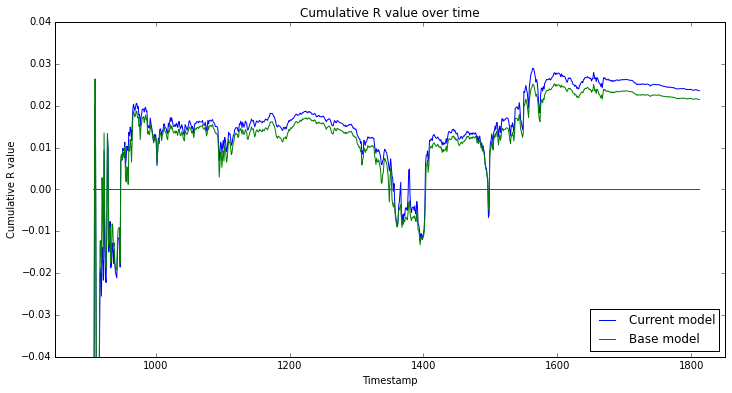

In [106]:
base_cum_R = pd.read_csv("base_cum_R.csv", encoding="utf-8")

plt.figure(figsize=(12,6))
plt.plot(base_cum_R["Timestamp"], cum_reward, color="blue", label="Current model")
plt.plot(base_cum_R["Timestamp"], base_cum_R["Cumulative_R"], color="green", label="Base model")
plt.plot(base_cum_R["Timestamp"], [0]*len(timestamp_list), color="red")
plt.title("Cumulative R value over time")
plt.xlabel("Timestamp")
plt.ylabel("Cumulative R value")
plt.xlim(850, 1850)
plt.ylim(-0.04, 0.04)
plt.legend(loc="lower right")
plt.show()

##Cross-validation

In [22]:
n_estimators_grid = [200, 300]
max_depth_grid = [5, 6]

score = []

t0 = time()

for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        
        print("Parameters: \n     n_estimators:{0} \n     max_depth: {1}"\
              .format(n_estimators, max_depth))
        
        # The "environment" is our interface.
        env = kagglegym.make()

        # We get our initial observation by calling "reset".
        o = env.reset()

        excl = ["id", "timestamp", "y"]
        col = [c for c in o.train.columns if c not in excl]
        train = o.train.loc[:, col]

        # Total number of NA values per observation.
        train.loc[:, "is_null"] = train.isnull().sum(axis=1)

        # Record NA values and then fill them with the median.
        d_mean = train.median(axis=0)

        for c in col:
            train.loc[:, c + "_nan"] = pd.isnull(train[c])
            d_mean[c + "_nan"] = 0

        train = train.fillna(d_mean)
        
        # Model 1
        low_y_cut = -0.075
        high_y_cut = 0.075
        y_is_above_cut = (o.train.y > high_y_cut)
        y_is_below_cut = (o.train.y < low_y_cut)
        y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
        model_1 = LinearRegression(n_jobs=-1)
        model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
                    o.train.loc[y_is_within_cut, "y"])
        
        # Model 2
        extra_trees = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                          n_jobs=-1, random_state=17, verbose=0)
        model_2 = extra_trees.fit(train, o.train["y"])

        ymean_dict = dict(o.train.groupby(["id"])["y"].median())

        while True:
            test = o.features.loc[:, col]
            # Total number of NA values per observation.
            test.loc[:, "is_null"] = test.isnull().sum(axis=1)

            # Fill NA values.
            for c in col:
                test.loc[:, c + "_nan"] = pd.isnull(test[c])

            test = test.fillna(d_mean)

            pred = o.target
            test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

            # Ponderation of the two models.
            pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                         + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
            # Add the median of the target value by ID.
            pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)

            # The target values have 6 decimals in the training set.
            pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]

            o, reward, done, info = env.step(pred)
            if done:
                print("Finished", info["public_score"])
                break
            if o.features.timestamp[0] % 100 == 0:
                print(reward)
        
        score.append(info["public_score"])

        print("Running time: {0}s.".format(time() - t0))

Parameters: 
     n_estimators:200 
     max_depth: 5
-0.317612904033
-0.182022570997
-0.169765407348
0.0155721899717
-0.120887529213
-0.161751403784
-0.207983802147
-0.304530203505
-0.0193565919651
('Finished', 0.022544354775984359)
Running time: 1942.98224711s.
Parameters: 
     n_estimators:200 
     max_depth: 6
-0.317964370131
-0.181636354313
-0.170090172396
0.0210891114915
-0.122100133863
-0.15869220995
-0.208973403429
-0.304452852273
-0.0227012427798
('Finished', 0.023818689235850024)
Running time: 4134.09156013s.
Parameters: 
     n_estimators:300 
     max_depth: 5
-0.317710106052
-0.18212292887
-0.169783469952
0.0200483728335
-0.121449198546
-0.16200032081
-0.208525665085
-0.304498983443
-0.0229799518439
('Finished', 0.022265339569625051)
Running time: 6898.75451612s.
Parameters: 
     n_estimators:300 
     max_depth: 6
-0.318000512358
-0.18192592894
-0.170338108637
0.0224381742101
-0.123044219716
-0.158405005328
-0.210106180808
-0.304121947237
-0.0268123027067
('Finished', 

In [ ]:
#0.0148877463784 for model_1 only (8 mins)
#0.021473779155142633  for model_1 and model_2 (7 mins)

# First cross-validation
#Parameters: 
     #n_estimators:200 
     #max_depth: 5
#
#('Finished', 0.022544354775984359)

#Running time: 1942.98224711s.
#Parameters: 
     #n_estimators:200 
     #max_depth: 6
#('Finished', 0.023818689235850024)
#Running time: 4134.09156013s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 5
#('Finished', 0.022265339569625051)

#Running time: 6898.75451612s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 6
#('Finished', 0.023778939527378237)
#Running time: 10013.6646042s.

## Approximating LB score

In [2]:
full_train = pd.read_hdf("train.h5")
o_train, o_test = train_test_split(full_train, test_size = 0.5, random_state=0)

In [3]:
excl = ["id", "timestamp", "y"]
#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
col = [c for c in o_train.columns if c not in excl]
train = o_train.loc[:, col]

# Total number of NA values per observation.
train_NA_values = train.isnull().sum(axis=1)

# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0
    
train = train.fillna(d_mean)

train.loc[:, "is_null"] = train_NA_values

# By timestamp: std of target value thanks to the variable "technical_30" and count of assets.
#dict_y_std_timestamp = dict(np.sqrt(o_train.groupby("timestamp")["technical_30"].var()))
#train.loc[:, "y_std_timestamp"] = o_train["timestamp"].map(dict_y_std_timestamp)

#dict_assets_count = dict(o_train.groupby("timestamp")["id"].count())
#train.loc[:, "assets_count"] = o_train["timestamp"].map(dict_assets_count)

In [4]:
# Train model
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o_train.y > high_y_cut)
y_is_below_cut = (o_train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o_train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, 
                                  random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o_train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

In [5]:
model_2.feature_importances_

NameError: name 'model_2' is not defined

In [9]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [23]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o_train.groupby(["id"])["y"].median())

t0 = time()

test_timestamp = sorted(o_test.timestamp.unique())

y_predict = []
y_real = []

for timestp in test_timestamp:
    o_test_current = o_test.loc[o_test["timestamp"] == timestp, :]
    
    test = o_test_current.loc[:, col]
    y_real.extend(o_test_current.loc[:, "y"])

    # Total number of NA values per observation.
    test_NA_values = test.isnull().sum(axis=1)

    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)

    test.loc[:, "is_null"] = test_NA_values

    # By timestamp: std of target value thanks to the variable "technical_30" and count of assets.
    #dict_y_std_timestamp = dict(np.sqrt(o_test.groupby("timestamp")["technical_30"].var()))
    #test.loc[:, "y_std_timestamp"] = o_test["timestamp"].map(dict_y_std_timestamp)

    #dict_assets_count = dict(o_test.groupby("timestamp")["id"].count())
    #test.loc[:, "assets_count"] = o_test["timestamp"].map(dict_assets_count)

    pred = o_test_current[["id", "y"]]
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

    # Ponderation of the two models.
    pred.loc[:, "y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                  + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred.loc[:, "y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] 
                           if x["id"] in ymean_dict 
                           else x["y"], axis=1)

    # The target values have 6 decimals in the training set.
    pred.loc[:, "y"] = [float(format(x, ".6f")) for x in pred.loc[:, "y"]]
    
    y_predict.extend(pred["y"])

LB_score = get_reward(np.array(y_real), np.array(y_predict))

print("Finished", LB_score)

print("Running time: {0}s.".format(time() - t0))

('Finished', 0.021145763244338721)
Running time: 792.615553141s.


In [ ]:
# Base model 0.021145763244338721 
# With std and assets count 0.024937997299229516 

In [34]:
df_y_plot = o_test.loc[:, ["timestamp"]]
df_y_plot.loc[:, "y"] = np.array(y_predict)

plt.figure(figsize=(12, 6))
plt.plot(o_test.groupby("timestamp")["y"].var(), color="blue")
plt.plot(df_y_plot.groupby("timestamp")["y"].var(), color="red")
plt.xlim(0, 500)
plt.ylim(0, 0.001)
plt.show()